Q 1(a),1(b),1(c)

In [ ]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler
from torch.nn.modules import dropout
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [ ]:
model_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


### Model Summary

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_resnet = model_resnet.to(device)
summary(model_resnet, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip /content/tiny-imagenet-200.zip

In [ ]:
DATA_DIR = 'tiny-imagenet-200' 

TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

In [ ]:
def custom_dataloader(data, name, transform):
    if data is None:
        return None
    

    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)


    use_cuda = torch.cuda.is_available()
    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 2}
    else:
        kwargs = {}
    
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                        shuffle=(name=="train"), 
                        **kwargs)
    
    return dataloader

In [ ]:

val_img_dir = os.path.join(VALID_DIR, 'images')


fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()



In [ ]:

for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [ ]:
preprocess_transform_train = T.Compose([
        
                T.ToTensor(),  
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
])

In [ ]:

batch_size = 256
n_epochs = 11


train_loader = custom_dataloader(TRAIN_DIR, "train",
                                  transform=preprocess_transform_train)

val_loader = custom_dataloader(val_img_dir, "val",
                                 transform=preprocess_transform_train)

In [ ]:
model_resnet = model_resnet.to(device)

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
criterion = nn.CrossEntropyLoss()



def train(model, device, train_loader, optimizer, epoch, last_loss):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() 

    y_pred = model(data) 
    loss = criterion(y_pred, target) 
    train_losses.append(loss)


    if loss - last_loss >= eps:
      trigger_times += 1
      print('Trigger Times:', trigger_times)

      if trigger_times >= patience:
        print('Early stopping!\nStarting test process.')
        break

    else:
      trigger_times = 0

    last_loss = loss

    loss.backward() # backpropagation
    optimizer.step()
    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    
    print(f'Accuracy={100. * correct / processed:0.2f}\n')
    train_acc.append(100. * correct / processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() 
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

### resnet training

In [ ]:

optimizer = optim.SGD(model_resnet.parameters(), lr=0.01, momentum=0.9)
last_loss = 1000000
patience = 5
trigger_times = 0
eps = 0.001

for epoch in range(1, n_epochs+1): 
    print('Epoch:',  epoch)
    train(model_resnet, device, train_loader, optimizer, epoch, last_loss)
    test(model_resnet, device, val_loader)

Epoch: 1


Loss=6.149013519287109 Batch_id=6 Accuracy=0.45:   2%|▏         | 7/391 [00:05<04:43,  1.35it/s]

Trigger Times: 1


Loss=5.66899299621582 Batch_id=11 Accuracy=0.55:   3%|▎         | 12/391 [00:09<04:38,  1.36it/s]

Trigger Times: 1


Loss=5.665878772735596 Batch_id=13 Accuracy=0.53:   4%|▎         | 14/391 [00:10<04:37,  1.36it/s]

Trigger Times: 1


Loss=5.499045372009277 Batch_id=15 Accuracy=0.51:   4%|▍         | 16/391 [00:12<04:36,  1.36it/s]

Trigger Times: 1


Loss=5.57068395614624 Batch_id=16 Accuracy=0.55:   4%|▍         | 17/391 [00:12<04:35,  1.36it/s]

Trigger Times: 2


Loss=5.557948589324951 Batch_id=18 Accuracy=0.51:   5%|▍         | 19/391 [00:14<04:36,  1.35it/s]

Trigger Times: 1


Loss=5.560120105743408 Batch_id=20 Accuracy=0.54:   5%|▌         | 21/391 [00:15<04:33,  1.35it/s]

Trigger Times: 1


Loss=5.530588626861572 Batch_id=22 Accuracy=0.54:   6%|▌         | 23/391 [00:17<04:34,  1.34it/s]

Trigger Times: 1


Loss=5.599209308624268 Batch_id=23 Accuracy=0.54:   6%|▌         | 24/391 [00:18<04:33,  1.34it/s]

Trigger Times: 2


Loss=5.439810276031494 Batch_id=25 Accuracy=0.50:   7%|▋         | 26/391 [00:19<04:30,  1.35it/s]

Trigger Times: 1


Loss=5.5419921875 Batch_id=27 Accuracy=0.52:   7%|▋         | 28/391 [00:21<04:29,  1.35it/s]

Trigger Times: 1


Loss=5.5469746589660645 Batch_id=28 Accuracy=0.51:   7%|▋         | 29/391 [00:21<04:27,  1.35it/s]

Trigger Times: 2


Loss=5.628232955932617 Batch_id=29 Accuracy=0.51:   8%|▊         | 30/391 [00:22<04:27,  1.35it/s]

Trigger Times: 3


Loss=5.53767728805542 Batch_id=32 Accuracy=0.50:   8%|▊         | 33/391 [00:24<04:23,  1.36it/s]

Trigger Times: 1


Loss=5.503387928009033 Batch_id=34 Accuracy=0.51:   9%|▉         | 35/391 [00:26<04:19,  1.37it/s]

Trigger Times: 1


Loss=5.614807605743408 Batch_id=35 Accuracy=0.53:   9%|▉         | 36/391 [00:26<04:17,  1.38it/s]

Trigger Times: 2


Loss=5.534702777862549 Batch_id=39 Accuracy=0.54:  10%|█         | 40/391 [00:29<04:14,  1.38it/s]

Trigger Times: 1


Loss=5.49564266204834 Batch_id=43 Accuracy=0.57:  11%|█▏        | 44/391 [00:32<04:11,  1.38it/s]

Trigger Times: 1


Loss=5.380777359008789 Batch_id=47 Accuracy=0.57:  12%|█▏        | 48/391 [00:35<04:08,  1.38it/s]

Trigger Times: 1


Loss=5.482704162597656 Batch_id=48 Accuracy=0.58:  13%|█▎        | 49/391 [00:36<04:08,  1.38it/s]

Trigger Times: 2


Loss=5.494941234588623 Batch_id=49 Accuracy=0.61:  13%|█▎        | 50/391 [00:37<04:08,  1.37it/s]

Trigger Times: 3


Loss=5.425887107849121 Batch_id=51 Accuracy=0.61:  13%|█▎        | 52/391 [00:38<04:06,  1.38it/s]

Trigger Times: 1


Loss=5.508124351501465 Batch_id=52 Accuracy=0.60:  14%|█▎        | 53/391 [00:39<04:06,  1.37it/s]

Trigger Times: 2


Loss=5.533378601074219 Batch_id=54 Accuracy=0.60:  14%|█▍        | 55/391 [00:40<04:04,  1.38it/s]

Trigger Times: 1


Loss=5.45976448059082 Batch_id=57 Accuracy=0.64:  15%|█▍        | 58/391 [00:42<04:03,  1.37it/s]

Trigger Times: 1


Loss=5.490711688995361 Batch_id=59 Accuracy=0.64:  15%|█▌        | 60/391 [00:44<04:01,  1.37it/s]

Trigger Times: 1


Loss=5.427000999450684 Batch_id=62 Accuracy=0.63:  16%|█▌        | 63/391 [00:46<04:00,  1.36it/s]

Trigger Times: 1


Loss=5.528194427490234 Batch_id=63 Accuracy=0.63:  16%|█▋        | 64/391 [00:47<03:59,  1.37it/s]

Trigger Times: 2


Loss=5.510774612426758 Batch_id=66 Accuracy=0.66:  17%|█▋        | 67/391 [00:49<03:56,  1.37it/s]

Trigger Times: 1


Loss=5.462249279022217 Batch_id=69 Accuracy=0.66:  18%|█▊        | 70/391 [00:51<03:54,  1.37it/s]

Trigger Times: 1


Loss=5.340463638305664 Batch_id=73 Accuracy=0.71:  19%|█▉        | 74/391 [00:54<03:52,  1.36it/s]

Trigger Times: 1


Loss=5.437962532043457 Batch_id=74 Accuracy=0.73:  19%|█▉        | 75/391 [00:55<03:53,  1.35it/s]

Trigger Times: 2


Loss=5.4408698081970215 Batch_id=76 Accuracy=0.73:  20%|█▉        | 77/391 [00:56<03:51,  1.36it/s]

Trigger Times: 1


Loss=5.39119815826416 Batch_id=78 Accuracy=0.74:  20%|██        | 79/391 [00:58<03:50,  1.36it/s]

Trigger Times: 1


Loss=5.3256731033325195 Batch_id=80 Accuracy=0.78:  21%|██        | 81/391 [00:59<03:47,  1.36it/s]

Trigger Times: 1


Loss=5.4137983322143555 Batch_id=82 Accuracy=0.81:  21%|██        | 83/391 [01:01<03:46,  1.36it/s]

Trigger Times: 1


Loss=5.415284633636475 Batch_id=84 Accuracy=0.82:  22%|██▏       | 85/391 [01:02<03:44,  1.36it/s]

Trigger Times: 1


Loss=5.388871669769287 Batch_id=86 Accuracy=0.83:  22%|██▏       | 87/391 [01:04<03:43,  1.36it/s]

Trigger Times: 1


Loss=5.314426422119141 Batch_id=88 Accuracy=0.83:  23%|██▎       | 89/391 [01:05<03:42,  1.36it/s]

Trigger Times: 1


Loss=5.383989334106445 Batch_id=91 Accuracy=0.85:  24%|██▎       | 92/391 [01:07<03:41,  1.35it/s]

Trigger Times: 1


Loss=5.332309246063232 Batch_id=94 Accuracy=0.90:  24%|██▍       | 95/391 [01:10<03:39,  1.35it/s]

Trigger Times: 1


Loss=5.410895347595215 Batch_id=95 Accuracy=0.90:  25%|██▍       | 96/391 [01:10<03:37,  1.36it/s]

Trigger Times: 2


Loss=5.257252216339111 Batch_id=99 Accuracy=0.91:  26%|██▌       | 100/391 [01:13<03:33,  1.36it/s]

Trigger Times: 1


Loss=5.238816261291504 Batch_id=102 Accuracy=0.92:  26%|██▋       | 103/391 [01:16<03:31,  1.36it/s]

Trigger Times: 1


Loss=5.295812606811523 Batch_id=104 Accuracy=0.94:  27%|██▋       | 105/391 [01:17<03:30,  1.36it/s]

Trigger Times: 1


Loss=5.268950462341309 Batch_id=106 Accuracy=0.94:  27%|██▋       | 107/391 [01:19<03:30,  1.35it/s]

Trigger Times: 1


Loss=5.338523864746094 Batch_id=107 Accuracy=0.95:  28%|██▊       | 108/391 [01:19<03:29,  1.35it/s]

Trigger Times: 2


Loss=5.2093000411987305 Batch_id=109 Accuracy=0.96:  28%|██▊       | 110/391 [01:21<03:27,  1.35it/s]

Trigger Times: 1


Loss=5.31833028793335 Batch_id=110 Accuracy=0.96:  28%|██▊       | 111/391 [01:22<03:27,  1.35it/s]

Trigger Times: 2


Loss=5.3567304611206055 Batch_id=111 Accuracy=0.97:  29%|██▊       | 112/391 [01:22<03:27,  1.34it/s]

Trigger Times: 3


Loss=5.274645805358887 Batch_id=113 Accuracy=0.98:  29%|██▉       | 114/391 [01:24<03:25,  1.35it/s]

Trigger Times: 1


Loss=5.214876174926758 Batch_id=115 Accuracy=1.00:  30%|██▉       | 116/391 [01:25<03:23,  1.35it/s]

Trigger Times: 1


Loss=5.247751712799072 Batch_id=116 Accuracy=1.01:  30%|██▉       | 117/391 [01:26<03:23,  1.35it/s]

Trigger Times: 2


Loss=5.298840522766113 Batch_id=120 Accuracy=1.04:  31%|███       | 121/391 [01:29<03:18,  1.36it/s]

Trigger Times: 1


Loss=5.332122802734375 Batch_id=121 Accuracy=1.05:  31%|███       | 122/391 [01:30<03:17,  1.36it/s]

Trigger Times: 2


Loss=5.235752582550049 Batch_id=123 Accuracy=1.07:  32%|███▏      | 124/391 [01:31<03:16,  1.36it/s]

Trigger Times: 1


Loss=5.250681400299072 Batch_id=124 Accuracy=1.08:  32%|███▏      | 125/391 [01:32<03:15,  1.36it/s]

Trigger Times: 2


Loss=5.2731499671936035 Batch_id=125 Accuracy=1.10:  32%|███▏      | 126/391 [01:33<03:16,  1.35it/s]

Trigger Times: 3


Loss=5.257602691650391 Batch_id=127 Accuracy=1.12:  33%|███▎      | 128/391 [01:34<03:13,  1.36it/s]

Trigger Times: 1


Loss=5.229335784912109 Batch_id=130 Accuracy=1.13:  34%|███▎      | 131/391 [01:36<03:12,  1.35it/s]

Trigger Times: 1


Loss=5.23514461517334 Batch_id=131 Accuracy=1.13:  34%|███▍      | 132/391 [01:37<03:12,  1.35it/s]

Trigger Times: 2


Loss=5.276468753814697 Batch_id=132 Accuracy=1.13:  34%|███▍      | 133/391 [01:38<03:12,  1.34it/s]

Trigger Times: 3


Loss=5.306055545806885 Batch_id=133 Accuracy=1.14:  34%|███▍      | 134/391 [01:39<03:11,  1.34it/s]

Trigger Times: 4


Loss=5.245233058929443 Batch_id=135 Accuracy=1.15:  35%|███▍      | 136/391 [01:40<03:08,  1.35it/s]

Trigger Times: 1


Loss=5.199002265930176 Batch_id=137 Accuracy=1.17:  35%|███▌      | 138/391 [01:41<03:08,  1.35it/s]

Trigger Times: 1


Loss=5.0951457023620605 Batch_id=140 Accuracy=1.18:  36%|███▌      | 141/391 [01:44<03:04,  1.35it/s]

Trigger Times: 1


Loss=5.157897472381592 Batch_id=141 Accuracy=1.18:  36%|███▋      | 142/391 [01:44<03:03,  1.35it/s]

Trigger Times: 2


Loss=5.170403957366943 Batch_id=144 Accuracy=1.22:  37%|███▋      | 145/391 [01:47<03:00,  1.36it/s]

Trigger Times: 1


Loss=5.221269607543945 Batch_id=145 Accuracy=1.23:  37%|███▋      | 146/391 [01:47<03:00,  1.35it/s]

Trigger Times: 2


Loss=5.326166152954102 Batch_id=146 Accuracy=1.23:  38%|███▊      | 147/391 [01:48<02:59,  1.36it/s]

Trigger Times: 3


Loss=5.241995811462402 Batch_id=149 Accuracy=1.24:  38%|███▊      | 150/391 [01:50<02:58,  1.35it/s]

Trigger Times: 1


Loss=5.075056076049805 Batch_id=152 Accuracy=1.25:  39%|███▉      | 153/391 [01:53<02:55,  1.36it/s]

Trigger Times: 1


Loss=5.237277030944824 Batch_id=153 Accuracy=1.26:  39%|███▉      | 154/391 [01:53<02:55,  1.35it/s]

Trigger Times: 2


Loss=5.248729228973389 Batch_id=154 Accuracy=1.27:  40%|███▉      | 155/391 [01:54<02:55,  1.35it/s]

Trigger Times: 3


Loss=5.285475730895996 Batch_id=155 Accuracy=1.27:  40%|███▉      | 156/391 [01:55<02:54,  1.35it/s]

Trigger Times: 4


Loss=5.1372785568237305 Batch_id=157 Accuracy=1.29:  40%|████      | 158/391 [01:56<02:52,  1.35it/s]

Trigger Times: 1


Loss=5.165825366973877 Batch_id=158 Accuracy=1.28:  41%|████      | 159/391 [01:57<02:51,  1.35it/s]

Trigger Times: 2


Loss=5.236236095428467 Batch_id=159 Accuracy=1.29:  41%|████      | 160/391 [01:58<02:50,  1.35it/s]

Trigger Times: 3


Loss=5.156237602233887 Batch_id=163 Accuracy=1.30:  42%|████▏     | 164/391 [02:01<02:48,  1.35it/s]

Trigger Times: 1


Loss=5.217431545257568 Batch_id=164 Accuracy=1.30:  42%|████▏     | 165/391 [02:01<02:46,  1.36it/s]

Trigger Times: 2


Loss=5.160037040710449 Batch_id=166 Accuracy=1.31:  43%|████▎     | 167/391 [02:03<02:44,  1.36it/s]

Trigger Times: 1


Loss=5.108844757080078 Batch_id=168 Accuracy=1.32:  43%|████▎     | 169/391 [02:04<02:43,  1.36it/s]

Trigger Times: 1


Loss=5.160940170288086 Batch_id=171 Accuracy=1.34:  44%|████▍     | 172/391 [02:07<02:42,  1.35it/s]

Trigger Times: 1


Loss=5.085748672485352 Batch_id=173 Accuracy=1.35:  45%|████▍     | 174/391 [02:08<02:40,  1.35it/s]

Trigger Times: 1


Loss=5.112782955169678 Batch_id=174 Accuracy=1.36:  45%|████▍     | 175/391 [02:09<02:39,  1.35it/s]

Trigger Times: 2


Loss=5.139135360717773 Batch_id=175 Accuracy=1.37:  45%|████▌     | 176/391 [02:10<02:39,  1.35it/s]

Trigger Times: 3


Loss=5.174831390380859 Batch_id=177 Accuracy=1.36:  46%|████▌     | 178/391 [02:11<02:37,  1.35it/s]

Trigger Times: 1


Loss=5.069188117980957 Batch_id=179 Accuracy=1.37:  46%|████▌     | 180/391 [02:13<02:36,  1.35it/s]

Trigger Times: 1


Loss=5.17011022567749 Batch_id=180 Accuracy=1.38:  46%|████▋     | 181/391 [02:13<02:36,  1.34it/s]

Trigger Times: 2


Loss=5.212677001953125 Batch_id=181 Accuracy=1.39:  47%|████▋     | 182/391 [02:14<02:35,  1.35it/s]

Trigger Times: 3


Loss=5.081453800201416 Batch_id=183 Accuracy=1.40:  47%|████▋     | 184/391 [02:16<02:33,  1.35it/s]

Trigger Times: 1


Loss=5.160064220428467 Batch_id=184 Accuracy=1.40:  47%|████▋     | 185/391 [02:16<02:32,  1.35it/s]

Trigger Times: 2


Loss=5.17564582824707 Batch_id=185 Accuracy=1.41:  48%|████▊     | 186/391 [02:17<02:32,  1.35it/s]

Trigger Times: 3


Loss=5.176479339599609 Batch_id=186 Accuracy=1.41:  48%|████▊     | 187/391 [02:18<02:31,  1.35it/s]

Trigger Times: 4


Loss=5.027947902679443 Batch_id=188 Accuracy=1.42:  48%|████▊     | 189/391 [02:19<02:29,  1.36it/s]

Trigger Times: 1


Loss=5.128141403198242 Batch_id=191 Accuracy=1.43:  49%|████▉     | 192/391 [02:21<02:26,  1.36it/s]

Trigger Times: 1


Loss=5.19351863861084 Batch_id=192 Accuracy=1.44:  49%|████▉     | 193/391 [02:22<02:26,  1.36it/s]

Trigger Times: 2


Loss=5.211339950561523 Batch_id=193 Accuracy=1.44:  50%|████▉     | 194/391 [02:23<02:25,  1.36it/s]

Trigger Times: 3


Loss=5.1286444664001465 Batch_id=195 Accuracy=1.46:  50%|█████     | 196/391 [02:24<02:23,  1.36it/s]

Trigger Times: 1


Loss=5.146119117736816 Batch_id=197 Accuracy=1.47:  51%|█████     | 198/391 [02:26<02:22,  1.36it/s]

Trigger Times: 1


Loss=4.987925052642822 Batch_id=199 Accuracy=1.49:  51%|█████     | 200/391 [02:27<02:21,  1.35it/s]

Trigger Times: 1


Loss=5.071646690368652 Batch_id=202 Accuracy=1.49:  52%|█████▏    | 203/391 [02:30<02:19,  1.35it/s]

Trigger Times: 1


Loss=5.023210048675537 Batch_id=207 Accuracy=1.51:  53%|█████▎    | 208/391 [02:33<02:14,  1.36it/s]

Trigger Times: 1


Loss=5.047433376312256 Batch_id=209 Accuracy=1.52:  54%|█████▎    | 210/391 [02:35<02:13,  1.36it/s]

Trigger Times: 1


Loss=5.017917633056641 Batch_id=213 Accuracy=1.54:  55%|█████▍    | 214/391 [02:38<02:10,  1.36it/s]

Trigger Times: 1


Loss=5.018952369689941 Batch_id=215 Accuracy=1.55:  55%|█████▌    | 216/391 [02:39<02:09,  1.36it/s]

Trigger Times: 1


Loss=5.092642307281494 Batch_id=216 Accuracy=1.56:  55%|█████▌    | 217/391 [02:40<02:08,  1.36it/s]

Trigger Times: 2


Loss=4.942894458770752 Batch_id=220 Accuracy=1.57:  57%|█████▋    | 221/391 [02:43<02:05,  1.36it/s]

Trigger Times: 1


Loss=5.011054515838623 Batch_id=221 Accuracy=1.59:  57%|█████▋    | 222/391 [02:44<02:05,  1.35it/s]

Trigger Times: 2


Loss=5.058574199676514 Batch_id=223 Accuracy=1.60:  57%|█████▋    | 224/391 [02:45<02:03,  1.35it/s]

Trigger Times: 1


Loss=4.9901556968688965 Batch_id=227 Accuracy=1.63:  58%|█████▊    | 228/391 [02:48<02:00,  1.36it/s]

Trigger Times: 1


Loss=5.045430660247803 Batch_id=228 Accuracy=1.64:  59%|█████▊    | 229/391 [02:49<01:59,  1.36it/s]

Trigger Times: 2


Loss=5.086510181427002 Batch_id=229 Accuracy=1.65:  59%|█████▉    | 230/391 [02:49<01:58,  1.36it/s]

Trigger Times: 3


Loss=5.094325065612793 Batch_id=231 Accuracy=1.66:  59%|█████▉    | 232/391 [02:51<01:56,  1.36it/s]

Trigger Times: 1


Loss=5.007023334503174 Batch_id=235 Accuracy=1.68:  60%|██████    | 236/391 [02:54<01:54,  1.36it/s]

Trigger Times: 1


Loss=5.070650577545166 Batch_id=236 Accuracy=1.68:  61%|██████    | 237/391 [02:55<01:53,  1.35it/s]

Trigger Times: 2


Loss=5.08220911026001 Batch_id=237 Accuracy=1.68:  61%|██████    | 238/391 [02:55<01:53,  1.35it/s]

Trigger Times: 3


Loss=5.002045154571533 Batch_id=240 Accuracy=1.70:  62%|██████▏   | 241/391 [02:58<01:50,  1.35it/s]

Trigger Times: 1


Loss=4.961306571960449 Batch_id=243 Accuracy=1.73:  62%|██████▏   | 244/391 [03:00<01:48,  1.36it/s]

Trigger Times: 1


Loss=4.925075054168701 Batch_id=245 Accuracy=1.75:  63%|██████▎   | 246/391 [03:01<01:47,  1.35it/s]

Trigger Times: 1


Loss=4.9142866134643555 Batch_id=247 Accuracy=1.77:  63%|██████▎   | 248/391 [03:03<01:45,  1.36it/s]

Trigger Times: 1


Loss=5.024293422698975 Batch_id=248 Accuracy=1.78:  64%|██████▎   | 249/391 [03:03<01:44,  1.36it/s]

Trigger Times: 2


Loss=5.059202671051025 Batch_id=249 Accuracy=1.79:  64%|██████▍   | 250/391 [03:04<01:44,  1.35it/s]

Trigger Times: 3


Loss=4.959652423858643 Batch_id=253 Accuracy=1.82:  65%|██████▍   | 254/391 [03:07<01:40,  1.36it/s]

Trigger Times: 1


Loss=4.922104358673096 Batch_id=259 Accuracy=1.86:  66%|██████▋   | 260/391 [03:12<01:36,  1.35it/s]

Trigger Times: 1


Loss=4.954287052154541 Batch_id=261 Accuracy=1.87:  67%|██████▋   | 262/391 [03:13<01:35,  1.36it/s]

Trigger Times: 1


Loss=4.961296558380127 Batch_id=263 Accuracy=1.88:  68%|██████▊   | 264/391 [03:15<01:33,  1.36it/s]

Trigger Times: 1


Loss=4.966899871826172 Batch_id=264 Accuracy=1.89:  68%|██████▊   | 265/391 [03:15<01:33,  1.35it/s]

Trigger Times: 2


Loss=4.983801364898682 Batch_id=265 Accuracy=1.89:  68%|██████▊   | 266/391 [03:16<01:32,  1.36it/s]

Trigger Times: 3


Loss=4.8605241775512695 Batch_id=268 Accuracy=1.90:  69%|██████▉   | 269/391 [03:18<01:30,  1.35it/s]

Trigger Times: 1


Loss=4.988383769989014 Batch_id=269 Accuracy=1.90:  69%|██████▉   | 270/391 [03:19<01:29,  1.35it/s]

Trigger Times: 2


Loss=4.945770263671875 Batch_id=272 Accuracy=1.91:  70%|██████▉   | 273/391 [03:21<01:27,  1.35it/s]

Trigger Times: 1


Loss=4.958100318908691 Batch_id=273 Accuracy=1.91:  70%|███████   | 274/391 [03:22<01:26,  1.35it/s]

Trigger Times: 2


Loss=4.974225997924805 Batch_id=274 Accuracy=1.92:  70%|███████   | 275/391 [03:23<01:25,  1.35it/s]

Trigger Times: 3


Loss=4.904998302459717 Batch_id=277 Accuracy=1.94:  71%|███████   | 278/391 [03:25<01:23,  1.35it/s]

Trigger Times: 1


Loss=4.944453239440918 Batch_id=279 Accuracy=1.95:  72%|███████▏  | 280/391 [03:26<01:21,  1.35it/s]

Trigger Times: 1


Loss=4.939399242401123 Batch_id=282 Accuracy=1.96:  72%|███████▏  | 283/391 [03:29<01:19,  1.35it/s]

Trigger Times: 1


Loss=4.804041862487793 Batch_id=284 Accuracy=1.99:  73%|███████▎  | 285/391 [03:30<01:18,  1.35it/s]

Trigger Times: 1


Loss=4.867837905883789 Batch_id=286 Accuracy=2.00:  73%|███████▎  | 287/391 [03:32<01:16,  1.35it/s]

Trigger Times: 1


Loss=4.934842586517334 Batch_id=287 Accuracy=2.00:  74%|███████▎  | 288/391 [03:32<01:16,  1.36it/s]

Trigger Times: 2


Loss=4.887914657592773 Batch_id=289 Accuracy=2.01:  74%|███████▍  | 290/391 [03:34<01:14,  1.36it/s]

Trigger Times: 1


Loss=4.818637371063232 Batch_id=291 Accuracy=2.02:  75%|███████▍  | 292/391 [03:35<01:12,  1.36it/s]

Trigger Times: 1


Loss=4.948500633239746 Batch_id=294 Accuracy=2.03:  75%|███████▌  | 295/391 [03:37<01:11,  1.35it/s]

Trigger Times: 1


Loss=4.967356204986572 Batch_id=295 Accuracy=2.04:  76%|███████▌  | 296/391 [03:38<01:10,  1.35it/s]

Trigger Times: 2


Loss=5.008559226989746 Batch_id=297 Accuracy=2.04:  76%|███████▌  | 298/391 [03:40<01:08,  1.35it/s]

Trigger Times: 1


Loss=4.890383243560791 Batch_id=300 Accuracy=2.05:  77%|███████▋  | 301/391 [03:42<01:06,  1.35it/s]

Trigger Times: 1


Loss=4.987431526184082 Batch_id=301 Accuracy=2.05:  77%|███████▋  | 302/391 [03:43<01:05,  1.35it/s]

Trigger Times: 2


Loss=4.940207481384277 Batch_id=303 Accuracy=2.06:  78%|███████▊  | 304/391 [03:44<01:04,  1.36it/s]

Trigger Times: 1


Loss=4.947339057922363 Batch_id=304 Accuracy=2.07:  78%|███████▊  | 305/391 [03:45<01:03,  1.35it/s]

Trigger Times: 2


Loss=4.9287590980529785 Batch_id=307 Accuracy=2.08:  79%|███████▉  | 308/391 [03:47<01:01,  1.36it/s]

Trigger Times: 1


Loss=4.9192094802856445 Batch_id=309 Accuracy=2.09:  79%|███████▉  | 310/391 [03:49<00:59,  1.36it/s]

Trigger Times: 1


Loss=4.900594711303711 Batch_id=311 Accuracy=2.10:  80%|███████▉  | 312/391 [03:50<00:58,  1.36it/s]

Trigger Times: 1


Loss=4.91915225982666 Batch_id=312 Accuracy=2.10:  80%|████████  | 313/391 [03:51<00:57,  1.36it/s]

Trigger Times: 2


Loss=4.845639705657959 Batch_id=314 Accuracy=2.11:  81%|████████  | 315/391 [03:52<00:56,  1.36it/s]

Trigger Times: 1


Loss=4.939407825469971 Batch_id=316 Accuracy=2.11:  81%|████████  | 317/391 [03:54<00:54,  1.35it/s]

Trigger Times: 1


Loss=4.930873870849609 Batch_id=318 Accuracy=2.12:  82%|████████▏ | 319/391 [03:55<00:53,  1.35it/s]

Trigger Times: 1


Loss=4.832551002502441 Batch_id=320 Accuracy=2.12:  82%|████████▏ | 321/391 [03:57<00:51,  1.35it/s]

Trigger Times: 1


Loss=4.852375030517578 Batch_id=321 Accuracy=2.13:  82%|████████▏ | 322/391 [03:57<00:51,  1.35it/s]

Trigger Times: 2


Loss=4.925042629241943 Batch_id=322 Accuracy=2.13:  83%|████████▎ | 323/391 [03:58<00:50,  1.35it/s]

Trigger Times: 3


Loss=4.795331001281738 Batch_id=324 Accuracy=2.14:  83%|████████▎ | 325/391 [04:00<00:48,  1.36it/s]

Trigger Times: 1


Loss=4.82295560836792 Batch_id=327 Accuracy=2.16:  84%|████████▍ | 328/391 [04:02<00:46,  1.36it/s]

Trigger Times: 1


Loss=4.769315719604492 Batch_id=329 Accuracy=2.18:  84%|████████▍ | 330/391 [04:03<00:44,  1.36it/s]

Trigger Times: 1


Loss=4.7944722175598145 Batch_id=332 Accuracy=2.19:  85%|████████▌ | 333/391 [04:05<00:42,  1.36it/s]

Trigger Times: 1


Loss=4.854836463928223 Batch_id=333 Accuracy=2.20:  85%|████████▌ | 334/391 [04:06<00:42,  1.35it/s]

Trigger Times: 2


Loss=4.903931140899658 Batch_id=335 Accuracy=2.21:  86%|████████▌ | 336/391 [04:08<00:40,  1.35it/s]

Trigger Times: 1


Loss=4.93847131729126 Batch_id=336 Accuracy=2.21:  86%|████████▌ | 337/391 [04:08<00:40,  1.35it/s]

Trigger Times: 2


Loss=4.743075370788574 Batch_id=338 Accuracy=2.22:  87%|████████▋ | 339/391 [04:10<00:38,  1.35it/s]

Trigger Times: 1


Loss=4.861242771148682 Batch_id=340 Accuracy=2.23:  87%|████████▋ | 341/391 [04:11<00:37,  1.35it/s]

Trigger Times: 1


Loss=4.876823425292969 Batch_id=341 Accuracy=2.23:  87%|████████▋ | 342/391 [04:12<00:36,  1.35it/s]

Trigger Times: 2


Loss=4.764499664306641 Batch_id=345 Accuracy=2.25:  88%|████████▊ | 346/391 [04:15<00:33,  1.35it/s]

Trigger Times: 1


Loss=4.858829975128174 Batch_id=346 Accuracy=2.26:  89%|████████▊ | 347/391 [04:16<00:32,  1.35it/s]

Trigger Times: 2


Loss=4.880399227142334 Batch_id=348 Accuracy=2.28:  89%|████████▉ | 349/391 [04:17<00:30,  1.35it/s]

Trigger Times: 1


Loss=4.918480396270752 Batch_id=350 Accuracy=2.28:  90%|████████▉ | 351/391 [04:19<00:29,  1.36it/s]

Trigger Times: 1


Loss=4.94801139831543 Batch_id=352 Accuracy=2.28:  90%|█████████ | 353/391 [04:20<00:28,  1.35it/s]

Trigger Times: 1


Loss=4.734766960144043 Batch_id=354 Accuracy=2.30:  91%|█████████ | 355/391 [04:22<00:26,  1.35it/s]

Trigger Times: 1


Loss=4.7906622886657715 Batch_id=357 Accuracy=2.33:  92%|█████████▏| 358/391 [04:24<00:24,  1.35it/s]

Trigger Times: 1


Loss=4.80382776260376 Batch_id=359 Accuracy=2.34:  92%|█████████▏| 360/391 [04:25<00:22,  1.35it/s]

Trigger Times: 1


Loss=4.853604793548584 Batch_id=360 Accuracy=2.35:  92%|█████████▏| 361/391 [04:26<00:22,  1.35it/s]

Trigger Times: 2


Loss=4.826807975769043 Batch_id=362 Accuracy=2.37:  93%|█████████▎| 363/391 [04:28<00:20,  1.34it/s]

Trigger Times: 1


Loss=4.891919136047363 Batch_id=363 Accuracy=2.38:  93%|█████████▎| 364/391 [04:28<00:20,  1.34it/s]

Trigger Times: 2


Loss=4.796395778656006 Batch_id=366 Accuracy=2.40:  94%|█████████▍| 367/391 [04:31<00:17,  1.35it/s]

Trigger Times: 1


Loss=4.915270805358887 Batch_id=367 Accuracy=2.40:  94%|█████████▍| 368/391 [04:31<00:17,  1.34it/s]

Trigger Times: 2


Loss=4.752716541290283 Batch_id=369 Accuracy=2.41:  95%|█████████▍| 370/391 [04:33<00:15,  1.34it/s]

Trigger Times: 1


Loss=4.925008773803711 Batch_id=370 Accuracy=2.41:  95%|█████████▍| 371/391 [04:34<00:14,  1.34it/s]

Trigger Times: 2


Loss=4.717824459075928 Batch_id=373 Accuracy=2.43:  96%|█████████▌| 374/391 [04:36<00:12,  1.35it/s]

Trigger Times: 1


Loss=4.771899700164795 Batch_id=376 Accuracy=2.44:  96%|█████████▋| 377/391 [04:38<00:10,  1.36it/s]

Trigger Times: 1


Loss=4.731692790985107 Batch_id=381 Accuracy=2.47:  98%|█████████▊| 382/391 [04:42<00:06,  1.36it/s]

Trigger Times: 1


Loss=4.7567830085754395 Batch_id=383 Accuracy=2.48:  98%|█████████▊| 384/391 [04:43<00:05,  1.36it/s]

Trigger Times: 1


Loss=4.779684543609619 Batch_id=386 Accuracy=2.50:  99%|█████████▉| 387/391 [04:45<00:02,  1.35it/s]

Trigger Times: 1


Loss=4.802289962768555 Batch_id=387 Accuracy=2.51:  99%|█████████▉| 388/391 [04:46<00:02,  1.35it/s]

Trigger Times: 2


Loss=4.886341571807861 Batch_id=388 Accuracy=2.51:  99%|█████████▉| 389/391 [04:47<00:01,  1.35it/s]

Trigger Times: 3


Loss=4.596854209899902 Batch_id=390 Accuracy=2.52: 100%|██████████| 391/391 [04:48<00:00,  1.35it/s]



Test set: Average loss: 0.0192, Accuracy: 477/10000 (4.77%)

Epoch: 2


Loss=4.693500995635986 Batch_id=0 Accuracy=5.08:   0%|          | 1/391 [00:01<07:19,  1.13s/it]

Trigger Times: 1


Loss=4.651891708374023 Batch_id=3 Accuracy=4.98:   1%|          | 4/391 [00:03<05:06,  1.26it/s]

Trigger Times: 1


Loss=4.741171836853027 Batch_id=4 Accuracy=5.08:   1%|▏         | 5/391 [00:04<04:59,  1.29it/s]

Trigger Times: 2


Loss=4.635226726531982 Batch_id=6 Accuracy=4.69:   2%|▏         | 7/391 [00:05<04:49,  1.33it/s]

Trigger Times: 1


Loss=4.753693580627441 Batch_id=8 Accuracy=4.51:   2%|▏         | 9/391 [00:07<04:44,  1.34it/s]

Trigger Times: 1


Loss=4.695204734802246 Batch_id=10 Accuracy=4.65:   3%|▎         | 11/391 [00:08<04:41,  1.35it/s]

Trigger Times: 1


Loss=4.629863739013672 Batch_id=12 Accuracy=4.66:   3%|▎         | 13/391 [00:09<04:39,  1.35it/s]

Trigger Times: 1


Loss=4.661523342132568 Batch_id=13 Accuracy=4.83:   4%|▎         | 14/391 [00:10<04:38,  1.35it/s]

Trigger Times: 2


Loss=4.731060028076172 Batch_id=14 Accuracy=4.92:   4%|▍         | 15/391 [00:11<04:36,  1.36it/s]

Trigger Times: 3


Loss=4.700544834136963 Batch_id=16 Accuracy=4.78:   4%|▍         | 17/391 [00:12<04:34,  1.36it/s]

Trigger Times: 1


Loss=4.59765625 Batch_id=18 Accuracy=4.93:   5%|▍         | 19/391 [00:14<04:33,  1.36it/s]

Trigger Times: 1


Loss=4.628048896789551 Batch_id=20 Accuracy=5.12:   5%|▌         | 21/391 [00:15<04:33,  1.36it/s]

Trigger Times: 1


Loss=4.6731719970703125 Batch_id=22 Accuracy=5.11:   6%|▌         | 23/391 [00:17<04:31,  1.35it/s]

Trigger Times: 1


Loss=4.610742568969727 Batch_id=26 Accuracy=5.24:   7%|▋         | 27/391 [00:20<04:29,  1.35it/s]

Trigger Times: 1


Loss=4.625368118286133 Batch_id=29 Accuracy=5.39:   8%|▊         | 30/391 [00:22<04:26,  1.35it/s]

Trigger Times: 1


Loss=4.711440563201904 Batch_id=30 Accuracy=5.38:   8%|▊         | 31/391 [00:23<04:25,  1.36it/s]

Trigger Times: 2


Loss=4.672338962554932 Batch_id=32 Accuracy=5.41:   8%|▊         | 33/391 [00:24<04:24,  1.35it/s]

Trigger Times: 1


Loss=4.715685844421387 Batch_id=33 Accuracy=5.42:   9%|▊         | 34/391 [00:25<04:23,  1.36it/s]

Trigger Times: 2


Loss=4.717881202697754 Batch_id=34 Accuracy=5.47:   9%|▉         | 35/391 [00:26<04:21,  1.36it/s]

Trigger Times: 3


Loss=4.565433025360107 Batch_id=41 Accuracy=5.32:  11%|█         | 42/391 [00:31<04:16,  1.36it/s]

Trigger Times: 1


Loss=4.6186347007751465 Batch_id=43 Accuracy=5.42:  11%|█▏        | 44/391 [00:32<04:15,  1.36it/s]

Trigger Times: 1


Loss=4.5659074783325195 Batch_id=45 Accuracy=5.49:  12%|█▏        | 46/391 [00:34<04:14,  1.35it/s]

Trigger Times: 1


Loss=4.608014106750488 Batch_id=47 Accuracy=5.57:  12%|█▏        | 48/391 [00:35<04:13,  1.35it/s]

Trigger Times: 1


Loss=4.7377705574035645 Batch_id=48 Accuracy=5.56:  13%|█▎        | 49/391 [00:36<04:13,  1.35it/s]

Trigger Times: 2


Loss=4.721055507659912 Batch_id=50 Accuracy=5.54:  13%|█▎        | 51/391 [00:38<04:10,  1.35it/s]

Trigger Times: 1


Loss=4.708838939666748 Batch_id=53 Accuracy=5.48:  14%|█▍        | 54/391 [00:40<04:08,  1.36it/s]

Trigger Times: 1


Loss=4.74277400970459 Batch_id=57 Accuracy=5.46:  15%|█▍        | 58/391 [00:43<04:05,  1.35it/s]

Trigger Times: 1


Loss=4.6833062171936035 Batch_id=60 Accuracy=5.45:  16%|█▌        | 61/391 [00:45<04:03,  1.36it/s]

Trigger Times: 1


Loss=4.68064546585083 Batch_id=62 Accuracy=5.48:  16%|█▌        | 63/391 [00:46<04:02,  1.36it/s]

Trigger Times: 1


Loss=4.510656356811523 Batch_id=64 Accuracy=5.49:  17%|█▋        | 65/391 [00:48<04:01,  1.35it/s]

Trigger Times: 1


Loss=4.546432018280029 Batch_id=66 Accuracy=5.51:  17%|█▋        | 67/391 [00:49<03:59,  1.36it/s]

Trigger Times: 1


Loss=4.7415080070495605 Batch_id=69 Accuracy=5.47:  18%|█▊        | 70/391 [00:52<03:56,  1.36it/s]

Trigger Times: 1


Loss=4.6605119705200195 Batch_id=71 Accuracy=5.49:  18%|█▊        | 72/391 [00:53<03:55,  1.35it/s]

Trigger Times: 1


Loss=4.562179088592529 Batch_id=73 Accuracy=5.55:  19%|█▉        | 74/391 [00:55<03:54,  1.35it/s]

Trigger Times: 1


Loss=4.680866718292236 Batch_id=75 Accuracy=5.57:  19%|█▉        | 76/391 [00:56<03:51,  1.36it/s]

Trigger Times: 1


Loss=4.691807746887207 Batch_id=76 Accuracy=5.55:  20%|█▉        | 77/391 [00:57<03:52,  1.35it/s]

Trigger Times: 2


Loss=4.7268290519714355 Batch_id=77 Accuracy=5.55:  20%|█▉        | 78/391 [00:57<03:51,  1.35it/s]

Trigger Times: 3


Loss=4.557281970977783 Batch_id=80 Accuracy=5.57:  21%|██        | 81/391 [01:00<03:49,  1.35it/s]

Trigger Times: 1


Loss=4.67344331741333 Batch_id=82 Accuracy=5.57:  21%|██        | 83/391 [01:01<03:47,  1.35it/s]

Trigger Times: 1


Loss=4.663039207458496 Batch_id=84 Accuracy=5.58:  22%|██▏       | 85/391 [01:03<03:46,  1.35it/s]

Trigger Times: 1


Loss=4.629164218902588 Batch_id=87 Accuracy=5.57:  23%|██▎       | 88/391 [01:05<03:43,  1.35it/s]

Trigger Times: 1


Loss=4.642131805419922 Batch_id=88 Accuracy=5.59:  23%|██▎       | 89/391 [01:06<03:42,  1.36it/s]

Trigger Times: 2


Loss=4.671896457672119 Batch_id=89 Accuracy=5.56:  23%|██▎       | 90/391 [01:06<03:42,  1.35it/s]

Trigger Times: 3


Loss=4.6926589012146 Batch_id=91 Accuracy=5.56:  24%|██▎       | 92/391 [01:08<03:40,  1.36it/s]

Trigger Times: 1


Loss=4.6121826171875 Batch_id=93 Accuracy=5.57:  24%|██▍       | 94/391 [01:09<03:38,  1.36it/s]

Trigger Times: 1


Loss=4.59907865524292 Batch_id=96 Accuracy=5.57:  25%|██▍       | 97/391 [01:11<03:36,  1.36it/s]

Trigger Times: 1


Loss=4.642529010772705 Batch_id=98 Accuracy=5.55:  25%|██▌       | 99/391 [01:13<03:35,  1.35it/s]

Trigger Times: 1


Loss=4.631061553955078 Batch_id=101 Accuracy=5.56:  26%|██▌       | 102/391 [01:15<03:32,  1.36it/s]

Trigger Times: 1


Loss=4.6276679039001465 Batch_id=103 Accuracy=5.57:  27%|██▋       | 104/391 [01:17<03:31,  1.36it/s]

Trigger Times: 1


Loss=4.654177665710449 Batch_id=104 Accuracy=5.57:  27%|██▋       | 105/391 [01:17<03:31,  1.35it/s]

Trigger Times: 2


Loss=4.595755577087402 Batch_id=107 Accuracy=5.56:  28%|██▊       | 108/391 [01:20<03:29,  1.35it/s]

Trigger Times: 1


Loss=4.652851104736328 Batch_id=108 Accuracy=5.58:  28%|██▊       | 109/391 [01:20<03:28,  1.35it/s]

Trigger Times: 2


Loss=4.660649299621582 Batch_id=109 Accuracy=5.58:  28%|██▊       | 110/391 [01:21<03:29,  1.34it/s]

Trigger Times: 3


Loss=4.466323375701904 Batch_id=113 Accuracy=5.60:  29%|██▉       | 114/391 [01:24<03:24,  1.35it/s]

Trigger Times: 1


Loss=4.588708877563477 Batch_id=114 Accuracy=5.61:  29%|██▉       | 115/391 [01:25<03:23,  1.36it/s]

Trigger Times: 2


Loss=4.59132719039917 Batch_id=115 Accuracy=5.63:  30%|██▉       | 116/391 [01:26<03:22,  1.36it/s]

Trigger Times: 3


Loss=4.547916889190674 Batch_id=117 Accuracy=5.65:  30%|███       | 118/391 [01:27<03:20,  1.36it/s]

Trigger Times: 1


Loss=4.633752346038818 Batch_id=118 Accuracy=5.65:  30%|███       | 119/391 [01:28<03:20,  1.36it/s]

Trigger Times: 2


Loss=4.65130090713501 Batch_id=119 Accuracy=5.65:  31%|███       | 120/391 [01:28<03:19,  1.36it/s]

Trigger Times: 3


Loss=4.618322372436523 Batch_id=122 Accuracy=5.65:  31%|███▏      | 123/391 [01:31<03:18,  1.35it/s]

Trigger Times: 1


Loss=4.677332401275635 Batch_id=123 Accuracy=5.65:  32%|███▏      | 124/391 [01:31<03:17,  1.35it/s]

Trigger Times: 2


Loss=4.645337104797363 Batch_id=125 Accuracy=5.65:  32%|███▏      | 126/391 [01:33<03:16,  1.35it/s]

Trigger Times: 1


Loss=4.481994152069092 Batch_id=128 Accuracy=5.63:  33%|███▎      | 129/391 [01:35<03:14,  1.34it/s]

Trigger Times: 1


Loss=4.631438732147217 Batch_id=129 Accuracy=5.65:  33%|███▎      | 130/391 [01:36<03:13,  1.35it/s]

Trigger Times: 2


Loss=4.589946746826172 Batch_id=131 Accuracy=5.66:  34%|███▍      | 132/391 [01:37<03:12,  1.34it/s]

Trigger Times: 1


Loss=4.537761211395264 Batch_id=133 Accuracy=5.68:  34%|███▍      | 134/391 [01:39<03:10,  1.35it/s]

Trigger Times: 1


Loss=4.485734939575195 Batch_id=136 Accuracy=5.69:  35%|███▌      | 137/391 [01:41<03:08,  1.35it/s]

Trigger Times: 1


Loss=4.727321624755859 Batch_id=137 Accuracy=5.69:  35%|███▌      | 138/391 [01:42<03:06,  1.35it/s]

Trigger Times: 2


Loss=4.631357192993164 Batch_id=139 Accuracy=5.70:  36%|███▌      | 140/391 [01:43<03:05,  1.35it/s]

Trigger Times: 1


Loss=4.609126091003418 Batch_id=141 Accuracy=5.71:  36%|███▋      | 142/391 [01:45<03:03,  1.35it/s]

Trigger Times: 1


Loss=4.564788818359375 Batch_id=144 Accuracy=5.71:  37%|███▋      | 145/391 [01:47<03:01,  1.36it/s]

Trigger Times: 1


Loss=4.565032005310059 Batch_id=145 Accuracy=5.73:  37%|███▋      | 146/391 [01:48<03:00,  1.35it/s]

Trigger Times: 2


Loss=4.547885894775391 Batch_id=147 Accuracy=5.73:  38%|███▊      | 148/391 [01:49<03:00,  1.35it/s]

Trigger Times: 1


Loss=4.602734565734863 Batch_id=148 Accuracy=5.74:  38%|███▊      | 149/391 [01:50<02:59,  1.35it/s]

Trigger Times: 2


Loss=4.617864608764648 Batch_id=149 Accuracy=5.74:  38%|███▊      | 150/391 [01:51<02:58,  1.35it/s]

Trigger Times: 3


Loss=4.546414852142334 Batch_id=152 Accuracy=5.75:  39%|███▉      | 153/391 [01:53<02:56,  1.35it/s]

Trigger Times: 1


Loss=4.554932594299316 Batch_id=154 Accuracy=5.76:  40%|███▉      | 155/391 [01:54<02:54,  1.35it/s]

Trigger Times: 1


Loss=4.594838619232178 Batch_id=155 Accuracy=5.76:  40%|███▉      | 156/391 [01:55<02:54,  1.35it/s]

Trigger Times: 2


Loss=4.664617538452148 Batch_id=158 Accuracy=5.75:  41%|████      | 159/391 [01:57<02:51,  1.35it/s]

Trigger Times: 1


Loss=4.638866901397705 Batch_id=160 Accuracy=5.75:  41%|████      | 161/391 [01:59<02:50,  1.35it/s]

Trigger Times: 1


Loss=4.535054683685303 Batch_id=162 Accuracy=5.74:  42%|████▏     | 163/391 [02:00<02:48,  1.35it/s]

Trigger Times: 1


Loss=4.611651420593262 Batch_id=163 Accuracy=5.76:  42%|████▏     | 164/391 [02:01<02:48,  1.35it/s]

Trigger Times: 2


Loss=4.599562168121338 Batch_id=165 Accuracy=5.77:  42%|████▏     | 166/391 [02:03<02:46,  1.35it/s]

Trigger Times: 1


Loss=4.566657066345215 Batch_id=168 Accuracy=5.79:  43%|████▎     | 169/391 [02:05<02:44,  1.35it/s]

Trigger Times: 1


Loss=4.5200114250183105 Batch_id=171 Accuracy=5.82:  44%|████▍     | 172/391 [02:07<02:42,  1.35it/s]

Trigger Times: 1


Loss=4.454036235809326 Batch_id=173 Accuracy=5.84:  45%|████▍     | 174/391 [02:08<02:40,  1.35it/s]

Trigger Times: 1


Loss=4.499162673950195 Batch_id=175 Accuracy=5.89:  45%|████▌     | 176/391 [02:10<02:38,  1.35it/s]

Trigger Times: 1


Loss=4.59914493560791 Batch_id=176 Accuracy=5.90:  45%|████▌     | 177/391 [02:11<02:38,  1.35it/s]

Trigger Times: 2


Loss=4.701963901519775 Batch_id=179 Accuracy=5.90:  46%|████▌     | 180/391 [02:13<02:36,  1.35it/s]

Trigger Times: 1


Loss=4.504663944244385 Batch_id=181 Accuracy=5.91:  47%|████▋     | 182/391 [02:14<02:34,  1.35it/s]

Trigger Times: 1


Loss=4.508538722991943 Batch_id=182 Accuracy=5.92:  47%|████▋     | 183/391 [02:15<02:34,  1.35it/s]

Trigger Times: 2


Loss=4.588045120239258 Batch_id=183 Accuracy=5.91:  47%|████▋     | 184/391 [02:16<02:33,  1.35it/s]

Trigger Times: 3


Loss=4.490045547485352 Batch_id=186 Accuracy=5.93:  48%|████▊     | 187/391 [02:18<02:30,  1.36it/s]

Trigger Times: 1


Loss=4.46633243560791 Batch_id=188 Accuracy=5.95:  48%|████▊     | 189/391 [02:20<02:28,  1.36it/s]

Trigger Times: 1


Loss=4.509413719177246 Batch_id=190 Accuracy=5.99:  49%|████▉     | 191/391 [02:21<02:27,  1.36it/s]

Trigger Times: 1


Loss=4.42513370513916 Batch_id=193 Accuracy=6.03:  50%|████▉     | 194/391 [02:23<02:25,  1.35it/s]

Trigger Times: 1


Loss=4.602841854095459 Batch_id=195 Accuracy=6.05:  50%|█████     | 196/391 [02:25<02:24,  1.35it/s]

Trigger Times: 1


Loss=4.611936092376709 Batch_id=196 Accuracy=6.06:  50%|█████     | 197/391 [02:25<02:24,  1.35it/s]

Trigger Times: 2


Loss=4.464970588684082 Batch_id=199 Accuracy=6.08:  51%|█████     | 200/391 [02:28<02:20,  1.36it/s]

Trigger Times: 1


Loss=4.548163890838623 Batch_id=200 Accuracy=6.10:  51%|█████▏    | 201/391 [02:28<02:20,  1.36it/s]

Trigger Times: 2


Loss=4.506506443023682 Batch_id=203 Accuracy=6.11:  52%|█████▏    | 204/391 [02:31<02:18,  1.35it/s]

Trigger Times: 1


Loss=4.5270514488220215 Batch_id=204 Accuracy=6.12:  52%|█████▏    | 205/391 [02:31<02:17,  1.35it/s]

Trigger Times: 2


Loss=4.537323474884033 Batch_id=205 Accuracy=6.14:  53%|█████▎    | 206/391 [02:32<02:16,  1.35it/s]

Trigger Times: 3


Loss=4.544280052185059 Batch_id=206 Accuracy=6.13:  53%|█████▎    | 207/391 [02:33<02:15,  1.36it/s]

Trigger Times: 4


Loss=4.608168125152588 Batch_id=207 Accuracy=6.14:  53%|█████▎    | 208/391 [02:34<02:15,  1.35it/s]

Trigger Times: 5
Early stopping!
Starting test process.



Test set: Average loss: 0.0185, Accuracy: 678/10000 (6.78%)

Epoch: 3


Loss=4.417818069458008 Batch_id=2 Accuracy=7.81:   1%|          | 3/391 [00:02<05:17,  1.22it/s]

Trigger Times: 1


Loss=4.450560092926025 Batch_id=4 Accuracy=8.44:   1%|▏         | 5/391 [00:04<04:57,  1.30it/s]

Trigger Times: 1


Loss=4.515549659729004 Batch_id=5 Accuracy=8.53:   2%|▏         | 6/391 [00:04<04:52,  1.31it/s]

Trigger Times: 2


Loss=4.373930931091309 Batch_id=8 Accuracy=8.20:   2%|▏         | 9/391 [00:06<04:43,  1.35it/s]

Trigger Times: 1


Loss=4.441535472869873 Batch_id=9 Accuracy=8.09:   3%|▎         | 10/391 [00:07<04:40,  1.36it/s]

Trigger Times: 2


Loss=4.390473365783691 Batch_id=11 Accuracy=8.07:   3%|▎         | 12/391 [00:09<04:38,  1.36it/s]

Trigger Times: 1


Loss=4.439512729644775 Batch_id=12 Accuracy=8.20:   3%|▎         | 13/391 [00:09<04:37,  1.36it/s]

Trigger Times: 2


Loss=4.45943021774292 Batch_id=14 Accuracy=8.02:   4%|▍         | 15/391 [00:11<04:36,  1.36it/s]

Trigger Times: 1


Loss=4.462704181671143 Batch_id=15 Accuracy=8.01:   4%|▍         | 16/391 [00:12<04:35,  1.36it/s]

Trigger Times: 2


Loss=4.247173309326172 Batch_id=18 Accuracy=8.31:   5%|▍         | 19/391 [00:14<04:35,  1.35it/s]

Trigger Times: 1


Loss=4.249711036682129 Batch_id=21 Accuracy=8.50:   6%|▌         | 22/391 [00:16<04:32,  1.35it/s]

Trigger Times: 1


Loss=4.320701599121094 Batch_id=23 Accuracy=8.43:   6%|▌         | 24/391 [00:18<04:30,  1.36it/s]

Trigger Times: 1


Loss=4.404914855957031 Batch_id=26 Accuracy=8.22:   7%|▋         | 27/391 [00:20<04:29,  1.35it/s]

Trigger Times: 1


Loss=4.4298882484436035 Batch_id=28 Accuracy=8.16:   7%|▋         | 29/391 [00:21<04:27,  1.35it/s]

Trigger Times: 1


Loss=4.537969589233398 Batch_id=29 Accuracy=8.16:   8%|▊         | 30/391 [00:22<04:25,  1.36it/s]

Trigger Times: 2


Loss=4.543762683868408 Batch_id=31 Accuracy=8.07:   8%|▊         | 32/391 [00:23<04:24,  1.36it/s]

Trigger Times: 1


Loss=4.335845947265625 Batch_id=35 Accuracy=8.12:   9%|▉         | 36/391 [00:26<04:20,  1.36it/s]

Trigger Times: 1


Loss=4.345755100250244 Batch_id=36 Accuracy=8.15:   9%|▉         | 37/391 [00:27<04:20,  1.36it/s]

Trigger Times: 2


Loss=4.388918876647949 Batch_id=38 Accuracy=8.18:  10%|▉         | 39/391 [00:29<04:18,  1.36it/s]

Trigger Times: 1


Loss=4.471868991851807 Batch_id=39 Accuracy=8.21:  10%|█         | 40/391 [00:29<04:18,  1.36it/s]

Trigger Times: 2


Loss=4.507295608520508 Batch_id=40 Accuracy=8.21:  10%|█         | 41/391 [00:30<04:19,  1.35it/s]

Trigger Times: 3


Loss=4.372951030731201 Batch_id=43 Accuracy=8.27:  11%|█▏        | 44/391 [00:32<04:17,  1.35it/s]

Trigger Times: 1


Loss=4.419888496398926 Batch_id=45 Accuracy=8.28:  12%|█▏        | 46/391 [00:34<04:15,  1.35it/s]

Trigger Times: 1


Loss=4.328586578369141 Batch_id=47 Accuracy=8.29:  12%|█▏        | 48/391 [00:35<04:12,  1.36it/s]

Trigger Times: 1


Loss=4.330546855926514 Batch_id=50 Accuracy=8.41:  13%|█▎        | 51/391 [00:37<04:10,  1.36it/s]

Trigger Times: 1


Loss=4.361617088317871 Batch_id=53 Accuracy=8.39:  14%|█▍        | 54/391 [00:40<04:09,  1.35it/s]

Trigger Times: 1


Loss=4.559207916259766 Batch_id=55 Accuracy=8.26:  14%|█▍        | 56/391 [00:41<04:08,  1.35it/s]

Trigger Times: 1


Loss=4.392124652862549 Batch_id=57 Accuracy=8.24:  15%|█▍        | 58/391 [00:43<04:06,  1.35it/s]

Trigger Times: 1


Loss=4.503112316131592 Batch_id=59 Accuracy=8.21:  15%|█▌        | 60/391 [00:44<04:04,  1.36it/s]

Trigger Times: 1


Loss=4.476956844329834 Batch_id=61 Accuracy=8.22:  16%|█▌        | 62/391 [00:46<04:03,  1.35it/s]

Trigger Times: 1


Loss=4.495612621307373 Batch_id=62 Accuracy=8.21:  16%|█▌        | 63/391 [00:46<04:02,  1.35it/s]

Trigger Times: 2


Loss=4.550713539123535 Batch_id=63 Accuracy=8.19:  16%|█▋        | 64/391 [00:47<04:02,  1.35it/s]

Trigger Times: 3


Loss=4.385332107543945 Batch_id=65 Accuracy=8.21:  17%|█▋        | 66/391 [00:49<04:01,  1.35it/s]

Trigger Times: 1


Loss=4.388801097869873 Batch_id=66 Accuracy=8.23:  17%|█▋        | 67/391 [00:49<03:59,  1.35it/s]

Trigger Times: 2


Loss=4.4720139503479 Batch_id=67 Accuracy=8.20:  17%|█▋        | 68/391 [00:50<03:58,  1.35it/s]

Trigger Times: 3


Loss=4.49454927444458 Batch_id=68 Accuracy=8.21:  18%|█▊        | 69/391 [00:51<03:57,  1.35it/s]

Trigger Times: 4


Loss=4.370997905731201 Batch_id=70 Accuracy=8.19:  18%|█▊        | 71/391 [00:52<03:56,  1.35it/s]

Trigger Times: 1


Loss=4.3541259765625 Batch_id=73 Accuracy=8.22:  19%|█▉        | 74/391 [00:54<03:53,  1.36it/s]

Trigger Times: 1


Loss=4.4029860496521 Batch_id=74 Accuracy=8.27:  19%|█▉        | 75/391 [00:55<03:54,  1.35it/s]

Trigger Times: 2


Loss=4.338229179382324 Batch_id=76 Accuracy=8.32:  20%|█▉        | 77/391 [00:57<03:52,  1.35it/s]

Trigger Times: 1


Loss=4.277839183807373 Batch_id=78 Accuracy=8.33:  20%|██        | 79/391 [00:58<03:51,  1.35it/s]

Trigger Times: 1


Loss=4.442293167114258 Batch_id=79 Accuracy=8.32:  20%|██        | 80/391 [00:59<03:51,  1.35it/s]

Trigger Times: 2


Loss=4.236504077911377 Batch_id=81 Accuracy=8.36:  21%|██        | 82/391 [01:00<03:50,  1.34it/s]

Trigger Times: 1


Loss=4.319127559661865 Batch_id=83 Accuracy=8.38:  21%|██▏       | 84/391 [01:02<03:47,  1.35it/s]

Trigger Times: 1


Loss=4.359162330627441 Batch_id=84 Accuracy=8.39:  22%|██▏       | 85/391 [01:03<03:46,  1.35it/s]

Trigger Times: 2


Loss=4.470571517944336 Batch_id=85 Accuracy=8.40:  22%|██▏       | 86/391 [01:03<03:45,  1.35it/s]

Trigger Times: 3


Loss=4.2766289710998535 Batch_id=88 Accuracy=8.43:  23%|██▎       | 89/391 [01:06<03:43,  1.35it/s]

Trigger Times: 1


Loss=4.386824131011963 Batch_id=90 Accuracy=8.42:  23%|██▎       | 91/391 [01:07<03:42,  1.35it/s]

Trigger Times: 1


Loss=4.379761695861816 Batch_id=92 Accuracy=8.41:  24%|██▍       | 93/391 [01:09<03:39,  1.36it/s]

Trigger Times: 1


Loss=4.452455997467041 Batch_id=93 Accuracy=8.39:  24%|██▍       | 94/391 [01:09<03:39,  1.35it/s]

Trigger Times: 2


Loss=4.257179260253906 Batch_id=95 Accuracy=8.40:  25%|██▍       | 96/391 [01:11<03:37,  1.36it/s]

Trigger Times: 1


Loss=4.338898181915283 Batch_id=96 Accuracy=8.42:  25%|██▍       | 97/391 [01:12<03:36,  1.36it/s]

Trigger Times: 2


Loss=4.432380676269531 Batch_id=99 Accuracy=8.43:  26%|██▌       | 100/391 [01:14<03:35,  1.35it/s]

Trigger Times: 1


Loss=4.365775108337402 Batch_id=102 Accuracy=8.42:  26%|██▋       | 103/391 [01:16<03:32,  1.35it/s]

Trigger Times: 1


Loss=4.419869899749756 Batch_id=104 Accuracy=8.40:  27%|██▋       | 105/391 [01:17<03:31,  1.35it/s]

Trigger Times: 1


Loss=4.3015618324279785 Batch_id=106 Accuracy=8.41:  27%|██▋       | 107/391 [01:19<03:29,  1.35it/s]

Trigger Times: 1


Loss=4.381688117980957 Batch_id=108 Accuracy=8.43:  28%|██▊       | 109/391 [01:20<03:27,  1.36it/s]

Trigger Times: 1


Loss=4.333724498748779 Batch_id=111 Accuracy=8.44:  29%|██▊       | 112/391 [01:23<03:26,  1.35it/s]

Trigger Times: 1


Loss=4.336181163787842 Batch_id=114 Accuracy=8.46:  29%|██▉       | 115/391 [01:25<03:23,  1.36it/s]

Trigger Times: 1


Loss=4.47335958480835 Batch_id=115 Accuracy=8.47:  30%|██▉       | 116/391 [01:26<03:23,  1.35it/s]

Trigger Times: 2


Loss=4.162367820739746 Batch_id=118 Accuracy=8.54:  30%|███       | 119/391 [01:28<03:20,  1.35it/s]

Trigger Times: 1


Loss=4.4488325119018555 Batch_id=121 Accuracy=8.52:  31%|███       | 122/391 [01:30<03:18,  1.36it/s]

Trigger Times: 1


Loss=4.473610877990723 Batch_id=123 Accuracy=8.53:  32%|███▏      | 124/391 [01:31<03:17,  1.35it/s]

Trigger Times: 1


Loss=4.428380012512207 Batch_id=125 Accuracy=8.49:  32%|███▏      | 126/391 [01:33<03:15,  1.35it/s]

Trigger Times: 1


Loss=4.330971717834473 Batch_id=128 Accuracy=8.52:  33%|███▎      | 129/391 [01:35<03:13,  1.36it/s]

Trigger Times: 1


Loss=4.368412017822266 Batch_id=131 Accuracy=8.50:  34%|███▍      | 132/391 [01:37<03:10,  1.36it/s]

Trigger Times: 1


Loss=4.367080211639404 Batch_id=133 Accuracy=8.49:  34%|███▍      | 134/391 [01:39<03:09,  1.36it/s]

Trigger Times: 1


Loss=4.312447547912598 Batch_id=135 Accuracy=8.50:  35%|███▍      | 136/391 [01:40<03:08,  1.36it/s]

Trigger Times: 1


Loss=4.420754909515381 Batch_id=137 Accuracy=8.51:  35%|███▌      | 138/391 [01:42<03:05,  1.36it/s]

Trigger Times: 1


Loss=4.178370952606201 Batch_id=139 Accuracy=8.52:  36%|███▌      | 140/391 [01:43<03:04,  1.36it/s]

Trigger Times: 1


Loss=4.37354850769043 Batch_id=141 Accuracy=8.53:  36%|███▋      | 142/391 [01:45<03:03,  1.36it/s]

Trigger Times: 1


Loss=4.317339897155762 Batch_id=148 Accuracy=8.55:  38%|███▊      | 149/391 [01:50<02:57,  1.36it/s]

Trigger Times: 1


Loss=4.442495346069336 Batch_id=149 Accuracy=8.54:  38%|███▊      | 150/391 [01:51<02:56,  1.36it/s]

Trigger Times: 2


Loss=4.405359745025635 Batch_id=151 Accuracy=8.53:  39%|███▉      | 152/391 [01:52<02:55,  1.36it/s]

Trigger Times: 1


Loss=4.352879047393799 Batch_id=154 Accuracy=8.53:  40%|███▉      | 155/391 [01:54<02:54,  1.35it/s]

Trigger Times: 1


Loss=4.3175740242004395 Batch_id=156 Accuracy=8.55:  40%|████      | 157/391 [01:56<02:53,  1.35it/s]

Trigger Times: 1


Loss=4.3339409828186035 Batch_id=157 Accuracy=8.55:  40%|████      | 158/391 [01:57<02:52,  1.35it/s]

Trigger Times: 2


Loss=4.450188636779785 Batch_id=158 Accuracy=8.53:  41%|████      | 159/391 [01:57<02:51,  1.35it/s]

Trigger Times: 3


Loss=4.19697904586792 Batch_id=161 Accuracy=8.56:  41%|████▏     | 162/391 [01:59<02:49,  1.35it/s]

Trigger Times: 1


Loss=4.367897033691406 Batch_id=164 Accuracy=8.56:  42%|████▏     | 165/391 [02:02<02:47,  1.35it/s]

Trigger Times: 1


Loss=4.265365123748779 Batch_id=166 Accuracy=8.57:  43%|████▎     | 167/391 [02:03<02:46,  1.35it/s]

Trigger Times: 1


Loss=4.284994125366211 Batch_id=167 Accuracy=8.57:  43%|████▎     | 168/391 [02:04<02:45,  1.35it/s]

Trigger Times: 2


Loss=4.3934125900268555 Batch_id=169 Accuracy=8.57:  43%|████▎     | 170/391 [02:05<02:42,  1.36it/s]

Trigger Times: 1


Loss=4.282341003417969 Batch_id=172 Accuracy=8.56:  44%|████▍     | 173/391 [02:08<02:39,  1.37it/s]

Trigger Times: 1


Loss=4.400389194488525 Batch_id=174 Accuracy=8.58:  45%|████▍     | 175/391 [02:09<02:38,  1.36it/s]

Trigger Times: 1


Loss=4.504671573638916 Batch_id=175 Accuracy=8.57:  45%|████▌     | 176/391 [02:10<02:38,  1.35it/s]

Trigger Times: 2


Loss=4.411917209625244 Batch_id=177 Accuracy=8.57:  46%|████▌     | 178/391 [02:11<02:37,  1.35it/s]

Trigger Times: 1


Loss=4.254970073699951 Batch_id=181 Accuracy=8.58:  47%|████▋     | 182/391 [02:14<02:34,  1.35it/s]

Trigger Times: 1


Loss=4.273293495178223 Batch_id=182 Accuracy=8.59:  47%|████▋     | 183/391 [02:15<02:33,  1.35it/s]

Trigger Times: 2


Loss=4.342966556549072 Batch_id=183 Accuracy=8.60:  47%|████▋     | 184/391 [02:16<02:33,  1.35it/s]

Trigger Times: 3


Loss=4.258363723754883 Batch_id=186 Accuracy=8.61:  48%|████▊     | 187/391 [02:18<02:30,  1.35it/s]

Trigger Times: 1


Loss=4.224865436553955 Batch_id=190 Accuracy=8.61:  49%|████▉     | 191/391 [02:21<02:27,  1.35it/s]

Trigger Times: 1


Loss=4.313626766204834 Batch_id=191 Accuracy=8.62:  49%|████▉     | 192/391 [02:22<02:27,  1.35it/s]

Trigger Times: 2


Loss=4.393020153045654 Batch_id=192 Accuracy=8.62:  49%|████▉     | 193/391 [02:22<02:26,  1.35it/s]

Trigger Times: 3


Loss=4.24274206161499 Batch_id=194 Accuracy=8.62:  50%|████▉     | 195/391 [02:24<02:24,  1.36it/s]

Trigger Times: 1


Loss=4.3716044425964355 Batch_id=195 Accuracy=8.62:  50%|█████     | 196/391 [02:25<02:23,  1.36it/s]

Trigger Times: 2


Loss=4.19642972946167 Batch_id=198 Accuracy=8.65:  51%|█████     | 199/391 [02:27<02:21,  1.36it/s]

Trigger Times: 1


Loss=4.272436141967773 Batch_id=199 Accuracy=8.66:  51%|█████     | 200/391 [02:28<02:20,  1.36it/s]

Trigger Times: 2


Loss=4.274710655212402 Batch_id=203 Accuracy=8.66:  52%|█████▏    | 204/391 [02:31<02:18,  1.35it/s]

Trigger Times: 1


Loss=4.468522548675537 Batch_id=204 Accuracy=8.67:  52%|█████▏    | 205/391 [02:31<02:18,  1.35it/s]

Trigger Times: 2


Loss=4.288846969604492 Batch_id=206 Accuracy=8.67:  53%|█████▎    | 207/391 [02:33<02:16,  1.35it/s]

Trigger Times: 1


Loss=4.316330909729004 Batch_id=208 Accuracy=8.68:  53%|█████▎    | 209/391 [02:34<02:15,  1.35it/s]

Trigger Times: 1


Loss=4.3759918212890625 Batch_id=210 Accuracy=8.69:  54%|█████▍    | 211/391 [02:36<02:13,  1.35it/s]

Trigger Times: 1


Loss=4.37713623046875 Batch_id=211 Accuracy=8.70:  54%|█████▍    | 212/391 [02:36<02:12,  1.35it/s]

Trigger Times: 2


Loss=4.360332489013672 Batch_id=213 Accuracy=8.73:  55%|█████▍    | 214/391 [02:38<02:10,  1.36it/s]

Trigger Times: 1


Loss=4.360511779785156 Batch_id=214 Accuracy=8.73:  55%|█████▍    | 215/391 [02:39<02:09,  1.36it/s]

Trigger Times: 2


Loss=4.244316577911377 Batch_id=216 Accuracy=8.72:  55%|█████▌    | 217/391 [02:40<02:08,  1.35it/s]

Trigger Times: 1


Loss=4.3142571449279785 Batch_id=218 Accuracy=8.71:  56%|█████▌    | 219/391 [02:42<02:06,  1.36it/s]

Trigger Times: 1


Loss=4.296054840087891 Batch_id=220 Accuracy=8.70:  57%|█████▋    | 221/391 [02:43<02:05,  1.35it/s]

Trigger Times: 1


Loss=4.313503265380859 Batch_id=221 Accuracy=8.70:  57%|█████▋    | 222/391 [02:44<02:05,  1.35it/s]

Trigger Times: 2


Loss=4.359055995941162 Batch_id=223 Accuracy=8.70:  57%|█████▋    | 224/391 [02:45<02:03,  1.35it/s]

Trigger Times: 1


Loss=4.280358791351318 Batch_id=225 Accuracy=8.73:  58%|█████▊    | 226/391 [02:47<02:02,  1.35it/s]

Trigger Times: 1


Loss=4.243366241455078 Batch_id=227 Accuracy=8.77:  58%|█████▊    | 228/391 [02:48<02:00,  1.35it/s]

Trigger Times: 1


Loss=4.264170169830322 Batch_id=229 Accuracy=8.78:  59%|█████▉    | 230/391 [02:50<02:00,  1.34it/s]

Trigger Times: 1


Loss=4.256322383880615 Batch_id=231 Accuracy=8.79:  59%|█████▉    | 232/391 [02:51<01:58,  1.34it/s]

Trigger Times: 1


Loss=4.253647327423096 Batch_id=233 Accuracy=8.80:  60%|█████▉    | 234/391 [02:53<01:57,  1.34it/s]

Trigger Times: 1


Loss=4.413661956787109 Batch_id=234 Accuracy=8.80:  60%|██████    | 235/391 [02:54<01:56,  1.34it/s]

Trigger Times: 2


Loss=4.342059135437012 Batch_id=237 Accuracy=8.81:  61%|██████    | 238/391 [02:56<01:53,  1.35it/s]

Trigger Times: 1


Loss=4.353970527648926 Batch_id=238 Accuracy=8.80:  61%|██████    | 239/391 [02:56<01:53,  1.35it/s]

Trigger Times: 2


Loss=4.357236385345459 Batch_id=240 Accuracy=8.80:  62%|██████▏   | 241/391 [02:58<01:51,  1.35it/s]

Trigger Times: 1


Loss=4.3667097091674805 Batch_id=241 Accuracy=8.80:  62%|██████▏   | 242/391 [02:59<01:50,  1.35it/s]

Trigger Times: 2


Loss=4.396520614624023 Batch_id=243 Accuracy=8.81:  62%|██████▏   | 244/391 [03:00<01:48,  1.35it/s]

Trigger Times: 1


Loss=4.342916488647461 Batch_id=245 Accuracy=8.82:  63%|██████▎   | 246/391 [03:02<01:47,  1.35it/s]

Trigger Times: 1


Loss=4.334988117218018 Batch_id=247 Accuracy=8.83:  63%|██████▎   | 248/391 [03:03<01:45,  1.35it/s]

Trigger Times: 1


Loss=4.3603515625 Batch_id=249 Accuracy=8.85:  64%|██████▍   | 250/391 [03:05<01:44,  1.35it/s]

Trigger Times: 1


Loss=4.264305114746094 Batch_id=251 Accuracy=8.85:  64%|██████▍   | 252/391 [03:06<01:42,  1.35it/s]

Trigger Times: 1


Loss=4.227701663970947 Batch_id=254 Accuracy=8.85:  65%|██████▌   | 255/391 [03:08<01:40,  1.35it/s]

Trigger Times: 1


Loss=4.230180740356445 Batch_id=257 Accuracy=8.85:  66%|██████▌   | 258/391 [03:11<01:38,  1.35it/s]

Trigger Times: 1


Loss=4.230803966522217 Batch_id=259 Accuracy=8.88:  66%|██████▋   | 260/391 [03:12<01:36,  1.36it/s]

Trigger Times: 1


Loss=4.308712959289551 Batch_id=261 Accuracy=8.89:  67%|██████▋   | 262/391 [03:14<01:35,  1.36it/s]

Trigger Times: 1


Loss=4.231288909912109 Batch_id=263 Accuracy=8.89:  68%|██████▊   | 264/391 [03:15<01:33,  1.36it/s]

Trigger Times: 1


Loss=4.312842845916748 Batch_id=264 Accuracy=8.90:  68%|██████▊   | 265/391 [03:16<01:32,  1.36it/s]

Trigger Times: 2


Loss=4.267889499664307 Batch_id=266 Accuracy=8.90:  68%|██████▊   | 267/391 [03:17<01:31,  1.36it/s]

Trigger Times: 1


Loss=4.300960063934326 Batch_id=268 Accuracy=8.91:  69%|██████▉   | 269/391 [03:19<01:29,  1.36it/s]

Trigger Times: 1


Loss=4.178916931152344 Batch_id=271 Accuracy=8.93:  70%|██████▉   | 272/391 [03:21<01:27,  1.36it/s]

Trigger Times: 1


Loss=4.193270206451416 Batch_id=272 Accuracy=8.94:  70%|██████▉   | 273/391 [03:22<01:26,  1.36it/s]

Trigger Times: 2


Loss=4.117721080780029 Batch_id=274 Accuracy=8.96:  70%|███████   | 275/391 [03:23<01:25,  1.36it/s]

Trigger Times: 1


Loss=4.209484577178955 Batch_id=276 Accuracy=8.96:  71%|███████   | 277/391 [03:25<01:24,  1.35it/s]

Trigger Times: 1


Loss=4.232203006744385 Batch_id=278 Accuracy=8.96:  71%|███████▏  | 279/391 [03:26<01:23,  1.35it/s]

Trigger Times: 1


Loss=4.233222484588623 Batch_id=280 Accuracy=8.96:  72%|███████▏  | 281/391 [03:28<01:22,  1.34it/s]

Trigger Times: 1


Loss=4.255210876464844 Batch_id=282 Accuracy=8.97:  72%|███████▏  | 283/391 [03:29<01:20,  1.34it/s]

Trigger Times: 1


Loss=4.269261837005615 Batch_id=284 Accuracy=8.98:  73%|███████▎  | 285/391 [03:31<01:18,  1.35it/s]

Trigger Times: 1


Loss=4.364185333251953 Batch_id=285 Accuracy=8.97:  73%|███████▎  | 286/391 [03:31<01:17,  1.36it/s]

Trigger Times: 2


Loss=4.240814208984375 Batch_id=289 Accuracy=8.99:  74%|███████▍  | 290/391 [03:34<01:14,  1.35it/s]

Trigger Times: 1


Loss=4.272787094116211 Batch_id=290 Accuracy=9.01:  74%|███████▍  | 291/391 [03:35<01:13,  1.35it/s]

Trigger Times: 2


Loss=4.336031913757324 Batch_id=291 Accuracy=9.00:  75%|███████▍  | 292/391 [03:36<01:13,  1.35it/s]

Trigger Times: 3


Loss=4.229552745819092 Batch_id=294 Accuracy=9.02:  75%|███████▌  | 295/391 [03:38<01:11,  1.35it/s]

Trigger Times: 1


Loss=4.298583507537842 Batch_id=295 Accuracy=9.02:  76%|███████▌  | 296/391 [03:39<01:10,  1.35it/s]

Trigger Times: 2


Loss=4.279521465301514 Batch_id=297 Accuracy=9.04:  76%|███████▌  | 298/391 [03:40<01:09,  1.34it/s]

Trigger Times: 1


Loss=4.120213508605957 Batch_id=300 Accuracy=9.04:  77%|███████▋  | 301/391 [03:42<01:06,  1.35it/s]

Trigger Times: 1


Loss=4.33841609954834 Batch_id=301 Accuracy=9.04:  77%|███████▋  | 302/391 [03:43<01:06,  1.35it/s]

Trigger Times: 2


Loss=4.224640846252441 Batch_id=304 Accuracy=9.05:  78%|███████▊  | 305/391 [03:45<01:03,  1.35it/s]

Trigger Times: 1


Loss=4.331087589263916 Batch_id=305 Accuracy=9.05:  78%|███████▊  | 306/391 [03:46<01:03,  1.35it/s]

Trigger Times: 2


Loss=4.300022125244141 Batch_id=307 Accuracy=9.06:  79%|███████▉  | 308/391 [03:48<01:01,  1.34it/s]

Trigger Times: 1


Loss=4.2931694984436035 Batch_id=309 Accuracy=9.08:  79%|███████▉  | 310/391 [03:49<01:00,  1.35it/s]

Trigger Times: 1


Loss=4.317136287689209 Batch_id=310 Accuracy=9.08:  80%|███████▉  | 311/391 [03:50<00:59,  1.35it/s]

Trigger Times: 2


Loss=4.240167617797852 Batch_id=312 Accuracy=9.09:  80%|████████  | 313/391 [03:51<00:57,  1.35it/s]

Trigger Times: 1


Loss=4.3737568855285645 Batch_id=314 Accuracy=9.10:  81%|████████  | 315/391 [03:53<00:56,  1.35it/s]

Trigger Times: 1


Loss=4.299641132354736 Batch_id=316 Accuracy=9.10:  81%|████████  | 317/391 [03:54<00:54,  1.35it/s]

Trigger Times: 1


Loss=4.184515953063965 Batch_id=318 Accuracy=9.12:  82%|████████▏ | 319/391 [03:56<00:53,  1.35it/s]

Trigger Times: 1


Loss=4.216129302978516 Batch_id=320 Accuracy=9.14:  82%|████████▏ | 321/391 [03:57<00:51,  1.36it/s]

Trigger Times: 1


Loss=4.2906599044799805 Batch_id=321 Accuracy=9.14:  82%|████████▏ | 322/391 [03:58<00:50,  1.36it/s]

Trigger Times: 2


Loss=4.165081977844238 Batch_id=323 Accuracy=9.16:  83%|████████▎ | 324/391 [03:59<00:49,  1.35it/s]

Trigger Times: 1


Loss=4.224978923797607 Batch_id=326 Accuracy=9.18:  84%|████████▎ | 327/391 [04:02<00:47,  1.36it/s]

Trigger Times: 1


Loss=4.221946716308594 Batch_id=329 Accuracy=9.18:  84%|████████▍ | 330/391 [04:04<00:45,  1.35it/s]

Trigger Times: 1


Loss=4.277715682983398 Batch_id=331 Accuracy=9.19:  85%|████████▍ | 332/391 [04:05<00:43,  1.35it/s]

Trigger Times: 1


Loss=4.22412109375 Batch_id=334 Accuracy=9.21:  86%|████████▌ | 335/391 [04:08<00:41,  1.35it/s]

Trigger Times: 1


Loss=4.318686008453369 Batch_id=335 Accuracy=9.22:  86%|████████▌ | 336/391 [04:08<00:40,  1.36it/s]

Trigger Times: 2


Loss=4.1654372215271 Batch_id=338 Accuracy=9.23:  87%|████████▋ | 339/391 [04:11<00:38,  1.36it/s]

Trigger Times: 1


Loss=4.184053421020508 Batch_id=341 Accuracy=9.25:  87%|████████▋ | 342/391 [04:13<00:36,  1.36it/s]

Trigger Times: 1


Loss=4.186364650726318 Batch_id=342 Accuracy=9.25:  88%|████████▊ | 343/391 [04:13<00:35,  1.36it/s]

Trigger Times: 2


Loss=4.157469272613525 Batch_id=344 Accuracy=9.27:  88%|████████▊ | 345/391 [04:15<00:34,  1.35it/s]

Trigger Times: 1


Loss=4.217777252197266 Batch_id=346 Accuracy=9.27:  89%|████████▊ | 347/391 [04:16<00:32,  1.35it/s]

Trigger Times: 1


Loss=4.150372505187988 Batch_id=349 Accuracy=9.28:  90%|████████▉ | 350/391 [04:19<00:30,  1.35it/s]

Trigger Times: 1


Loss=4.160684585571289 Batch_id=351 Accuracy=9.30:  90%|█████████ | 352/391 [04:20<00:28,  1.35it/s]

Trigger Times: 1


Loss=4.171939373016357 Batch_id=352 Accuracy=9.31:  90%|█████████ | 353/391 [04:21<00:28,  1.35it/s]

Trigger Times: 2


Loss=4.204195499420166 Batch_id=353 Accuracy=9.31:  91%|█████████ | 354/391 [04:22<00:27,  1.35it/s]

Trigger Times: 3


Loss=4.223576068878174 Batch_id=354 Accuracy=9.32:  91%|█████████ | 355/391 [04:22<00:26,  1.35it/s]

Trigger Times: 4


Loss=4.251490116119385 Batch_id=356 Accuracy=9.33:  91%|█████████▏| 357/391 [04:24<00:25,  1.35it/s]

Trigger Times: 1


Loss=4.235157012939453 Batch_id=358 Accuracy=9.34:  92%|█████████▏| 359/391 [04:25<00:23,  1.36it/s]

Trigger Times: 1


Loss=4.198819160461426 Batch_id=361 Accuracy=9.35:  93%|█████████▎| 362/391 [04:28<00:21,  1.35it/s]

Trigger Times: 1


Loss=4.154201984405518 Batch_id=363 Accuracy=9.36:  93%|█████████▎| 364/391 [04:29<00:19,  1.36it/s]

Trigger Times: 1


Loss=4.133821964263916 Batch_id=366 Accuracy=9.38:  94%|█████████▍| 367/391 [04:31<00:17,  1.35it/s]

Trigger Times: 1


Loss=4.124465465545654 Batch_id=369 Accuracy=9.39:  95%|█████████▍| 370/391 [04:33<00:15,  1.35it/s]

Trigger Times: 1


Loss=4.2714433670043945 Batch_id=370 Accuracy=9.40:  95%|█████████▍| 371/391 [04:34<00:14,  1.35it/s]

Trigger Times: 2


Loss=4.194031715393066 Batch_id=372 Accuracy=9.41:  95%|█████████▌| 373/391 [04:36<00:13,  1.35it/s]

Trigger Times: 1


Loss=4.188098907470703 Batch_id=374 Accuracy=9.41:  96%|█████████▌| 375/391 [04:37<00:11,  1.35it/s]

Trigger Times: 1


Loss=4.204555034637451 Batch_id=376 Accuracy=9.43:  96%|█████████▋| 377/391 [04:39<00:10,  1.35it/s]

Trigger Times: 1


Loss=4.221810817718506 Batch_id=377 Accuracy=9.43:  97%|█████████▋| 378/391 [04:39<00:09,  1.35it/s]

Trigger Times: 2


Loss=4.281862735748291 Batch_id=378 Accuracy=9.42:  97%|█████████▋| 379/391 [04:40<00:08,  1.35it/s]

Trigger Times: 3


Loss=4.1791582107543945 Batch_id=380 Accuracy=9.42:  97%|█████████▋| 381/391 [04:42<00:07,  1.36it/s]

Trigger Times: 1


Loss=4.222310543060303 Batch_id=384 Accuracy=9.44:  98%|█████████▊| 385/391 [04:45<00:04,  1.35it/s]

Trigger Times: 1


Loss=4.202164173126221 Batch_id=386 Accuracy=9.46:  99%|█████████▉| 387/391 [04:46<00:02,  1.35it/s]

Trigger Times: 1


Loss=4.228008270263672 Batch_id=387 Accuracy=9.47:  99%|█████████▉| 388/391 [04:47<00:02,  1.35it/s]

Trigger Times: 2


Loss=4.293997287750244 Batch_id=390 Accuracy=9.46: 100%|██████████| 391/391 [04:49<00:00,  1.35it/s]



Test set: Average loss: 0.0171, Accuracy: 1030/10000 (10.30%)

Epoch: 4


Loss=4.102668762207031 Batch_id=0 Accuracy=12.50:   0%|          | 1/391 [00:01<07:04,  1.09s/it]

Trigger Times: 1


Loss=4.225378036499023 Batch_id=3 Accuracy=10.84:   1%|          | 4/391 [00:03<05:04,  1.27it/s]

Trigger Times: 1


Loss=3.9910480976104736 Batch_id=5 Accuracy=11.59:   2%|▏         | 6/391 [00:04<04:52,  1.32it/s]

Trigger Times: 1


Loss=4.069611072540283 Batch_id=8 Accuracy=12.15:   2%|▏         | 9/391 [00:07<04:44,  1.34it/s]

Trigger Times: 1


Loss=3.994811773300171 Batch_id=10 Accuracy=12.25:   3%|▎         | 11/391 [00:08<04:42,  1.35it/s]

Trigger Times: 1


Loss=3.9133341312408447 Batch_id=13 Accuracy=12.64:   4%|▎         | 14/391 [00:10<04:40,  1.34it/s]

Trigger Times: 1


Loss=4.122584342956543 Batch_id=15 Accuracy=12.43:   4%|▍         | 16/391 [00:12<04:38,  1.35it/s]

Trigger Times: 1


Loss=4.04339599609375 Batch_id=17 Accuracy=12.28:   5%|▍         | 18/391 [00:13<04:36,  1.35it/s]

Trigger Times: 1


Loss=4.111774921417236 Batch_id=18 Accuracy=12.34:   5%|▍         | 19/391 [00:14<04:35,  1.35it/s]

Trigger Times: 2


Loss=4.126377105712891 Batch_id=19 Accuracy=12.32:   5%|▌         | 20/391 [00:15<04:35,  1.35it/s]

Trigger Times: 3


Loss=4.0097432136535645 Batch_id=21 Accuracy=12.36:   6%|▌         | 22/391 [00:16<04:34,  1.34it/s]

Trigger Times: 1


Loss=4.035096645355225 Batch_id=23 Accuracy=12.22:   6%|▌         | 24/391 [00:18<04:33,  1.34it/s]

Trigger Times: 1


Loss=4.021307468414307 Batch_id=26 Accuracy=12.15:   7%|▋         | 27/391 [00:20<04:29,  1.35it/s]

Trigger Times: 1


Loss=3.93710994720459 Batch_id=29 Accuracy=12.29:   8%|▊         | 30/391 [00:22<04:25,  1.36it/s]

Trigger Times: 1


Loss=4.048292636871338 Batch_id=30 Accuracy=12.25:   8%|▊         | 31/391 [00:23<04:26,  1.35it/s]

Trigger Times: 2


Loss=4.1216864585876465 Batch_id=31 Accuracy=12.28:   8%|▊         | 32/391 [00:24<04:26,  1.35it/s]

Trigger Times: 3


Loss=4.0475077629089355 Batch_id=33 Accuracy=12.26:   9%|▊         | 34/391 [00:25<04:23,  1.36it/s]

Trigger Times: 1


Loss=4.10134744644165 Batch_id=34 Accuracy=12.22:   9%|▉         | 35/391 [00:26<04:23,  1.35it/s]

Trigger Times: 2


Loss=4.036623954772949 Batch_id=37 Accuracy=12.25:  10%|▉         | 38/391 [00:28<04:20,  1.35it/s]

Trigger Times: 1


Loss=4.067430019378662 Batch_id=38 Accuracy=12.23:  10%|▉         | 39/391 [00:29<04:20,  1.35it/s]

Trigger Times: 2


Loss=3.911776304244995 Batch_id=40 Accuracy=12.19:  10%|█         | 41/391 [00:30<04:18,  1.35it/s]

Trigger Times: 1


Loss=3.9549832344055176 Batch_id=41 Accuracy=12.17:  11%|█         | 42/391 [00:31<04:18,  1.35it/s]

Trigger Times: 2


Loss=3.9754433631896973 Batch_id=44 Accuracy=12.18:  12%|█▏        | 45/391 [00:33<04:15,  1.35it/s]

Trigger Times: 1


Loss=4.103614807128906 Batch_id=45 Accuracy=12.15:  12%|█▏        | 46/391 [00:34<04:15,  1.35it/s]

Trigger Times: 2


Loss=3.9423036575317383 Batch_id=47 Accuracy=12.21:  12%|█▏        | 48/391 [00:35<04:13,  1.35it/s]

Trigger Times: 1


Loss=4.094776630401611 Batch_id=48 Accuracy=12.24:  13%|█▎        | 49/391 [00:36<04:11,  1.36it/s]

Trigger Times: 2


Loss=3.9680628776550293 Batch_id=50 Accuracy=12.22:  13%|█▎        | 51/391 [00:38<04:10,  1.35it/s]

Trigger Times: 1


Loss=4.055657863616943 Batch_id=52 Accuracy=12.25:  14%|█▎        | 53/391 [00:39<04:08,  1.36it/s]

Trigger Times: 1


Loss=3.963928461074829 Batch_id=54 Accuracy=12.32:  14%|█▍        | 55/391 [00:41<04:08,  1.35it/s]

Trigger Times: 1


Loss=3.980104446411133 Batch_id=56 Accuracy=12.35:  15%|█▍        | 57/391 [00:42<04:08,  1.35it/s]

Trigger Times: 1


Loss=4.060445785522461 Batch_id=58 Accuracy=12.41:  15%|█▌        | 59/391 [00:44<04:06,  1.35it/s]

Trigger Times: 1


Loss=4.0563154220581055 Batch_id=60 Accuracy=12.45:  16%|█▌        | 61/391 [00:45<04:04,  1.35it/s]

Trigger Times: 1


Loss=3.9802651405334473 Batch_id=64 Accuracy=12.51:  17%|█▋        | 65/391 [00:48<04:01,  1.35it/s]

Trigger Times: 1


Loss=3.914031505584717 Batch_id=66 Accuracy=12.58:  17%|█▋        | 67/391 [00:49<04:00,  1.35it/s]

Trigger Times: 1


Loss=3.993946075439453 Batch_id=68 Accuracy=12.56:  18%|█▊        | 69/391 [00:51<03:59,  1.34it/s]

Trigger Times: 1


Loss=4.034614086151123 Batch_id=71 Accuracy=12.49:  18%|█▊        | 72/391 [00:53<03:56,  1.35it/s]

Trigger Times: 1


Loss=4.044393062591553 Batch_id=72 Accuracy=12.51:  19%|█▊        | 73/391 [00:54<03:56,  1.35it/s]

Trigger Times: 2


Loss=3.989896297454834 Batch_id=74 Accuracy=12.48:  19%|█▉        | 75/391 [00:55<03:53,  1.35it/s]

Trigger Times: 1


Loss=3.954055070877075 Batch_id=76 Accuracy=12.53:  20%|█▉        | 77/391 [00:57<03:52,  1.35it/s]

Trigger Times: 1


Loss=4.154922962188721 Batch_id=77 Accuracy=12.52:  20%|█▉        | 78/391 [00:58<03:50,  1.36it/s]

Trigger Times: 2


Loss=3.8708128929138184 Batch_id=79 Accuracy=12.55:  20%|██        | 80/391 [00:59<03:49,  1.35it/s]

Trigger Times: 1


Loss=4.017917156219482 Batch_id=80 Accuracy=12.57:  21%|██        | 81/391 [01:00<03:49,  1.35it/s]

Trigger Times: 2


Loss=3.9989821910858154 Batch_id=83 Accuracy=12.63:  21%|██▏       | 84/391 [01:02<03:46,  1.35it/s]

Trigger Times: 1


Loss=3.9944820404052734 Batch_id=85 Accuracy=12.62:  22%|██▏       | 86/391 [01:04<03:45,  1.35it/s]

Trigger Times: 1


Loss=4.045073986053467 Batch_id=86 Accuracy=12.67:  22%|██▏       | 87/391 [01:04<03:44,  1.36it/s]

Trigger Times: 2


Loss=3.9410557746887207 Batch_id=89 Accuracy=12.70:  23%|██▎       | 90/391 [01:07<03:42,  1.35it/s]

Trigger Times: 1


Loss=4.0709638595581055 Batch_id=90 Accuracy=12.73:  23%|██▎       | 91/391 [01:07<03:42,  1.35it/s]

Trigger Times: 2


Loss=4.187872409820557 Batch_id=91 Accuracy=12.73:  24%|██▎       | 92/391 [01:08<03:42,  1.35it/s]

Trigger Times: 3


Loss=4.080883979797363 Batch_id=94 Accuracy=12.75:  24%|██▍       | 95/391 [01:10<03:40,  1.35it/s]

Trigger Times: 1


Loss=3.986588954925537 Batch_id=96 Accuracy=12.75:  25%|██▍       | 97/391 [01:12<03:38,  1.34it/s]

Trigger Times: 1


Loss=4.048592567443848 Batch_id=98 Accuracy=12.76:  25%|██▌       | 99/391 [01:13<03:36,  1.35it/s]

Trigger Times: 1


Loss=4.025710105895996 Batch_id=100 Accuracy=12.73:  26%|██▌       | 101/391 [01:15<03:34,  1.35it/s]

Trigger Times: 1


Loss=3.9378535747528076 Batch_id=103 Accuracy=12.78:  27%|██▋       | 104/391 [01:17<03:32,  1.35it/s]

Trigger Times: 1


Loss=3.971499443054199 Batch_id=104 Accuracy=12.79:  27%|██▋       | 105/391 [01:18<03:30,  1.36it/s]

Trigger Times: 2


Loss=4.023814678192139 Batch_id=105 Accuracy=12.79:  27%|██▋       | 106/391 [01:18<03:30,  1.36it/s]

Trigger Times: 3


Loss=4.058479309082031 Batch_id=106 Accuracy=12.79:  27%|██▋       | 107/391 [01:19<03:29,  1.36it/s]

Trigger Times: 4


Loss=3.969630241394043 Batch_id=108 Accuracy=12.76:  28%|██▊       | 109/391 [01:21<03:28,  1.35it/s]

Trigger Times: 1


Loss=3.8434433937072754 Batch_id=110 Accuracy=12.84:  28%|██▊       | 111/391 [01:22<03:27,  1.35it/s]

Trigger Times: 1


Loss=4.0810747146606445 Batch_id=112 Accuracy=12.83:  29%|██▉       | 113/391 [01:24<03:26,  1.35it/s]

Trigger Times: 1


Loss=3.8990859985351562 Batch_id=114 Accuracy=12.86:  29%|██▉       | 115/391 [01:25<03:24,  1.35it/s]

Trigger Times: 1


Loss=3.98179030418396 Batch_id=115 Accuracy=12.87:  30%|██▉       | 116/391 [01:26<03:23,  1.35it/s]

Trigger Times: 2


Loss=4.0107421875 Batch_id=117 Accuracy=12.84:  30%|███       | 118/391 [01:27<03:21,  1.35it/s]

Trigger Times: 1


Loss=3.905691623687744 Batch_id=120 Accuracy=12.91:  31%|███       | 121/391 [01:29<03:19,  1.35it/s]

Trigger Times: 1


Loss=4.007592678070068 Batch_id=121 Accuracy=12.93:  31%|███       | 122/391 [01:30<03:18,  1.35it/s]

Trigger Times: 2


Loss=4.009942531585693 Batch_id=122 Accuracy=12.94:  31%|███▏      | 123/391 [01:31<03:17,  1.36it/s]

Trigger Times: 3


Loss=3.9339101314544678 Batch_id=124 Accuracy=12.97:  32%|███▏      | 125/391 [01:32<03:17,  1.35it/s]

Trigger Times: 1


Loss=3.929171085357666 Batch_id=126 Accuracy=12.97:  32%|███▏      | 127/391 [01:34<03:15,  1.35it/s]

Trigger Times: 1


Loss=3.9127204418182373 Batch_id=128 Accuracy=13.02:  33%|███▎      | 129/391 [01:35<03:13,  1.35it/s]

Trigger Times: 1


Loss=4.017476558685303 Batch_id=129 Accuracy=13.00:  33%|███▎      | 130/391 [01:36<03:12,  1.36it/s]

Trigger Times: 2


Loss=3.8719563484191895 Batch_id=132 Accuracy=13.04:  34%|███▍      | 133/391 [01:38<03:10,  1.35it/s]

Trigger Times: 1


Loss=3.9520342350006104 Batch_id=133 Accuracy=13.06:  34%|███▍      | 134/391 [01:39<03:10,  1.35it/s]

Trigger Times: 2


Loss=4.009172439575195 Batch_id=134 Accuracy=13.05:  35%|███▍      | 135/391 [01:40<03:09,  1.35it/s]

Trigger Times: 3


Loss=4.009653091430664 Batch_id=137 Accuracy=13.11:  35%|███▌      | 138/391 [01:42<03:06,  1.36it/s]

Trigger Times: 1


Loss=4.011889457702637 Batch_id=138 Accuracy=13.09:  36%|███▌      | 139/391 [01:43<03:05,  1.35it/s]

Trigger Times: 2


Loss=4.03101110458374 Batch_id=140 Accuracy=13.09:  36%|███▌      | 141/391 [01:44<03:05,  1.35it/s]

Trigger Times: 1


Loss=3.9762890338897705 Batch_id=144 Accuracy=13.09:  37%|███▋      | 145/391 [01:47<03:00,  1.36it/s]

Trigger Times: 1


Loss=4.089853763580322 Batch_id=145 Accuracy=13.08:  37%|███▋      | 146/391 [01:48<03:00,  1.36it/s]

Trigger Times: 2


Loss=3.9957094192504883 Batch_id=147 Accuracy=13.10:  38%|███▊      | 148/391 [01:49<02:59,  1.35it/s]

Trigger Times: 1


Loss=3.9278087615966797 Batch_id=149 Accuracy=13.13:  38%|███▊      | 150/391 [01:51<02:59,  1.35it/s]

Trigger Times: 1


Loss=4.030825614929199 Batch_id=150 Accuracy=13.14:  39%|███▊      | 151/391 [01:52<02:58,  1.34it/s]

Trigger Times: 2


Loss=4.0538330078125 Batch_id=151 Accuracy=13.12:  39%|███▉      | 152/391 [01:52<02:57,  1.35it/s]

Trigger Times: 3


Loss=3.9581329822540283 Batch_id=154 Accuracy=13.14:  40%|███▉      | 155/391 [01:55<02:54,  1.35it/s]

Trigger Times: 1


Loss=4.027169227600098 Batch_id=156 Accuracy=13.15:  40%|████      | 157/391 [01:56<02:54,  1.34it/s]

Trigger Times: 1


Loss=4.009596347808838 Batch_id=158 Accuracy=13.19:  41%|████      | 159/391 [01:58<02:52,  1.34it/s]

Trigger Times: 1


Loss=4.034135818481445 Batch_id=160 Accuracy=13.21:  41%|████      | 161/391 [01:59<02:51,  1.34it/s]

Trigger Times: 1


Loss=4.128654479980469 Batch_id=163 Accuracy=13.21:  42%|████▏     | 164/391 [02:01<02:50,  1.34it/s]

Trigger Times: 1


Loss=4.028006076812744 Batch_id=166 Accuracy=13.19:  43%|████▎     | 167/391 [02:04<02:46,  1.35it/s]

Trigger Times: 1


Loss=3.9689719676971436 Batch_id=168 Accuracy=13.20:  43%|████▎     | 169/391 [02:05<02:45,  1.34it/s]

Trigger Times: 1


Loss=3.98817777633667 Batch_id=171 Accuracy=13.19:  44%|████▍     | 172/391 [02:07<02:41,  1.36it/s]

Trigger Times: 1


Loss=3.8307673931121826 Batch_id=173 Accuracy=13.24:  45%|████▍     | 174/391 [02:09<02:40,  1.35it/s]

Trigger Times: 1


Loss=4.059416770935059 Batch_id=174 Accuracy=13.23:  45%|████▍     | 175/391 [02:09<02:39,  1.35it/s]

Trigger Times: 2


Loss=4.120693206787109 Batch_id=176 Accuracy=13.22:  45%|████▌     | 177/391 [02:11<02:38,  1.35it/s]

Trigger Times: 1


Loss=3.922096014022827 Batch_id=179 Accuracy=13.23:  46%|████▌     | 180/391 [02:13<02:36,  1.35it/s]

Trigger Times: 1


Loss=3.842726230621338 Batch_id=182 Accuracy=13.20:  47%|████▋     | 183/391 [02:15<02:33,  1.36it/s]

Trigger Times: 1


Loss=4.064095973968506 Batch_id=184 Accuracy=13.15:  47%|████▋     | 185/391 [02:17<02:31,  1.36it/s]

Trigger Times: 1


Loss=4.127975940704346 Batch_id=185 Accuracy=13.15:  48%|████▊     | 186/391 [02:18<02:31,  1.35it/s]

Trigger Times: 2


Loss=3.9230453968048096 Batch_id=187 Accuracy=13.15:  48%|████▊     | 188/391 [02:19<02:29,  1.36it/s]

Trigger Times: 1


Loss=4.03029727935791 Batch_id=189 Accuracy=13.17:  49%|████▊     | 190/391 [02:21<02:29,  1.35it/s]

Trigger Times: 1


Loss=4.038641929626465 Batch_id=190 Accuracy=13.17:  49%|████▉     | 191/391 [02:21<02:28,  1.35it/s]

Trigger Times: 2


Loss=4.001463413238525 Batch_id=192 Accuracy=13.19:  49%|████▉     | 193/391 [02:23<02:26,  1.35it/s]

Trigger Times: 1


Loss=4.1406331062316895 Batch_id=193 Accuracy=13.20:  50%|████▉     | 194/391 [02:24<02:25,  1.35it/s]

Trigger Times: 2


Loss=4.087963104248047 Batch_id=195 Accuracy=13.19:  50%|█████     | 196/391 [02:25<02:23,  1.36it/s]

Trigger Times: 1


Loss=4.15696382522583 Batch_id=196 Accuracy=13.19:  50%|█████     | 197/391 [02:26<02:22,  1.36it/s]

Trigger Times: 2


Loss=4.01278829574585 Batch_id=198 Accuracy=13.19:  51%|█████     | 199/391 [02:27<02:21,  1.35it/s]

Trigger Times: 1


Loss=3.9829118251800537 Batch_id=200 Accuracy=13.19:  51%|█████▏    | 201/391 [02:29<02:19,  1.36it/s]

Trigger Times: 1


Loss=3.979992628097534 Batch_id=202 Accuracy=13.18:  52%|█████▏    | 203/391 [02:30<02:18,  1.35it/s]

Trigger Times: 1


Loss=3.8710923194885254 Batch_id=204 Accuracy=13.19:  52%|█████▏    | 205/391 [02:32<02:17,  1.35it/s]

Trigger Times: 1


Loss=4.000294208526611 Batch_id=206 Accuracy=13.19:  53%|█████▎    | 207/391 [02:33<02:15,  1.35it/s]

Trigger Times: 1


Loss=4.040276527404785 Batch_id=207 Accuracy=13.20:  53%|█████▎    | 208/391 [02:34<02:16,  1.34it/s]

Trigger Times: 2


Loss=3.885282039642334 Batch_id=210 Accuracy=13.18:  54%|█████▍    | 211/391 [02:36<02:13,  1.34it/s]

Trigger Times: 1


Loss=3.778005361557007 Batch_id=212 Accuracy=13.20:  54%|█████▍    | 213/391 [02:38<02:11,  1.35it/s]

Trigger Times: 1


Loss=4.035253524780273 Batch_id=214 Accuracy=13.21:  55%|█████▍    | 215/391 [02:39<02:10,  1.35it/s]

Trigger Times: 1


Loss=4.071804046630859 Batch_id=217 Accuracy=13.21:  56%|█████▌    | 218/391 [02:41<02:07,  1.36it/s]

Trigger Times: 1


Loss=3.965651273727417 Batch_id=219 Accuracy=13.22:  56%|█████▋    | 220/391 [02:43<02:05,  1.36it/s]

Trigger Times: 1


Loss=3.929490804672241 Batch_id=221 Accuracy=13.22:  57%|█████▋    | 222/391 [02:44<02:04,  1.35it/s]

Trigger Times: 1


Loss=4.031337261199951 Batch_id=222 Accuracy=13.21:  57%|█████▋    | 223/391 [02:45<02:04,  1.35it/s]

Trigger Times: 2


Loss=3.806227207183838 Batch_id=225 Accuracy=13.24:  58%|█████▊    | 226/391 [02:47<02:01,  1.35it/s]

Trigger Times: 1


Loss=3.904458522796631 Batch_id=228 Accuracy=13.27:  59%|█████▊    | 229/391 [02:49<01:59,  1.36it/s]

Trigger Times: 1


Loss=3.923123359680176 Batch_id=229 Accuracy=13.28:  59%|█████▉    | 230/391 [02:50<01:59,  1.35it/s]

Trigger Times: 2


Loss=3.9135468006134033 Batch_id=232 Accuracy=13.29:  60%|█████▉    | 233/391 [02:52<01:56,  1.35it/s]

Trigger Times: 1


Loss=3.9347455501556396 Batch_id=233 Accuracy=13.29:  60%|█████▉    | 234/391 [02:53<01:55,  1.36it/s]

Trigger Times: 2


Loss=3.987929582595825 Batch_id=236 Accuracy=13.30:  61%|██████    | 237/391 [02:55<01:54,  1.35it/s]

Trigger Times: 1


Loss=3.7984628677368164 Batch_id=239 Accuracy=13.33:  61%|██████▏   | 240/391 [02:58<01:52,  1.35it/s]

Trigger Times: 1


Loss=3.948657989501953 Batch_id=241 Accuracy=13.34:  62%|██████▏   | 242/391 [02:59<01:50,  1.35it/s]

Trigger Times: 1


Loss=3.997479200363159 Batch_id=242 Accuracy=13.34:  62%|██████▏   | 243/391 [03:00<01:49,  1.35it/s]

Trigger Times: 2


Loss=4.036041259765625 Batch_id=243 Accuracy=13.35:  62%|██████▏   | 244/391 [03:01<01:49,  1.35it/s]

Trigger Times: 3


Loss=3.907407283782959 Batch_id=245 Accuracy=13.36:  63%|██████▎   | 246/391 [03:02<01:47,  1.35it/s]

Trigger Times: 1


Loss=3.7415249347686768 Batch_id=248 Accuracy=13.39:  64%|██████▎   | 249/391 [03:04<01:45,  1.35it/s]

Trigger Times: 1


Loss=3.886564254760742 Batch_id=250 Accuracy=13.42:  64%|██████▍   | 251/391 [03:06<01:43,  1.35it/s]

Trigger Times: 1


Loss=3.9853358268737793 Batch_id=251 Accuracy=13.42:  64%|██████▍   | 252/391 [03:06<01:43,  1.34it/s]

Trigger Times: 2


Loss=3.933615207672119 Batch_id=253 Accuracy=13.44:  65%|██████▍   | 254/391 [03:08<01:42,  1.34it/s]

Trigger Times: 1


Loss=3.975152015686035 Batch_id=257 Accuracy=13.45:  66%|██████▌   | 258/391 [03:11<01:38,  1.35it/s]

Trigger Times: 1


Loss=3.858476161956787 Batch_id=259 Accuracy=13.47:  66%|██████▋   | 260/391 [03:12<01:37,  1.35it/s]

Trigger Times: 1


Loss=3.967770576477051 Batch_id=260 Accuracy=13.48:  67%|██████▋   | 261/391 [03:13<01:36,  1.34it/s]

Trigger Times: 2


Loss=3.9828367233276367 Batch_id=262 Accuracy=13.50:  67%|██████▋   | 263/391 [03:15<01:35,  1.34it/s]

Trigger Times: 1


Loss=3.8097920417785645 Batch_id=264 Accuracy=13.51:  68%|██████▊   | 265/391 [03:16<01:33,  1.35it/s]

Trigger Times: 1


Loss=3.907154083251953 Batch_id=267 Accuracy=13.51:  69%|██████▊   | 268/391 [03:18<01:31,  1.35it/s]

Trigger Times: 1


Loss=3.808187246322632 Batch_id=271 Accuracy=13.51:  70%|██████▉   | 272/391 [03:21<01:27,  1.36it/s]

Trigger Times: 1


Loss=3.9559926986694336 Batch_id=272 Accuracy=13.52:  70%|██████▉   | 273/391 [03:22<01:27,  1.35it/s]

Trigger Times: 2


Loss=3.9121594429016113 Batch_id=275 Accuracy=13.50:  71%|███████   | 276/391 [03:24<01:25,  1.35it/s]

Trigger Times: 1


Loss=3.91084361076355 Batch_id=278 Accuracy=13.53:  71%|███████▏  | 279/391 [03:26<01:23,  1.35it/s]

Trigger Times: 1


Loss=3.8133652210235596 Batch_id=280 Accuracy=13.53:  72%|███████▏  | 281/391 [03:28<01:22,  1.34it/s]

Trigger Times: 1


Loss=3.872009038925171 Batch_id=281 Accuracy=13.54:  72%|███████▏  | 282/391 [03:29<01:20,  1.35it/s]

Trigger Times: 2


Loss=3.9198153018951416 Batch_id=282 Accuracy=13.55:  72%|███████▏  | 283/391 [03:29<01:20,  1.34it/s]

Trigger Times: 3


Loss=3.972719192504883 Batch_id=283 Accuracy=13.56:  73%|███████▎  | 284/391 [03:30<01:19,  1.34it/s]

Trigger Times: 4


Loss=3.9911818504333496 Batch_id=285 Accuracy=13.56:  73%|███████▎  | 286/391 [03:32<01:17,  1.35it/s]

Trigger Times: 1


Loss=4.004096031188965 Batch_id=286 Accuracy=13.56:  73%|███████▎  | 287/391 [03:32<01:17,  1.34it/s]

Trigger Times: 2


Loss=3.912491798400879 Batch_id=288 Accuracy=13.58:  74%|███████▍  | 289/391 [03:34<01:16,  1.34it/s]

Trigger Times: 1


Loss=3.9182610511779785 Batch_id=290 Accuracy=13.60:  74%|███████▍  | 291/391 [03:35<01:14,  1.34it/s]

Trigger Times: 1


Loss=3.8425190448760986 Batch_id=292 Accuracy=13.61:  75%|███████▍  | 293/391 [03:37<01:12,  1.35it/s]

Trigger Times: 1


Loss=3.8340342044830322 Batch_id=295 Accuracy=13.63:  76%|███████▌  | 296/391 [03:39<01:10,  1.35it/s]

Trigger Times: 1


Loss=3.82513689994812 Batch_id=298 Accuracy=13.65:  76%|███████▋  | 299/391 [03:41<01:07,  1.36it/s]

Trigger Times: 1


Loss=3.831535816192627 Batch_id=299 Accuracy=13.67:  77%|███████▋  | 300/391 [03:42<01:06,  1.36it/s]

Trigger Times: 2


Loss=3.9142768383026123 Batch_id=301 Accuracy=13.67:  77%|███████▋  | 302/391 [03:44<01:05,  1.35it/s]

Trigger Times: 1


Loss=3.923848867416382 Batch_id=303 Accuracy=13.68:  78%|███████▊  | 304/391 [03:45<01:04,  1.36it/s]

Trigger Times: 1


Loss=4.052089214324951 Batch_id=305 Accuracy=13.67:  78%|███████▊  | 306/391 [03:46<01:02,  1.35it/s]

Trigger Times: 1


Loss=3.9364490509033203 Batch_id=307 Accuracy=13.66:  79%|███████▉  | 308/391 [03:48<01:01,  1.35it/s]

Trigger Times: 1


Loss=3.9708874225616455 Batch_id=308 Accuracy=13.66:  79%|███████▉  | 309/391 [03:49<01:00,  1.35it/s]

Trigger Times: 2


Loss=3.999302625656128 Batch_id=309 Accuracy=13.65:  79%|███████▉  | 310/391 [03:49<00:59,  1.35it/s]

Trigger Times: 3


Loss=3.9614713191986084 Batch_id=311 Accuracy=13.63:  80%|███████▉  | 312/391 [03:51<00:58,  1.34it/s]

Trigger Times: 1


Loss=3.9709086418151855 Batch_id=312 Accuracy=13.64:  80%|████████  | 313/391 [03:52<00:58,  1.34it/s]

Trigger Times: 2


Loss=3.8837969303131104 Batch_id=314 Accuracy=13.63:  81%|████████  | 315/391 [03:53<00:56,  1.35it/s]

Trigger Times: 1


Loss=4.045363426208496 Batch_id=316 Accuracy=13.62:  81%|████████  | 317/391 [03:55<00:54,  1.35it/s]

Trigger Times: 1


Loss=4.090271949768066 Batch_id=317 Accuracy=13.62:  81%|████████▏ | 318/391 [03:55<00:54,  1.35it/s]

Trigger Times: 2


Loss=3.949253559112549 Batch_id=320 Accuracy=13.62:  82%|████████▏ | 321/391 [03:58<00:51,  1.35it/s]

Trigger Times: 1


Loss=3.962087631225586 Batch_id=323 Accuracy=13.61:  83%|████████▎ | 324/391 [04:00<00:49,  1.35it/s]

Trigger Times: 1


Loss=3.721924066543579 Batch_id=325 Accuracy=13.63:  83%|████████▎ | 326/391 [04:01<00:48,  1.35it/s]

Trigger Times: 1


Loss=3.880890130996704 Batch_id=326 Accuracy=13.63:  84%|████████▎ | 327/391 [04:02<00:47,  1.35it/s]

Trigger Times: 2


Loss=3.950831651687622 Batch_id=328 Accuracy=13.63:  84%|████████▍ | 329/391 [04:04<00:45,  1.36it/s]

Trigger Times: 1


Loss=3.978884696960449 Batch_id=330 Accuracy=13.65:  85%|████████▍ | 331/391 [04:05<00:44,  1.36it/s]

Trigger Times: 1


Loss=3.828232526779175 Batch_id=332 Accuracy=13.66:  85%|████████▌ | 333/391 [04:06<00:42,  1.36it/s]

Trigger Times: 1


Loss=3.830008029937744 Batch_id=333 Accuracy=13.67:  85%|████████▌ | 334/391 [04:07<00:41,  1.36it/s]

Trigger Times: 2


Loss=3.9640493392944336 Batch_id=335 Accuracy=13.68:  86%|████████▌ | 336/391 [04:09<00:40,  1.36it/s]

Trigger Times: 1


Loss=4.000348091125488 Batch_id=336 Accuracy=13.68:  86%|████████▌ | 337/391 [04:09<00:39,  1.35it/s]

Trigger Times: 2


Loss=3.943943738937378 Batch_id=339 Accuracy=13.69:  87%|████████▋ | 340/391 [04:12<00:37,  1.35it/s]

Trigger Times: 1


Loss=3.788182258605957 Batch_id=342 Accuracy=13.69:  88%|████████▊ | 343/391 [04:14<00:35,  1.35it/s]

Trigger Times: 1


Loss=3.9641799926757812 Batch_id=343 Accuracy=13.69:  88%|████████▊ | 344/391 [04:15<00:34,  1.35it/s]

Trigger Times: 2


Loss=3.9954843521118164 Batch_id=345 Accuracy=13.68:  88%|████████▊ | 346/391 [04:16<00:33,  1.35it/s]

Trigger Times: 1


Loss=4.03809118270874 Batch_id=346 Accuracy=13.68:  89%|████████▊ | 347/391 [04:17<00:32,  1.36it/s]

Trigger Times: 2


Loss=3.9134106636047363 Batch_id=351 Accuracy=13.71:  90%|█████████ | 352/391 [04:21<00:28,  1.35it/s]

Trigger Times: 1


Loss=3.9813621044158936 Batch_id=353 Accuracy=13.71:  91%|█████████ | 354/391 [04:22<00:27,  1.34it/s]

Trigger Times: 1


Loss=3.7816953659057617 Batch_id=355 Accuracy=13.72:  91%|█████████ | 356/391 [04:24<00:26,  1.34it/s]

Trigger Times: 1


Loss=3.863386392593384 Batch_id=356 Accuracy=13.72:  91%|█████████▏| 357/391 [04:24<00:25,  1.34it/s]

Trigger Times: 2


Loss=3.803375244140625 Batch_id=358 Accuracy=13.73:  92%|█████████▏| 359/391 [04:26<00:23,  1.34it/s]

Trigger Times: 1


Loss=3.922083854675293 Batch_id=359 Accuracy=13.74:  92%|█████████▏| 360/391 [04:26<00:23,  1.35it/s]

Trigger Times: 2


Loss=4.005916595458984 Batch_id=360 Accuracy=13.73:  92%|█████████▏| 361/391 [04:27<00:22,  1.34it/s]

Trigger Times: 3


Loss=3.838672161102295 Batch_id=363 Accuracy=13.75:  93%|█████████▎| 364/391 [04:29<00:20,  1.34it/s]

Trigger Times: 1


Loss=3.924576759338379 Batch_id=364 Accuracy=13.76:  93%|█████████▎| 365/391 [04:30<00:19,  1.35it/s]

Trigger Times: 2


Loss=3.7991182804107666 Batch_id=366 Accuracy=13.78:  94%|█████████▍| 367/391 [04:32<00:17,  1.35it/s]

Trigger Times: 1


Loss=3.986152172088623 Batch_id=367 Accuracy=13.78:  94%|█████████▍| 368/391 [04:32<00:17,  1.35it/s]

Trigger Times: 2


Loss=3.956305742263794 Batch_id=370 Accuracy=13.79:  95%|█████████▍| 371/391 [04:35<00:14,  1.35it/s]

Trigger Times: 1


Loss=3.829432725906372 Batch_id=373 Accuracy=13.80:  96%|█████████▌| 374/391 [04:37<00:12,  1.34it/s]

Trigger Times: 1


Loss=3.867034435272217 Batch_id=375 Accuracy=13.80:  96%|█████████▌| 376/391 [04:38<00:11,  1.35it/s]

Trigger Times: 1


Loss=3.9685568809509277 Batch_id=376 Accuracy=13.81:  96%|█████████▋| 377/391 [04:39<00:10,  1.36it/s]

Trigger Times: 2


Loss=3.966475486755371 Batch_id=378 Accuracy=13.82:  97%|█████████▋| 379/391 [04:41<00:08,  1.35it/s]

Trigger Times: 1


Loss=3.937648057937622 Batch_id=381 Accuracy=13.82:  98%|█████████▊| 382/391 [04:43<00:06,  1.35it/s]

Trigger Times: 1


Loss=3.928380250930786 Batch_id=383 Accuracy=13.82:  98%|█████████▊| 384/391 [04:44<00:05,  1.35it/s]

Trigger Times: 1


Loss=4.010934829711914 Batch_id=385 Accuracy=13.82:  99%|█████████▊| 386/391 [04:46<00:03,  1.35it/s]

Trigger Times: 1


Loss=3.7273213863372803 Batch_id=387 Accuracy=13.83:  99%|█████████▉| 388/391 [04:47<00:02,  1.35it/s]

Trigger Times: 1


Loss=3.94572377204895 Batch_id=388 Accuracy=13.83:  99%|█████████▉| 389/391 [04:48<00:01,  1.34it/s]

Trigger Times: 2


Loss=3.9787449836730957 Batch_id=390 Accuracy=13.82: 100%|██████████| 391/391 [04:49<00:00,  1.35it/s]



Test set: Average loss: 0.0163, Accuracy: 1304/10000 (13.04%)

Epoch: 5


Loss=3.6880626678466797 Batch_id=0 Accuracy=16.02:   0%|          | 1/391 [00:01<07:16,  1.12s/it]

Trigger Times: 1


Loss=3.5977532863616943 Batch_id=3 Accuracy=17.09:   1%|          | 4/391 [00:03<05:07,  1.26it/s]

Trigger Times: 1


Loss=3.671797037124634 Batch_id=4 Accuracy=17.58:   1%|▏         | 5/391 [00:04<04:58,  1.29it/s]

Trigger Times: 2


Loss=3.6370742321014404 Batch_id=7 Accuracy=17.53:   2%|▏         | 8/391 [00:06<04:46,  1.34it/s]

Trigger Times: 1


Loss=3.7062573432922363 Batch_id=9 Accuracy=17.58:   3%|▎         | 10/391 [00:07<04:42,  1.35it/s]

Trigger Times: 1


Loss=3.7671608924865723 Batch_id=10 Accuracy=17.68:   3%|▎         | 11/391 [00:08<04:42,  1.34it/s]

Trigger Times: 2


Loss=3.6423399448394775 Batch_id=12 Accuracy=17.49:   3%|▎         | 13/391 [00:09<04:39,  1.35it/s]

Trigger Times: 1


Loss=3.651641845703125 Batch_id=14 Accuracy=17.37:   4%|▍         | 15/391 [00:11<04:37,  1.36it/s]

Trigger Times: 1


Loss=3.679798126220703 Batch_id=16 Accuracy=17.42:   4%|▍         | 17/391 [00:12<04:35,  1.36it/s]

Trigger Times: 1


Loss=3.7258808612823486 Batch_id=17 Accuracy=17.47:   5%|▍         | 18/391 [00:13<04:35,  1.35it/s]

Trigger Times: 2


Loss=3.617871046066284 Batch_id=20 Accuracy=17.60:   5%|▌         | 21/391 [00:15<04:32,  1.36it/s]

Trigger Times: 1


Loss=3.632382392883301 Batch_id=24 Accuracy=17.52:   6%|▋         | 25/391 [00:18<04:31,  1.35it/s]

Trigger Times: 1


Loss=3.7067573070526123 Batch_id=25 Accuracy=17.55:   7%|▋         | 26/391 [00:19<04:30,  1.35it/s]

Trigger Times: 2


Loss=3.5861120223999023 Batch_id=29 Accuracy=17.53:   8%|▊         | 30/391 [00:22<04:26,  1.36it/s]

Trigger Times: 1


Loss=3.5792386531829834 Batch_id=31 Accuracy=17.48:   8%|▊         | 32/391 [00:24<04:24,  1.35it/s]

Trigger Times: 1


Loss=3.742940902709961 Batch_id=32 Accuracy=17.55:   8%|▊         | 33/391 [00:24<04:25,  1.35it/s]

Trigger Times: 2


Loss=3.7085044384002686 Batch_id=36 Accuracy=17.45:   9%|▉         | 37/391 [00:27<04:20,  1.36it/s]

Trigger Times: 1


Loss=3.6774609088897705 Batch_id=38 Accuracy=17.50:  10%|▉         | 39/391 [00:29<04:20,  1.35it/s]

Trigger Times: 1


Loss=3.499547243118286 Batch_id=42 Accuracy=17.64:  11%|█         | 43/391 [00:32<04:17,  1.35it/s]

Trigger Times: 1


Loss=3.650205373764038 Batch_id=44 Accuracy=17.67:  12%|█▏        | 45/391 [00:33<04:16,  1.35it/s]

Trigger Times: 1


Loss=3.6068711280822754 Batch_id=46 Accuracy=17.75:  12%|█▏        | 47/391 [00:35<04:14,  1.35it/s]

Trigger Times: 1


Loss=3.5668959617614746 Batch_id=48 Accuracy=17.80:  13%|█▎        | 49/391 [00:36<04:13,  1.35it/s]

Trigger Times: 1


Loss=3.750521659851074 Batch_id=49 Accuracy=17.86:  13%|█▎        | 50/391 [00:37<04:12,  1.35it/s]

Trigger Times: 2


Loss=3.6334176063537598 Batch_id=53 Accuracy=17.98:  14%|█▍        | 54/391 [00:40<04:10,  1.35it/s]

Trigger Times: 1


Loss=3.783709764480591 Batch_id=55 Accuracy=17.95:  14%|█▍        | 56/391 [00:41<04:08,  1.35it/s]

Trigger Times: 1


Loss=3.6309289932250977 Batch_id=57 Accuracy=18.02:  15%|█▍        | 58/391 [00:43<04:05,  1.36it/s]

Trigger Times: 1


Loss=3.600313186645508 Batch_id=59 Accuracy=18.13:  15%|█▌        | 60/391 [00:44<04:03,  1.36it/s]

Trigger Times: 1


Loss=3.540522336959839 Batch_id=61 Accuracy=18.28:  16%|█▌        | 62/391 [00:46<04:01,  1.36it/s]

Trigger Times: 1


Loss=3.5719246864318848 Batch_id=62 Accuracy=18.28:  16%|█▌        | 63/391 [00:46<04:01,  1.36it/s]

Trigger Times: 2


Loss=3.8116798400878906 Batch_id=63 Accuracy=18.24:  16%|█▋        | 64/391 [00:47<04:01,  1.35it/s]

Trigger Times: 3


Loss=3.710921287536621 Batch_id=65 Accuracy=18.22:  17%|█▋        | 66/391 [00:49<04:00,  1.35it/s]

Trigger Times: 1


Loss=3.5825462341308594 Batch_id=68 Accuracy=18.25:  18%|█▊        | 69/391 [00:51<03:57,  1.36it/s]

Trigger Times: 1


Loss=3.6971447467803955 Batch_id=71 Accuracy=18.19:  18%|█▊        | 72/391 [00:53<03:55,  1.35it/s]

Trigger Times: 1


Loss=3.7000465393066406 Batch_id=73 Accuracy=18.12:  19%|█▉        | 74/391 [00:55<03:55,  1.35it/s]

Trigger Times: 1


Loss=3.462061643600464 Batch_id=77 Accuracy=18.11:  20%|█▉        | 78/391 [00:58<03:50,  1.36it/s]

Trigger Times: 1


Loss=3.7901546955108643 Batch_id=78 Accuracy=18.11:  20%|██        | 79/391 [00:58<03:49,  1.36it/s]

Trigger Times: 2


Loss=3.6674726009368896 Batch_id=82 Accuracy=18.01:  21%|██        | 83/391 [01:01<03:46,  1.36it/s]

Trigger Times: 1


Loss=3.7131776809692383 Batch_id=83 Accuracy=18.03:  21%|██▏       | 84/391 [01:02<03:46,  1.36it/s]

Trigger Times: 2


Loss=3.536390781402588 Batch_id=85 Accuracy=18.03:  22%|██▏       | 86/391 [01:03<03:43,  1.36it/s]

Trigger Times: 1


Loss=3.670339584350586 Batch_id=89 Accuracy=18.01:  23%|██▎       | 90/391 [01:06<03:41,  1.36it/s]

Trigger Times: 1


Loss=3.625112533569336 Batch_id=94 Accuracy=17.98:  24%|██▍       | 95/391 [01:10<03:37,  1.36it/s]

Trigger Times: 1


Loss=3.7335522174835205 Batch_id=96 Accuracy=17.97:  25%|██▍       | 97/391 [01:11<03:36,  1.36it/s]

Trigger Times: 1


Loss=3.587355375289917 Batch_id=99 Accuracy=17.96:  26%|██▌       | 100/391 [01:14<03:34,  1.36it/s]

Trigger Times: 1


Loss=3.600505828857422 Batch_id=102 Accuracy=18.00:  26%|██▋       | 103/391 [01:16<03:32,  1.35it/s]

Trigger Times: 1


Loss=3.6852192878723145 Batch_id=103 Accuracy=17.98:  27%|██▋       | 104/391 [01:17<03:31,  1.35it/s]

Trigger Times: 2


Loss=3.69362211227417 Batch_id=104 Accuracy=17.98:  27%|██▋       | 105/391 [01:17<03:30,  1.36it/s]

Trigger Times: 3


Loss=3.7232627868652344 Batch_id=106 Accuracy=17.98:  27%|██▋       | 107/391 [01:19<03:30,  1.35it/s]

Trigger Times: 1


Loss=3.6470305919647217 Batch_id=108 Accuracy=17.97:  28%|██▊       | 109/391 [01:20<03:28,  1.35it/s]

Trigger Times: 1


Loss=3.6204230785369873 Batch_id=111 Accuracy=17.98:  29%|██▊       | 112/391 [01:23<03:25,  1.36it/s]

Trigger Times: 1


Loss=3.73927640914917 Batch_id=112 Accuracy=18.00:  29%|██▉       | 113/391 [01:23<03:24,  1.36it/s]

Trigger Times: 2


Loss=3.8148865699768066 Batch_id=113 Accuracy=17.98:  29%|██▉       | 114/391 [01:24<03:24,  1.36it/s]

Trigger Times: 3


Loss=3.6883153915405273 Batch_id=115 Accuracy=17.97:  30%|██▉       | 116/391 [01:25<03:21,  1.36it/s]

Trigger Times: 1


Loss=3.691204786300659 Batch_id=116 Accuracy=17.97:  30%|██▉       | 117/391 [01:26<03:21,  1.36it/s]

Trigger Times: 2


Loss=3.700223207473755 Batch_id=117 Accuracy=18.01:  30%|███       | 118/391 [01:27<03:22,  1.35it/s]

Trigger Times: 3


Loss=3.7249953746795654 Batch_id=119 Accuracy=17.99:  31%|███       | 120/391 [01:28<03:20,  1.35it/s]

Trigger Times: 1


Loss=3.631762742996216 Batch_id=122 Accuracy=17.95:  31%|███▏      | 123/391 [01:31<03:17,  1.35it/s]

Trigger Times: 1


Loss=3.5427052974700928 Batch_id=124 Accuracy=18.00:  32%|███▏      | 125/391 [01:32<03:16,  1.35it/s]

Trigger Times: 1


Loss=3.724886894226074 Batch_id=125 Accuracy=18.00:  32%|███▏      | 126/391 [01:33<03:16,  1.35it/s]

Trigger Times: 2


Loss=3.523909330368042 Batch_id=128 Accuracy=18.01:  33%|███▎      | 129/391 [01:35<03:13,  1.36it/s]

Trigger Times: 1


Loss=3.5284783840179443 Batch_id=130 Accuracy=18.08:  34%|███▎      | 131/391 [01:37<03:11,  1.36it/s]

Trigger Times: 1


Loss=3.6643550395965576 Batch_id=131 Accuracy=18.08:  34%|███▍      | 132/391 [01:37<03:12,  1.35it/s]

Trigger Times: 2


Loss=3.7603812217712402 Batch_id=133 Accuracy=18.06:  34%|███▍      | 134/391 [01:39<03:09,  1.36it/s]

Trigger Times: 1


Loss=3.790008544921875 Batch_id=134 Accuracy=18.08:  35%|███▍      | 135/391 [01:40<03:08,  1.36it/s]

Trigger Times: 2


Loss=3.6887760162353516 Batch_id=137 Accuracy=18.05:  35%|███▌      | 138/391 [01:42<03:06,  1.36it/s]

Trigger Times: 1


Loss=3.8026838302612305 Batch_id=138 Accuracy=18.02:  36%|███▌      | 139/391 [01:42<03:05,  1.36it/s]

Trigger Times: 2


Loss=3.805676221847534 Batch_id=140 Accuracy=18.01:  36%|███▌      | 141/391 [01:44<03:04,  1.35it/s]

Trigger Times: 1


Loss=3.443277597427368 Batch_id=143 Accuracy=18.00:  37%|███▋      | 144/391 [01:46<03:02,  1.35it/s]

Trigger Times: 1


Loss=3.7220547199249268 Batch_id=144 Accuracy=18.01:  37%|███▋      | 145/391 [01:47<03:01,  1.35it/s]

Trigger Times: 2


Loss=3.656729221343994 Batch_id=146 Accuracy=18.00:  38%|███▊      | 147/391 [01:48<03:00,  1.36it/s]

Trigger Times: 1


Loss=3.597200393676758 Batch_id=149 Accuracy=17.97:  38%|███▊      | 150/391 [01:51<02:58,  1.35it/s]

Trigger Times: 1


Loss=3.8084604740142822 Batch_id=150 Accuracy=17.97:  39%|███▊      | 151/391 [01:51<02:57,  1.36it/s]

Trigger Times: 2


Loss=3.755979537963867 Batch_id=153 Accuracy=17.94:  39%|███▉      | 154/391 [01:54<02:54,  1.36it/s]

Trigger Times: 1


Loss=3.8264081478118896 Batch_id=154 Accuracy=17.93:  40%|███▉      | 155/391 [01:54<02:53,  1.36it/s]

Trigger Times: 2


Loss=3.688447952270508 Batch_id=156 Accuracy=17.92:  40%|████      | 157/391 [01:56<02:51,  1.36it/s]

Trigger Times: 1


Loss=3.686354637145996 Batch_id=160 Accuracy=17.87:  41%|████      | 161/391 [01:59<02:49,  1.36it/s]

Trigger Times: 1


Loss=3.594444751739502 Batch_id=163 Accuracy=17.89:  42%|████▏     | 164/391 [02:01<02:48,  1.35it/s]

Trigger Times: 1


Loss=3.7519350051879883 Batch_id=164 Accuracy=17.90:  42%|████▏     | 165/391 [02:02<02:46,  1.35it/s]

Trigger Times: 2


Loss=3.777430534362793 Batch_id=165 Accuracy=17.89:  42%|████▏     | 166/391 [02:02<02:46,  1.35it/s]

Trigger Times: 3


Loss=3.633478879928589 Batch_id=168 Accuracy=17.90:  43%|████▎     | 169/391 [02:05<02:44,  1.35it/s]

Trigger Times: 1


Loss=3.639472484588623 Batch_id=171 Accuracy=17.93:  44%|████▍     | 172/391 [02:07<02:42,  1.35it/s]

Trigger Times: 1


Loss=3.6809492111206055 Batch_id=173 Accuracy=17.93:  45%|████▍     | 174/391 [02:08<02:40,  1.35it/s]

Trigger Times: 1


Loss=3.750828742980957 Batch_id=176 Accuracy=17.91:  45%|████▌     | 177/391 [02:11<02:38,  1.35it/s]

Trigger Times: 1


Loss=3.5570175647735596 Batch_id=178 Accuracy=17.92:  46%|████▌     | 179/391 [02:12<02:36,  1.36it/s]

Trigger Times: 1


Loss=3.676643133163452 Batch_id=179 Accuracy=17.92:  46%|████▌     | 180/391 [02:13<02:35,  1.36it/s]

Trigger Times: 2


Loss=3.609243392944336 Batch_id=182 Accuracy=17.95:  47%|████▋     | 183/391 [02:15<02:33,  1.35it/s]

Trigger Times: 1


Loss=3.6762499809265137 Batch_id=184 Accuracy=17.95:  47%|████▋     | 185/391 [02:16<02:32,  1.35it/s]

Trigger Times: 1


Loss=3.7883963584899902 Batch_id=185 Accuracy=17.97:  48%|████▊     | 186/391 [02:17<02:31,  1.35it/s]

Trigger Times: 2


Loss=3.693532943725586 Batch_id=187 Accuracy=17.97:  48%|████▊     | 188/391 [02:19<02:30,  1.35it/s]

Trigger Times: 1


Loss=3.6458022594451904 Batch_id=190 Accuracy=18.00:  49%|████▉     | 191/391 [02:21<02:27,  1.35it/s]

Trigger Times: 1


Loss=3.604252338409424 Batch_id=192 Accuracy=18.01:  49%|████▉     | 193/391 [02:22<02:26,  1.35it/s]

Trigger Times: 1


Loss=3.7677812576293945 Batch_id=193 Accuracy=18.01:  50%|████▉     | 194/391 [02:23<02:24,  1.36it/s]

Trigger Times: 2


Loss=3.6873621940612793 Batch_id=195 Accuracy=18.00:  50%|█████     | 196/391 [02:25<02:23,  1.36it/s]

Trigger Times: 1


Loss=3.7293670177459717 Batch_id=196 Accuracy=18.00:  50%|█████     | 197/391 [02:25<02:22,  1.36it/s]

Trigger Times: 2


Loss=3.65151309967041 Batch_id=200 Accuracy=18.01:  51%|█████▏    | 201/391 [02:28<02:19,  1.36it/s]

Trigger Times: 1


Loss=3.7145206928253174 Batch_id=201 Accuracy=18.02:  52%|█████▏    | 202/391 [02:29<02:19,  1.35it/s]

Trigger Times: 2


Loss=3.676950216293335 Batch_id=203 Accuracy=18.01:  52%|█████▏    | 204/391 [02:30<02:18,  1.35it/s]

Trigger Times: 1


Loss=3.5343291759490967 Batch_id=207 Accuracy=18.03:  53%|█████▎    | 208/391 [02:33<02:16,  1.34it/s]

Trigger Times: 1


Loss=3.6586039066314697 Batch_id=208 Accuracy=18.04:  53%|█████▎    | 209/391 [02:34<02:15,  1.35it/s]

Trigger Times: 2


Loss=3.7120614051818848 Batch_id=209 Accuracy=18.04:  54%|█████▎    | 210/391 [02:35<02:13,  1.35it/s]

Trigger Times: 3


Loss=3.750196695327759 Batch_id=210 Accuracy=18.05:  54%|█████▍    | 211/391 [02:36<02:13,  1.35it/s]

Trigger Times: 4


Loss=3.4259791374206543 Batch_id=213 Accuracy=18.08:  55%|█████▍    | 214/391 [02:38<02:11,  1.35it/s]

Trigger Times: 1


Loss=3.6587514877319336 Batch_id=214 Accuracy=18.09:  55%|█████▍    | 215/391 [02:39<02:10,  1.35it/s]

Trigger Times: 2


Loss=3.7426400184631348 Batch_id=215 Accuracy=18.09:  55%|█████▌    | 216/391 [02:39<02:09,  1.35it/s]

Trigger Times: 3


Loss=3.9321341514587402 Batch_id=216 Accuracy=18.08:  55%|█████▌    | 217/391 [02:40<02:08,  1.35it/s]

Trigger Times: 4


Loss=3.7094762325286865 Batch_id=218 Accuracy=18.06:  56%|█████▌    | 219/391 [02:42<02:06,  1.36it/s]

Trigger Times: 1


Loss=3.694791316986084 Batch_id=220 Accuracy=18.04:  57%|█████▋    | 221/391 [02:43<02:04,  1.36it/s]

Trigger Times: 1


Loss=3.594374895095825 Batch_id=222 Accuracy=18.04:  57%|█████▋    | 223/391 [02:45<02:03,  1.36it/s]

Trigger Times: 1


Loss=3.666471004486084 Batch_id=224 Accuracy=18.06:  58%|█████▊    | 225/391 [02:46<02:02,  1.35it/s]

Trigger Times: 1


Loss=3.695791482925415 Batch_id=226 Accuracy=18.05:  58%|█████▊    | 227/391 [02:48<02:01,  1.35it/s]

Trigger Times: 1


Loss=3.7028799057006836 Batch_id=227 Accuracy=18.05:  58%|█████▊    | 228/391 [02:48<02:00,  1.35it/s]

Trigger Times: 2


Loss=3.6879537105560303 Batch_id=229 Accuracy=18.07:  59%|█████▉    | 230/391 [02:50<01:59,  1.35it/s]

Trigger Times: 1


Loss=3.6286356449127197 Batch_id=232 Accuracy=18.08:  60%|█████▉    | 233/391 [02:52<01:56,  1.35it/s]

Trigger Times: 1


Loss=3.735029697418213 Batch_id=233 Accuracy=18.08:  60%|█████▉    | 234/391 [02:53<01:56,  1.35it/s]

Trigger Times: 2


Loss=3.4790120124816895 Batch_id=235 Accuracy=18.09:  60%|██████    | 236/391 [02:54<01:54,  1.35it/s]

Trigger Times: 1


Loss=3.5217955112457275 Batch_id=237 Accuracy=18.10:  61%|██████    | 238/391 [02:56<01:53,  1.35it/s]

Trigger Times: 1


Loss=3.696800947189331 Batch_id=239 Accuracy=18.08:  61%|██████▏   | 240/391 [02:57<01:51,  1.36it/s]

Trigger Times: 1


Loss=3.8016140460968018 Batch_id=240 Accuracy=18.08:  62%|██████▏   | 241/391 [02:58<01:50,  1.36it/s]

Trigger Times: 2


Loss=3.6532089710235596 Batch_id=242 Accuracy=18.08:  62%|██████▏   | 243/391 [02:59<01:48,  1.36it/s]

Trigger Times: 1


Loss=3.661707639694214 Batch_id=245 Accuracy=18.08:  63%|██████▎   | 246/391 [03:02<01:46,  1.36it/s]

Trigger Times: 1


Loss=3.768256902694702 Batch_id=246 Accuracy=18.08:  63%|██████▎   | 247/391 [03:02<01:46,  1.35it/s]

Trigger Times: 2


Loss=3.6077964305877686 Batch_id=249 Accuracy=18.08:  64%|██████▍   | 250/391 [03:04<01:44,  1.35it/s]

Trigger Times: 1


Loss=3.6179816722869873 Batch_id=251 Accuracy=18.08:  64%|██████▍   | 252/391 [03:06<01:42,  1.36it/s]

Trigger Times: 1


Loss=3.684297561645508 Batch_id=252 Accuracy=18.08:  65%|██████▍   | 253/391 [03:07<01:41,  1.36it/s]

Trigger Times: 2


Loss=3.71155047416687 Batch_id=254 Accuracy=18.10:  65%|██████▌   | 255/391 [03:08<01:40,  1.36it/s]

Trigger Times: 1


Loss=3.6166112422943115 Batch_id=256 Accuracy=18.10:  66%|██████▌   | 257/391 [03:10<01:38,  1.36it/s]

Trigger Times: 1


Loss=3.6168112754821777 Batch_id=259 Accuracy=18.10:  66%|██████▋   | 260/391 [03:12<01:36,  1.36it/s]

Trigger Times: 1


Loss=3.643012285232544 Batch_id=261 Accuracy=18.12:  67%|██████▋   | 262/391 [03:13<01:35,  1.35it/s]

Trigger Times: 1


Loss=3.659823417663574 Batch_id=262 Accuracy=18.13:  67%|██████▋   | 263/391 [03:14<01:34,  1.36it/s]

Trigger Times: 2


Loss=3.712738275527954 Batch_id=263 Accuracy=18.12:  68%|██████▊   | 264/391 [03:15<01:33,  1.35it/s]

Trigger Times: 3


Loss=3.7320504188537598 Batch_id=265 Accuracy=18.13:  68%|██████▊   | 266/391 [03:16<01:32,  1.35it/s]

Trigger Times: 1


Loss=3.710334062576294 Batch_id=267 Accuracy=18.12:  69%|██████▊   | 268/391 [03:18<01:30,  1.36it/s]

Trigger Times: 1


Loss=3.722588539123535 Batch_id=268 Accuracy=18.12:  69%|██████▉   | 269/391 [03:18<01:29,  1.36it/s]

Trigger Times: 2


Loss=3.7403295040130615 Batch_id=269 Accuracy=18.13:  69%|██████▉   | 270/391 [03:19<01:29,  1.36it/s]

Trigger Times: 3


Loss=3.5656018257141113 Batch_id=271 Accuracy=18.14:  70%|██████▉   | 272/391 [03:21<01:27,  1.36it/s]

Trigger Times: 1


Loss=3.7101118564605713 Batch_id=274 Accuracy=18.15:  70%|███████   | 275/391 [03:23<01:25,  1.35it/s]

Trigger Times: 1


Loss=3.6695640087127686 Batch_id=277 Accuracy=18.15:  71%|███████   | 278/391 [03:25<01:23,  1.36it/s]

Trigger Times: 1


Loss=3.7348453998565674 Batch_id=278 Accuracy=18.16:  71%|███████▏  | 279/391 [03:26<01:22,  1.35it/s]

Trigger Times: 2


Loss=3.568478584289551 Batch_id=280 Accuracy=18.18:  72%|███████▏  | 281/391 [03:27<01:21,  1.35it/s]

Trigger Times: 1


Loss=3.532045602798462 Batch_id=282 Accuracy=18.19:  72%|███████▏  | 283/391 [03:29<01:19,  1.35it/s]

Trigger Times: 1


Loss=3.6279263496398926 Batch_id=284 Accuracy=18.19:  73%|███████▎  | 285/391 [03:30<01:18,  1.36it/s]

Trigger Times: 1


Loss=3.649090528488159 Batch_id=285 Accuracy=18.19:  73%|███████▎  | 286/391 [03:31<01:17,  1.35it/s]

Trigger Times: 2


Loss=3.676417827606201 Batch_id=288 Accuracy=18.20:  74%|███████▍  | 289/391 [03:33<01:15,  1.35it/s]

Trigger Times: 1


Loss=3.45304274559021 Batch_id=292 Accuracy=18.17:  75%|███████▍  | 293/391 [03:36<01:12,  1.35it/s]

Trigger Times: 1


Loss=3.682987928390503 Batch_id=294 Accuracy=18.16:  75%|███████▌  | 295/391 [03:38<01:10,  1.36it/s]

Trigger Times: 1


Loss=3.6854898929595947 Batch_id=295 Accuracy=18.15:  76%|███████▌  | 296/391 [03:38<01:09,  1.36it/s]

Trigger Times: 2


Loss=3.5274107456207275 Batch_id=299 Accuracy=18.14:  77%|███████▋  | 300/391 [03:41<01:07,  1.36it/s]

Trigger Times: 1


Loss=3.726715326309204 Batch_id=300 Accuracy=18.14:  77%|███████▋  | 301/391 [03:42<01:06,  1.35it/s]

Trigger Times: 2


Loss=3.7741708755493164 Batch_id=301 Accuracy=18.14:  77%|███████▋  | 302/391 [03:43<01:05,  1.36it/s]

Trigger Times: 3


Loss=3.744062900543213 Batch_id=304 Accuracy=18.11:  78%|███████▊  | 305/391 [03:45<01:03,  1.35it/s]

Trigger Times: 1


Loss=3.715512275695801 Batch_id=306 Accuracy=18.10:  79%|███████▊  | 307/391 [03:47<01:02,  1.35it/s]

Trigger Times: 1


Loss=3.518066883087158 Batch_id=308 Accuracy=18.12:  79%|███████▉  | 309/391 [03:48<01:00,  1.35it/s]

Trigger Times: 1


Loss=3.6285135746002197 Batch_id=311 Accuracy=18.10:  80%|███████▉  | 312/391 [03:50<00:58,  1.34it/s]

Trigger Times: 1


Loss=3.877720355987549 Batch_id=312 Accuracy=18.09:  80%|████████  | 313/391 [03:51<00:57,  1.35it/s]

Trigger Times: 2


Loss=3.518096685409546 Batch_id=316 Accuracy=18.08:  81%|████████  | 317/391 [03:54<00:54,  1.36it/s]

Trigger Times: 1


Loss=3.6360180377960205 Batch_id=318 Accuracy=18.08:  82%|████████▏ | 319/391 [03:55<00:52,  1.36it/s]

Trigger Times: 1


Loss=3.70554780960083 Batch_id=319 Accuracy=18.08:  82%|████████▏ | 320/391 [03:56<00:52,  1.36it/s]

Trigger Times: 2


Loss=3.8671393394470215 Batch_id=320 Accuracy=18.07:  82%|████████▏ | 321/391 [03:57<00:51,  1.36it/s]

Trigger Times: 3


Loss=3.670663356781006 Batch_id=322 Accuracy=18.06:  83%|████████▎ | 323/391 [03:58<00:50,  1.36it/s]

Trigger Times: 1


Loss=3.7256991863250732 Batch_id=323 Accuracy=18.06:  83%|████████▎ | 324/391 [03:59<00:49,  1.36it/s]

Trigger Times: 2


Loss=3.8762319087982178 Batch_id=324 Accuracy=18.05:  83%|████████▎ | 325/391 [04:00<00:48,  1.36it/s]

Trigger Times: 3


Loss=3.5764894485473633 Batch_id=326 Accuracy=18.05:  84%|████████▎ | 327/391 [04:01<00:47,  1.36it/s]

Trigger Times: 1


Loss=3.6429948806762695 Batch_id=329 Accuracy=18.04:  84%|████████▍ | 330/391 [04:04<00:45,  1.35it/s]

Trigger Times: 1


Loss=3.680133581161499 Batch_id=331 Accuracy=18.05:  85%|████████▍ | 332/391 [04:05<00:43,  1.34it/s]

Trigger Times: 1


Loss=3.5376181602478027 Batch_id=334 Accuracy=18.07:  86%|████████▌ | 335/391 [04:07<00:41,  1.34it/s]

Trigger Times: 1


Loss=3.504207134246826 Batch_id=336 Accuracy=18.08:  86%|████████▌ | 337/391 [04:09<00:40,  1.34it/s]

Trigger Times: 1


Loss=3.565598249435425 Batch_id=337 Accuracy=18.09:  86%|████████▋ | 338/391 [04:10<00:39,  1.34it/s]

Trigger Times: 2


Loss=3.718247175216675 Batch_id=340 Accuracy=18.10:  87%|████████▋ | 341/391 [04:12<00:36,  1.35it/s]

Trigger Times: 1


Loss=3.666236162185669 Batch_id=343 Accuracy=18.11:  88%|████████▊ | 344/391 [04:14<00:34,  1.36it/s]

Trigger Times: 1


Loss=3.7047243118286133 Batch_id=345 Accuracy=18.11:  88%|████████▊ | 346/391 [04:15<00:33,  1.36it/s]

Trigger Times: 1


Loss=3.7940335273742676 Batch_id=347 Accuracy=18.11:  89%|████████▉ | 348/391 [04:17<00:31,  1.36it/s]

Trigger Times: 1


Loss=3.6649398803710938 Batch_id=351 Accuracy=18.12:  90%|█████████ | 352/391 [04:20<00:28,  1.35it/s]

Trigger Times: 1


Loss=3.4678549766540527 Batch_id=353 Accuracy=18.13:  91%|█████████ | 354/391 [04:21<00:27,  1.35it/s]

Trigger Times: 1


Loss=3.535910129547119 Batch_id=354 Accuracy=18.14:  91%|█████████ | 355/391 [04:22<00:26,  1.35it/s]

Trigger Times: 2


Loss=3.646054267883301 Batch_id=358 Accuracy=18.15:  92%|█████████▏| 359/391 [04:25<00:23,  1.34it/s]

Trigger Times: 1


Loss=3.6787607669830322 Batch_id=359 Accuracy=18.14:  92%|█████████▏| 360/391 [04:26<00:22,  1.35it/s]

Trigger Times: 2


Loss=3.554426431655884 Batch_id=363 Accuracy=18.17:  93%|█████████▎| 364/391 [04:29<00:19,  1.35it/s]

Trigger Times: 1


Loss=3.527594566345215 Batch_id=365 Accuracy=18.18:  94%|█████████▎| 366/391 [04:30<00:18,  1.35it/s]

Trigger Times: 1


Loss=3.6164302825927734 Batch_id=366 Accuracy=18.17:  94%|█████████▍| 367/391 [04:31<00:17,  1.35it/s]

Trigger Times: 2


Loss=3.735557794570923 Batch_id=367 Accuracy=18.17:  94%|█████████▍| 368/391 [04:32<00:16,  1.36it/s]

Trigger Times: 3


Loss=3.3824684619903564 Batch_id=369 Accuracy=18.19:  95%|█████████▍| 370/391 [04:33<00:15,  1.36it/s]

Trigger Times: 1


Loss=3.554586172103882 Batch_id=372 Accuracy=18.19:  95%|█████████▌| 373/391 [04:35<00:13,  1.36it/s]

Trigger Times: 1


Loss=3.7520830631256104 Batch_id=373 Accuracy=18.19:  96%|█████████▌| 374/391 [04:36<00:12,  1.35it/s]

Trigger Times: 2


Loss=3.833357810974121 Batch_id=374 Accuracy=18.20:  96%|█████████▌| 375/391 [04:37<00:11,  1.35it/s]

Trigger Times: 3


Loss=3.9054369926452637 Batch_id=375 Accuracy=18.19:  96%|█████████▌| 376/391 [04:38<00:11,  1.35it/s]

Trigger Times: 4


Loss=3.578097105026245 Batch_id=378 Accuracy=18.17:  97%|█████████▋| 379/391 [04:40<00:08,  1.35it/s]

Trigger Times: 1


Loss=3.6552481651306152 Batch_id=380 Accuracy=18.17:  97%|█████████▋| 381/391 [04:41<00:07,  1.35it/s]

Trigger Times: 1


Loss=3.651311159133911 Batch_id=382 Accuracy=18.16:  98%|█████████▊| 383/391 [04:43<00:05,  1.35it/s]

Trigger Times: 1


Loss=3.6184422969818115 Batch_id=384 Accuracy=18.18:  98%|█████████▊| 385/391 [04:44<00:04,  1.35it/s]

Trigger Times: 1


Loss=3.5988149642944336 Batch_id=386 Accuracy=18.17:  99%|█████████▉| 387/391 [04:46<00:02,  1.35it/s]

Trigger Times: 1


Loss=3.595759868621826 Batch_id=388 Accuracy=18.18:  99%|█████████▉| 389/391 [04:47<00:01,  1.36it/s]

Trigger Times: 1


Loss=3.643162250518799 Batch_id=390 Accuracy=18.19: 100%|██████████| 391/391 [04:48<00:00,  1.35it/s]



Test set: Average loss: 0.0155, Accuracy: 1632/10000 (16.32%)

Epoch: 6


Loss=3.228198289871216 Batch_id=0 Accuracy=25.78:   0%|          | 1/391 [00:01<07:08,  1.10s/it]

Trigger Times: 1


Loss=3.375718593597412 Batch_id=2 Accuracy=23.83:   1%|          | 3/391 [00:02<05:17,  1.22it/s]

Trigger Times: 1


Loss=3.2874083518981934 Batch_id=5 Accuracy=24.02:   2%|▏         | 6/391 [00:04<04:51,  1.32it/s]

Trigger Times: 1


Loss=3.3120718002319336 Batch_id=6 Accuracy=24.11:   2%|▏         | 7/391 [00:05<04:47,  1.33it/s]

Trigger Times: 2


Loss=3.369499683380127 Batch_id=7 Accuracy=23.68:   2%|▏         | 8/391 [00:06<04:47,  1.33it/s]

Trigger Times: 3


Loss=3.3191580772399902 Batch_id=9 Accuracy=23.91:   3%|▎         | 10/391 [00:07<04:42,  1.35it/s]

Trigger Times: 1


Loss=3.3321022987365723 Batch_id=10 Accuracy=23.79:   3%|▎         | 11/391 [00:08<04:40,  1.35it/s]

Trigger Times: 2


Loss=3.4409470558166504 Batch_id=11 Accuracy=23.67:   3%|▎         | 12/391 [00:09<04:40,  1.35it/s]

Trigger Times: 3


Loss=3.3267478942871094 Batch_id=14 Accuracy=23.44:   4%|▍         | 15/391 [00:11<04:37,  1.35it/s]

Trigger Times: 1


Loss=3.2870121002197266 Batch_id=17 Accuracy=23.39:   5%|▍         | 18/391 [00:13<04:37,  1.34it/s]

Trigger Times: 1


Loss=3.291048765182495 Batch_id=19 Accuracy=23.26:   5%|▌         | 20/391 [00:15<04:35,  1.35it/s]

Trigger Times: 1


Loss=3.4295191764831543 Batch_id=20 Accuracy=23.20:   5%|▌         | 21/391 [00:15<04:35,  1.34it/s]

Trigger Times: 2


Loss=3.256998300552368 Batch_id=22 Accuracy=23.18:   6%|▌         | 23/391 [00:17<04:33,  1.34it/s]

Trigger Times: 1


Loss=3.2630960941314697 Batch_id=24 Accuracy=23.12:   6%|▋         | 25/391 [00:18<04:31,  1.35it/s]

Trigger Times: 1


Loss=3.2386624813079834 Batch_id=27 Accuracy=23.37:   7%|▋         | 28/391 [00:21<04:27,  1.36it/s]

Trigger Times: 1


Loss=3.30800461769104 Batch_id=29 Accuracy=23.26:   8%|▊         | 30/391 [00:22<04:26,  1.36it/s]

Trigger Times: 1


Loss=3.336595296859741 Batch_id=30 Accuracy=23.27:   8%|▊         | 31/391 [00:23<04:24,  1.36it/s]

Trigger Times: 2


Loss=3.422423839569092 Batch_id=31 Accuracy=23.33:   8%|▊         | 32/391 [00:24<04:24,  1.36it/s]

Trigger Times: 3


Loss=3.189450979232788 Batch_id=33 Accuracy=23.47:   9%|▊         | 34/391 [00:25<04:23,  1.36it/s]

Trigger Times: 1


Loss=3.2804203033447266 Batch_id=34 Accuracy=23.49:   9%|▉         | 35/391 [00:26<04:23,  1.35it/s]

Trigger Times: 2


Loss=3.284945249557495 Batch_id=36 Accuracy=23.49:   9%|▉         | 37/391 [00:27<04:21,  1.35it/s]

Trigger Times: 1


Loss=3.2049503326416016 Batch_id=40 Accuracy=23.65:  10%|█         | 41/391 [00:30<04:19,  1.35it/s]

Trigger Times: 1


Loss=3.184636116027832 Batch_id=42 Accuracy=23.70:  11%|█         | 43/391 [00:32<04:17,  1.35it/s]

Trigger Times: 1


Loss=3.3499279022216797 Batch_id=45 Accuracy=23.62:  12%|█▏        | 46/391 [00:34<04:16,  1.35it/s]

Trigger Times: 1


Loss=3.2634129524230957 Batch_id=47 Accuracy=23.60:  12%|█▏        | 48/391 [00:35<04:13,  1.35it/s]

Trigger Times: 1


Loss=3.3449244499206543 Batch_id=48 Accuracy=23.64:  13%|█▎        | 49/391 [00:36<04:12,  1.35it/s]

Trigger Times: 2


Loss=3.2909278869628906 Batch_id=50 Accuracy=23.53:  13%|█▎        | 51/391 [00:38<04:10,  1.36it/s]

Trigger Times: 1


Loss=3.3354644775390625 Batch_id=51 Accuracy=23.50:  13%|█▎        | 52/391 [00:38<04:09,  1.36it/s]

Trigger Times: 2


Loss=3.3256676197052 Batch_id=54 Accuracy=23.38:  14%|█▍        | 55/391 [00:41<04:07,  1.36it/s]

Trigger Times: 1


Loss=3.226701021194458 Batch_id=59 Accuracy=23.49:  15%|█▌        | 60/391 [00:44<04:05,  1.35it/s]

Trigger Times: 1


Loss=3.2639496326446533 Batch_id=60 Accuracy=23.47:  16%|█▌        | 61/391 [00:45<04:05,  1.34it/s]

Trigger Times: 2


Loss=3.275381326675415 Batch_id=62 Accuracy=23.56:  16%|█▌        | 63/391 [00:46<04:03,  1.35it/s]

Trigger Times: 1


Loss=3.252718210220337 Batch_id=64 Accuracy=23.58:  17%|█▋        | 65/391 [00:48<04:01,  1.35it/s]

Trigger Times: 1


Loss=3.304697275161743 Batch_id=66 Accuracy=23.52:  17%|█▋        | 67/391 [00:49<04:00,  1.35it/s]

Trigger Times: 1


Loss=3.1863226890563965 Batch_id=69 Accuracy=23.49:  18%|█▊        | 70/391 [00:52<03:57,  1.35it/s]

Trigger Times: 1


Loss=3.417025089263916 Batch_id=70 Accuracy=23.51:  18%|█▊        | 71/391 [00:52<03:57,  1.35it/s]

Trigger Times: 2


Loss=3.3274829387664795 Batch_id=73 Accuracy=23.56:  19%|█▉        | 74/391 [00:55<03:53,  1.36it/s]

Trigger Times: 1


Loss=3.3592889308929443 Batch_id=74 Accuracy=23.58:  19%|█▉        | 75/391 [00:55<03:52,  1.36it/s]

Trigger Times: 2


Loss=3.4033310413360596 Batch_id=75 Accuracy=23.61:  19%|█▉        | 76/391 [00:56<03:51,  1.36it/s]

Trigger Times: 3


Loss=3.2570927143096924 Batch_id=78 Accuracy=23.61:  20%|██        | 79/391 [00:58<03:49,  1.36it/s]

Trigger Times: 1


Loss=3.2589569091796875 Batch_id=79 Accuracy=23.58:  20%|██        | 80/391 [00:59<03:49,  1.35it/s]

Trigger Times: 2


Loss=3.2115743160247803 Batch_id=83 Accuracy=23.56:  21%|██▏       | 84/391 [01:02<03:47,  1.35it/s]

Trigger Times: 1


Loss=3.2673182487487793 Batch_id=84 Accuracy=23.57:  22%|██▏       | 85/391 [01:03<03:46,  1.35it/s]

Trigger Times: 2


Loss=3.358311176300049 Batch_id=86 Accuracy=23.60:  22%|██▏       | 87/391 [01:04<03:45,  1.35it/s]

Trigger Times: 1


Loss=3.3944942951202393 Batch_id=88 Accuracy=23.54:  23%|██▎       | 89/391 [01:06<03:44,  1.35it/s]

Trigger Times: 1


Loss=3.2592148780822754 Batch_id=91 Accuracy=23.56:  24%|██▎       | 92/391 [01:08<03:41,  1.35it/s]

Trigger Times: 1


Loss=3.2743427753448486 Batch_id=93 Accuracy=23.60:  24%|██▍       | 94/391 [01:09<03:39,  1.35it/s]

Trigger Times: 1


Loss=3.4600870609283447 Batch_id=94 Accuracy=23.56:  24%|██▍       | 95/391 [01:10<03:39,  1.35it/s]

Trigger Times: 2


Loss=3.432659387588501 Batch_id=96 Accuracy=23.57:  25%|██▍       | 97/391 [01:12<03:37,  1.35it/s]

Trigger Times: 1


Loss=3.3516385555267334 Batch_id=98 Accuracy=23.63:  25%|██▌       | 99/391 [01:13<03:35,  1.35it/s]

Trigger Times: 1


Loss=3.211832284927368 Batch_id=101 Accuracy=23.58:  26%|██▌       | 102/391 [01:15<03:33,  1.35it/s]

Trigger Times: 1


Loss=3.3621253967285156 Batch_id=103 Accuracy=23.57:  27%|██▋       | 104/391 [01:17<03:31,  1.36it/s]

Trigger Times: 1


Loss=3.3829843997955322 Batch_id=104 Accuracy=23.53:  27%|██▋       | 105/391 [01:18<03:30,  1.36it/s]

Trigger Times: 2


Loss=3.283745765686035 Batch_id=107 Accuracy=23.54:  28%|██▊       | 108/391 [01:20<03:28,  1.36it/s]

Trigger Times: 1


Loss=3.3652520179748535 Batch_id=109 Accuracy=23.52:  28%|██▊       | 110/391 [01:21<03:29,  1.34it/s]

Trigger Times: 1


Loss=3.347940683364868 Batch_id=112 Accuracy=23.47:  29%|██▉       | 113/391 [01:23<03:25,  1.35it/s]

Trigger Times: 1


Loss=3.225768804550171 Batch_id=116 Accuracy=23.59:  30%|██▉       | 117/391 [01:26<03:24,  1.34it/s]

Trigger Times: 1


Loss=3.330564022064209 Batch_id=117 Accuracy=23.60:  30%|███       | 118/391 [01:27<03:23,  1.34it/s]

Trigger Times: 2


Loss=3.35614275932312 Batch_id=118 Accuracy=23.60:  30%|███       | 119/391 [01:28<03:22,  1.34it/s]

Trigger Times: 3


Loss=3.3779594898223877 Batch_id=120 Accuracy=23.57:  31%|███       | 121/391 [01:29<03:19,  1.35it/s]

Trigger Times: 1


Loss=3.329982280731201 Batch_id=122 Accuracy=23.59:  31%|███▏      | 123/391 [01:31<03:17,  1.35it/s]

Trigger Times: 1


Loss=3.4251813888549805 Batch_id=124 Accuracy=23.55:  32%|███▏      | 125/391 [01:32<03:16,  1.35it/s]

Trigger Times: 1


Loss=3.4813835620880127 Batch_id=125 Accuracy=23.52:  32%|███▏      | 126/391 [01:33<03:16,  1.35it/s]

Trigger Times: 2


Loss=3.3180758953094482 Batch_id=127 Accuracy=23.53:  33%|███▎      | 128/391 [01:35<03:14,  1.35it/s]

Trigger Times: 1


Loss=3.430352210998535 Batch_id=128 Accuracy=23.53:  33%|███▎      | 129/391 [01:35<03:13,  1.35it/s]

Trigger Times: 2


Loss=3.367060661315918 Batch_id=130 Accuracy=23.49:  34%|███▎      | 131/391 [01:37<03:12,  1.35it/s]

Trigger Times: 1


Loss=3.368218421936035 Batch_id=131 Accuracy=23.50:  34%|███▍      | 132/391 [01:38<03:12,  1.35it/s]

Trigger Times: 2


Loss=3.337013006210327 Batch_id=134 Accuracy=23.53:  35%|███▍      | 135/391 [01:40<03:11,  1.34it/s]

Trigger Times: 1


Loss=3.44514799118042 Batch_id=136 Accuracy=23.50:  35%|███▌      | 137/391 [01:41<03:09,  1.34it/s]

Trigger Times: 1


Loss=3.4950878620147705 Batch_id=138 Accuracy=23.46:  36%|███▌      | 139/391 [01:43<03:07,  1.34it/s]

Trigger Times: 1


Loss=3.4892523288726807 Batch_id=141 Accuracy=23.43:  36%|███▋      | 142/391 [01:45<03:04,  1.35it/s]

Trigger Times: 1


Loss=3.4046695232391357 Batch_id=143 Accuracy=23.43:  37%|███▋      | 144/391 [01:46<03:03,  1.35it/s]

Trigger Times: 1


Loss=3.4709203243255615 Batch_id=144 Accuracy=23.42:  37%|███▋      | 145/391 [01:47<03:02,  1.35it/s]

Trigger Times: 2


Loss=3.473548650741577 Batch_id=145 Accuracy=23.38:  37%|███▋      | 146/391 [01:48<03:02,  1.34it/s]

Trigger Times: 3


Loss=3.393643856048584 Batch_id=147 Accuracy=23.38:  38%|███▊      | 148/391 [01:49<03:00,  1.35it/s]

Trigger Times: 1


Loss=3.3490138053894043 Batch_id=149 Accuracy=23.39:  38%|███▊      | 150/391 [01:51<02:58,  1.35it/s]

Trigger Times: 1


Loss=3.4275763034820557 Batch_id=150 Accuracy=23.38:  39%|███▊      | 151/391 [01:52<02:57,  1.35it/s]

Trigger Times: 2


Loss=3.4788148403167725 Batch_id=151 Accuracy=23.37:  39%|███▉      | 152/391 [01:52<02:56,  1.36it/s]

Trigger Times: 3


Loss=3.4059035778045654 Batch_id=154 Accuracy=23.33:  40%|███▉      | 155/391 [01:55<02:53,  1.36it/s]

Trigger Times: 1


Loss=3.4662063121795654 Batch_id=155 Accuracy=23.31:  40%|███▉      | 156/391 [01:55<02:52,  1.36it/s]

Trigger Times: 2


Loss=3.5385026931762695 Batch_id=156 Accuracy=23.30:  40%|████      | 157/391 [01:56<02:52,  1.36it/s]

Trigger Times: 3


Loss=3.0286900997161865 Batch_id=158 Accuracy=23.31:  41%|████      | 159/391 [01:58<02:51,  1.35it/s]

Trigger Times: 1


Loss=3.442142963409424 Batch_id=159 Accuracy=23.30:  41%|████      | 160/391 [01:58<02:50,  1.35it/s]

Trigger Times: 2


Loss=3.431335687637329 Batch_id=161 Accuracy=23.26:  41%|████▏     | 162/391 [02:00<02:50,  1.34it/s]

Trigger Times: 1


Loss=3.363349437713623 Batch_id=163 Accuracy=23.19:  42%|████▏     | 164/391 [02:01<02:48,  1.35it/s]

Trigger Times: 1


Loss=3.4247303009033203 Batch_id=164 Accuracy=23.19:  42%|████▏     | 165/391 [02:02<02:48,  1.34it/s]

Trigger Times: 2


Loss=3.250539541244507 Batch_id=166 Accuracy=23.21:  43%|████▎     | 167/391 [02:04<02:45,  1.35it/s]

Trigger Times: 1


Loss=3.266592502593994 Batch_id=168 Accuracy=23.23:  43%|████▎     | 169/391 [02:05<02:45,  1.34it/s]

Trigger Times: 1


Loss=3.353689670562744 Batch_id=171 Accuracy=23.24:  44%|████▍     | 172/391 [02:07<02:42,  1.35it/s]

Trigger Times: 1


Loss=3.4846673011779785 Batch_id=173 Accuracy=23.20:  45%|████▍     | 174/391 [02:09<02:41,  1.35it/s]

Trigger Times: 1


Loss=3.2199923992156982 Batch_id=177 Accuracy=23.21:  46%|████▌     | 178/391 [02:12<02:37,  1.35it/s]

Trigger Times: 1


Loss=3.251363515853882 Batch_id=179 Accuracy=23.22:  46%|████▌     | 180/391 [02:13<02:35,  1.35it/s]

Trigger Times: 1


Loss=3.4422147274017334 Batch_id=183 Accuracy=23.17:  47%|████▋     | 184/391 [02:16<02:32,  1.36it/s]

Trigger Times: 1


Loss=3.504946708679199 Batch_id=185 Accuracy=23.13:  48%|████▊     | 186/391 [02:18<02:30,  1.36it/s]

Trigger Times: 1


Loss=3.349397659301758 Batch_id=187 Accuracy=23.13:  48%|████▊     | 188/391 [02:19<02:30,  1.35it/s]

Trigger Times: 1


Loss=3.2793056964874268 Batch_id=191 Accuracy=23.12:  49%|████▉     | 192/391 [02:22<02:27,  1.35it/s]

Trigger Times: 1


Loss=3.384892702102661 Batch_id=194 Accuracy=23.11:  50%|████▉     | 195/391 [02:24<02:24,  1.35it/s]

Trigger Times: 1


Loss=3.5301990509033203 Batch_id=195 Accuracy=23.11:  50%|█████     | 196/391 [02:25<02:23,  1.36it/s]

Trigger Times: 2


Loss=3.5343003273010254 Batch_id=196 Accuracy=23.10:  50%|█████     | 197/391 [02:26<02:24,  1.35it/s]

Trigger Times: 3


Loss=3.4621922969818115 Batch_id=198 Accuracy=23.08:  51%|█████     | 199/391 [02:27<02:21,  1.35it/s]

Trigger Times: 1


Loss=3.3826911449432373 Batch_id=201 Accuracy=23.08:  52%|█████▏    | 202/391 [02:29<02:19,  1.35it/s]

Trigger Times: 1


Loss=3.453378677368164 Batch_id=203 Accuracy=23.08:  52%|█████▏    | 204/391 [02:31<02:19,  1.34it/s]

Trigger Times: 1


Loss=3.360764980316162 Batch_id=205 Accuracy=23.08:  53%|█████▎    | 206/391 [02:32<02:16,  1.35it/s]

Trigger Times: 1


Loss=3.1567394733428955 Batch_id=207 Accuracy=23.09:  53%|█████▎    | 208/391 [02:34<02:15,  1.35it/s]

Trigger Times: 1


Loss=3.496025562286377 Batch_id=208 Accuracy=23.08:  53%|█████▎    | 209/391 [02:35<02:14,  1.35it/s]

Trigger Times: 2


Loss=3.5693414211273193 Batch_id=209 Accuracy=23.06:  54%|█████▎    | 210/391 [02:35<02:14,  1.34it/s]

Trigger Times: 3


Loss=3.3926641941070557 Batch_id=211 Accuracy=23.05:  54%|█████▍    | 212/391 [02:37<02:12,  1.35it/s]

Trigger Times: 1


Loss=3.5444178581237793 Batch_id=212 Accuracy=23.03:  54%|█████▍    | 213/391 [02:38<02:11,  1.35it/s]

Trigger Times: 2


Loss=3.3991875648498535 Batch_id=216 Accuracy=22.98:  55%|█████▌    | 217/391 [02:41<02:09,  1.34it/s]

Trigger Times: 1


Loss=3.394160032272339 Batch_id=219 Accuracy=23.00:  56%|█████▋    | 220/391 [02:43<02:07,  1.34it/s]

Trigger Times: 1


Loss=3.3832359313964844 Batch_id=222 Accuracy=22.96:  57%|█████▋    | 223/391 [02:45<02:04,  1.35it/s]

Trigger Times: 1


Loss=3.3901894092559814 Batch_id=223 Accuracy=22.96:  57%|█████▋    | 224/391 [02:46<02:03,  1.35it/s]

Trigger Times: 2


Loss=3.4237594604492188 Batch_id=225 Accuracy=22.96:  58%|█████▊    | 226/391 [02:47<02:02,  1.34it/s]

Trigger Times: 1


Loss=3.299034595489502 Batch_id=228 Accuracy=22.96:  59%|█████▊    | 229/391 [02:49<02:00,  1.34it/s]

Trigger Times: 1


Loss=3.499492645263672 Batch_id=231 Accuracy=22.94:  59%|█████▉    | 232/391 [02:52<01:57,  1.36it/s]

Trigger Times: 1


Loss=3.2445125579833984 Batch_id=234 Accuracy=22.95:  60%|██████    | 235/391 [02:54<01:55,  1.36it/s]

Trigger Times: 1


Loss=3.372398614883423 Batch_id=237 Accuracy=22.94:  61%|██████    | 238/391 [02:56<01:52,  1.36it/s]

Trigger Times: 1


Loss=3.329481601715088 Batch_id=239 Accuracy=22.92:  61%|██████▏   | 240/391 [02:58<01:51,  1.36it/s]

Trigger Times: 1


Loss=3.3449156284332275 Batch_id=241 Accuracy=22.92:  62%|██████▏   | 242/391 [02:59<01:50,  1.35it/s]

Trigger Times: 1


Loss=3.426057815551758 Batch_id=243 Accuracy=22.91:  62%|██████▏   | 244/391 [03:01<01:48,  1.35it/s]

Trigger Times: 1


Loss=3.406303882598877 Batch_id=245 Accuracy=22.90:  63%|██████▎   | 246/391 [03:02<01:47,  1.35it/s]

Trigger Times: 1


Loss=3.2689568996429443 Batch_id=248 Accuracy=22.89:  64%|██████▎   | 249/391 [03:04<01:45,  1.35it/s]

Trigger Times: 1


Loss=3.4192357063293457 Batch_id=249 Accuracy=22.89:  64%|██████▍   | 250/391 [03:05<01:44,  1.35it/s]

Trigger Times: 2


Loss=3.3552496433258057 Batch_id=253 Accuracy=22.88:  65%|██████▍   | 254/391 [03:08<01:41,  1.35it/s]

Trigger Times: 1


Loss=3.362473964691162 Batch_id=254 Accuracy=22.89:  65%|██████▌   | 255/391 [03:09<01:40,  1.35it/s]

Trigger Times: 2


Loss=3.259589433670044 Batch_id=256 Accuracy=22.88:  66%|██████▌   | 257/391 [03:10<01:39,  1.35it/s]

Trigger Times: 1


Loss=3.4135689735412598 Batch_id=257 Accuracy=22.88:  66%|██████▌   | 258/391 [03:11<01:38,  1.35it/s]

Trigger Times: 2


Loss=3.4503276348114014 Batch_id=258 Accuracy=22.88:  66%|██████▌   | 259/391 [03:12<01:37,  1.35it/s]

Trigger Times: 3


Loss=3.519411563873291 Batch_id=259 Accuracy=22.87:  66%|██████▋   | 260/391 [03:12<01:37,  1.35it/s]

Trigger Times: 4


Loss=3.5354230403900146 Batch_id=260 Accuracy=22.86:  67%|██████▋   | 261/391 [03:13<01:36,  1.35it/s]

Trigger Times: 5
Early stopping!
Starting test process.



Test set: Average loss: 0.0154, Accuracy: 1757/10000 (17.57%)

Epoch: 7


Loss=3.1103627681732178 Batch_id=1 Accuracy=26.95:   1%|          | 2/391 [00:01<05:48,  1.12it/s]

Trigger Times: 1


Loss=3.171957492828369 Batch_id=2 Accuracy=26.69:   1%|          | 3/391 [00:02<05:19,  1.22it/s]

Trigger Times: 2


Loss=3.21490740776062 Batch_id=5 Accuracy=26.37:   2%|▏         | 6/391 [00:04<04:52,  1.31it/s]

Trigger Times: 1


Loss=3.168172836303711 Batch_id=8 Accuracy=26.48:   2%|▏         | 9/391 [00:07<04:44,  1.34it/s]

Trigger Times: 1


Loss=3.2580699920654297 Batch_id=9 Accuracy=26.09:   3%|▎         | 10/391 [00:07<04:43,  1.34it/s]

Trigger Times: 2


Loss=2.9988698959350586 Batch_id=13 Accuracy=25.84:   4%|▎         | 14/391 [00:10<04:39,  1.35it/s]

Trigger Times: 1


Loss=3.1431217193603516 Batch_id=14 Accuracy=25.94:   4%|▍         | 15/391 [00:11<04:40,  1.34it/s]

Trigger Times: 2


Loss=3.1430177688598633 Batch_id=16 Accuracy=26.19:   4%|▍         | 17/391 [00:12<04:38,  1.34it/s]

Trigger Times: 1


Loss=3.1724939346313477 Batch_id=17 Accuracy=26.17:   5%|▍         | 18/391 [00:13<04:37,  1.35it/s]

Trigger Times: 2


Loss=3.0548527240753174 Batch_id=19 Accuracy=26.46:   5%|▌         | 20/391 [00:15<04:35,  1.35it/s]

Trigger Times: 1


Loss=3.0897209644317627 Batch_id=21 Accuracy=26.46:   6%|▌         | 22/391 [00:16<04:33,  1.35it/s]

Trigger Times: 1


Loss=3.014894723892212 Batch_id=23 Accuracy=26.58:   6%|▌         | 24/391 [00:18<04:30,  1.36it/s]

Trigger Times: 1


Loss=3.0249032974243164 Batch_id=24 Accuracy=26.61:   6%|▋         | 25/391 [00:18<04:29,  1.36it/s]

Trigger Times: 2


Loss=3.0215907096862793 Batch_id=26 Accuracy=26.71:   7%|▋         | 27/391 [00:20<04:28,  1.36it/s]

Trigger Times: 1


Loss=3.0992319583892822 Batch_id=27 Accuracy=26.74:   7%|▋         | 28/391 [00:21<04:27,  1.36it/s]

Trigger Times: 2


Loss=3.069456100463867 Batch_id=29 Accuracy=26.69:   8%|▊         | 30/391 [00:22<04:25,  1.36it/s]

Trigger Times: 1


Loss=3.1746678352355957 Batch_id=30 Accuracy=26.68:   8%|▊         | 31/391 [00:23<04:23,  1.36it/s]

Trigger Times: 2


Loss=3.081312417984009 Batch_id=32 Accuracy=26.47:   8%|▊         | 33/391 [00:24<04:23,  1.36it/s]

Trigger Times: 1


Loss=2.9473209381103516 Batch_id=34 Accuracy=26.69:   9%|▉         | 35/391 [00:26<04:23,  1.35it/s]

Trigger Times: 1


Loss=2.955441951751709 Batch_id=36 Accuracy=26.93:   9%|▉         | 37/391 [00:27<04:22,  1.35it/s]

Trigger Times: 1


Loss=3.1423418521881104 Batch_id=40 Accuracy=26.72:  10%|█         | 41/391 [00:30<04:20,  1.35it/s]

Trigger Times: 1


Loss=3.2062134742736816 Batch_id=41 Accuracy=26.71:  11%|█         | 42/391 [00:31<04:18,  1.35it/s]

Trigger Times: 2


Loss=2.9844698905944824 Batch_id=45 Accuracy=26.75:  12%|█▏        | 46/391 [00:34<04:16,  1.34it/s]

Trigger Times: 1


Loss=3.1470589637756348 Batch_id=48 Accuracy=26.87:  13%|█▎        | 49/391 [00:36<04:13,  1.35it/s]

Trigger Times: 1


Loss=3.0488967895507812 Batch_id=52 Accuracy=26.89:  14%|█▎        | 53/391 [00:39<04:09,  1.36it/s]

Trigger Times: 1


Loss=3.1345627307891846 Batch_id=53 Accuracy=26.92:  14%|█▍        | 54/391 [00:40<04:09,  1.35it/s]

Trigger Times: 2


Loss=3.0361692905426025 Batch_id=56 Accuracy=26.94:  15%|█▍        | 57/391 [00:42<04:07,  1.35it/s]

Trigger Times: 1


Loss=3.2487847805023193 Batch_id=57 Accuracy=26.95:  15%|█▍        | 58/391 [00:43<04:06,  1.35it/s]

Trigger Times: 2


Loss=3.211186647415161 Batch_id=59 Accuracy=26.95:  15%|█▌        | 60/391 [00:44<04:05,  1.35it/s]

Trigger Times: 1


Loss=2.803964614868164 Batch_id=61 Accuracy=27.09:  16%|█▌        | 62/391 [00:46<04:03,  1.35it/s]

Trigger Times: 1


Loss=3.387570381164551 Batch_id=62 Accuracy=27.03:  16%|█▌        | 63/391 [00:46<04:02,  1.35it/s]

Trigger Times: 2


Loss=2.994201421737671 Batch_id=65 Accuracy=26.99:  17%|█▋        | 66/391 [00:49<04:01,  1.35it/s]

Trigger Times: 1


Loss=2.990234136581421 Batch_id=68 Accuracy=27.12:  18%|█▊        | 69/391 [00:51<03:58,  1.35it/s]

Trigger Times: 1


Loss=3.1545801162719727 Batch_id=69 Accuracy=27.14:  18%|█▊        | 70/391 [00:52<03:58,  1.35it/s]

Trigger Times: 2


Loss=3.1862964630126953 Batch_id=70 Accuracy=27.16:  18%|█▊        | 71/391 [00:52<03:57,  1.34it/s]

Trigger Times: 3


Loss=3.0883076190948486 Batch_id=72 Accuracy=27.11:  19%|█▊        | 73/391 [00:54<03:56,  1.35it/s]

Trigger Times: 1


Loss=3.2602696418762207 Batch_id=73 Accuracy=27.10:  19%|█▉        | 74/391 [00:55<03:55,  1.35it/s]

Trigger Times: 2


Loss=3.155313014984131 Batch_id=75 Accuracy=27.10:  19%|█▉        | 76/391 [00:56<03:52,  1.36it/s]

Trigger Times: 1


Loss=3.1629390716552734 Batch_id=78 Accuracy=27.02:  20%|██        | 79/391 [00:58<03:49,  1.36it/s]

Trigger Times: 1


Loss=3.2182109355926514 Batch_id=79 Accuracy=27.03:  20%|██        | 80/391 [00:59<03:49,  1.36it/s]

Trigger Times: 2


Loss=3.109679937362671 Batch_id=81 Accuracy=27.05:  21%|██        | 82/391 [01:01<03:48,  1.35it/s]

Trigger Times: 1


Loss=3.1602213382720947 Batch_id=82 Accuracy=27.02:  21%|██        | 83/391 [01:01<03:47,  1.36it/s]

Trigger Times: 2


Loss=3.166048288345337 Batch_id=83 Accuracy=27.02:  21%|██▏       | 84/391 [01:02<03:47,  1.35it/s]

Trigger Times: 3


Loss=3.237800359725952 Batch_id=85 Accuracy=26.94:  22%|██▏       | 86/391 [01:04<03:44,  1.36it/s]

Trigger Times: 1


Loss=2.996580123901367 Batch_id=87 Accuracy=26.94:  23%|██▎       | 88/391 [01:05<03:44,  1.35it/s]

Trigger Times: 1


Loss=3.1099791526794434 Batch_id=88 Accuracy=26.94:  23%|██▎       | 89/391 [01:06<03:43,  1.35it/s]

Trigger Times: 2


Loss=3.1427087783813477 Batch_id=91 Accuracy=26.89:  24%|██▎       | 92/391 [01:08<03:42,  1.35it/s]

Trigger Times: 1


Loss=3.2368199825286865 Batch_id=93 Accuracy=26.81:  24%|██▍       | 94/391 [01:09<03:39,  1.35it/s]

Trigger Times: 1


Loss=3.1476378440856934 Batch_id=95 Accuracy=26.77:  25%|██▍       | 96/391 [01:11<03:37,  1.35it/s]

Trigger Times: 1


Loss=3.276273727416992 Batch_id=97 Accuracy=26.78:  25%|██▌       | 98/391 [01:12<03:36,  1.35it/s]

Trigger Times: 1


Loss=3.276409864425659 Batch_id=98 Accuracy=26.78:  25%|██▌       | 99/391 [01:13<03:34,  1.36it/s]

Trigger Times: 2


Loss=3.1619625091552734 Batch_id=100 Accuracy=26.74:  26%|██▌       | 101/391 [01:15<03:33,  1.36it/s]

Trigger Times: 1


Loss=3.186230182647705 Batch_id=101 Accuracy=26.78:  26%|██▌       | 102/391 [01:15<03:32,  1.36it/s]

Trigger Times: 2


Loss=3.0863184928894043 Batch_id=104 Accuracy=26.80:  27%|██▋       | 105/391 [01:18<03:32,  1.35it/s]

Trigger Times: 1


Loss=3.1036839485168457 Batch_id=106 Accuracy=26.83:  27%|██▋       | 107/391 [01:19<03:31,  1.35it/s]

Trigger Times: 1


Loss=3.244781970977783 Batch_id=108 Accuracy=26.81:  28%|██▊       | 109/391 [01:21<03:29,  1.35it/s]

Trigger Times: 1


Loss=3.1382391452789307 Batch_id=110 Accuracy=26.78:  28%|██▊       | 111/391 [01:22<03:28,  1.35it/s]

Trigger Times: 1


Loss=3.2109975814819336 Batch_id=111 Accuracy=26.76:  29%|██▊       | 112/391 [01:23<03:27,  1.34it/s]

Trigger Times: 2


Loss=3.092184066772461 Batch_id=113 Accuracy=26.79:  29%|██▉       | 114/391 [01:24<03:24,  1.35it/s]

Trigger Times: 1


Loss=3.179853916168213 Batch_id=114 Accuracy=26.79:  29%|██▉       | 115/391 [01:25<03:23,  1.36it/s]

Trigger Times: 2


Loss=3.248138189315796 Batch_id=115 Accuracy=26.78:  30%|██▉       | 116/391 [01:26<03:22,  1.36it/s]

Trigger Times: 3


Loss=3.1455302238464355 Batch_id=119 Accuracy=26.79:  31%|███       | 120/391 [01:29<03:18,  1.36it/s]

Trigger Times: 1


Loss=3.0370171070098877 Batch_id=121 Accuracy=26.84:  31%|███       | 122/391 [01:30<03:18,  1.36it/s]

Trigger Times: 1


Loss=3.0328845977783203 Batch_id=124 Accuracy=26.82:  32%|███▏      | 125/391 [01:32<03:16,  1.35it/s]

Trigger Times: 1


Loss=3.205781936645508 Batch_id=125 Accuracy=26.79:  32%|███▏      | 126/391 [01:33<03:15,  1.36it/s]

Trigger Times: 2


Loss=3.059297800064087 Batch_id=127 Accuracy=26.80:  33%|███▎      | 128/391 [01:35<03:15,  1.35it/s]

Trigger Times: 1


Loss=3.0909249782562256 Batch_id=128 Accuracy=26.81:  33%|███▎      | 129/391 [01:35<03:13,  1.35it/s]

Trigger Times: 2


Loss=3.2889113426208496 Batch_id=129 Accuracy=26.78:  33%|███▎      | 130/391 [01:36<03:13,  1.35it/s]

Trigger Times: 3


Loss=3.184753656387329 Batch_id=131 Accuracy=26.79:  34%|███▍      | 132/391 [01:38<03:11,  1.35it/s]

Trigger Times: 1


Loss=3.211132526397705 Batch_id=132 Accuracy=26.81:  34%|███▍      | 133/391 [01:38<03:11,  1.35it/s]

Trigger Times: 2


Loss=3.3512909412384033 Batch_id=133 Accuracy=26.78:  34%|███▍      | 134/391 [01:39<03:09,  1.35it/s]

Trigger Times: 3


Loss=3.1947216987609863 Batch_id=137 Accuracy=26.72:  35%|███▌      | 138/391 [01:42<03:06,  1.36it/s]

Trigger Times: 1


Loss=3.1396872997283936 Batch_id=141 Accuracy=26.73:  36%|███▋      | 142/391 [01:45<03:03,  1.35it/s]

Trigger Times: 1


Loss=3.1837997436523438 Batch_id=143 Accuracy=26.72:  37%|███▋      | 144/391 [01:46<03:02,  1.36it/s]

Trigger Times: 1


Loss=3.120659589767456 Batch_id=145 Accuracy=26.68:  37%|███▋      | 146/391 [01:48<03:01,  1.35it/s]

Trigger Times: 1


Loss=3.0539097785949707 Batch_id=147 Accuracy=26.69:  38%|███▊      | 148/391 [01:49<02:59,  1.35it/s]

Trigger Times: 1


Loss=3.116086959838867 Batch_id=149 Accuracy=26.71:  38%|███▊      | 150/391 [01:51<02:58,  1.35it/s]

Trigger Times: 1


Loss=3.1290152072906494 Batch_id=150 Accuracy=26.71:  39%|███▊      | 151/391 [01:52<02:57,  1.35it/s]

Trigger Times: 2


Loss=3.1786606311798096 Batch_id=152 Accuracy=26.70:  39%|███▉      | 153/391 [01:53<02:57,  1.34it/s]

Trigger Times: 1


Loss=3.3714098930358887 Batch_id=153 Accuracy=26.70:  39%|███▉      | 154/391 [01:54<02:56,  1.34it/s]

Trigger Times: 2


Loss=3.037177324295044 Batch_id=155 Accuracy=26.67:  40%|███▉      | 156/391 [01:55<02:55,  1.34it/s]

Trigger Times: 1


Loss=3.1476449966430664 Batch_id=157 Accuracy=26.67:  40%|████      | 158/391 [01:57<02:54,  1.34it/s]

Trigger Times: 1


Loss=3.1500887870788574 Batch_id=159 Accuracy=26.63:  41%|████      | 160/391 [01:58<02:51,  1.34it/s]

Trigger Times: 1


Loss=3.279099941253662 Batch_id=162 Accuracy=26.60:  42%|████▏     | 163/391 [02:01<02:49,  1.34it/s]

Trigger Times: 1


Loss=3.081615686416626 Batch_id=164 Accuracy=26.61:  42%|████▏     | 165/391 [02:02<02:47,  1.35it/s]

Trigger Times: 1


Loss=3.301591634750366 Batch_id=165 Accuracy=26.60:  42%|████▏     | 166/391 [02:03<02:45,  1.36it/s]

Trigger Times: 2


Loss=3.06213116645813 Batch_id=167 Accuracy=26.60:  43%|████▎     | 168/391 [02:04<02:44,  1.35it/s]

Trigger Times: 1


Loss=3.085491418838501 Batch_id=168 Accuracy=26.62:  43%|████▎     | 169/391 [02:05<02:44,  1.35it/s]

Trigger Times: 2


Loss=3.1324660778045654 Batch_id=169 Accuracy=26.63:  43%|████▎     | 170/391 [02:06<02:43,  1.35it/s]

Trigger Times: 3


Loss=3.259632110595703 Batch_id=171 Accuracy=26.59:  44%|████▍     | 172/391 [02:07<02:41,  1.36it/s]

Trigger Times: 1


Loss=3.1669745445251465 Batch_id=173 Accuracy=26.58:  45%|████▍     | 174/391 [02:09<02:39,  1.36it/s]

Trigger Times: 1


Loss=3.3438756465911865 Batch_id=174 Accuracy=26.56:  45%|████▍     | 175/391 [02:09<02:39,  1.36it/s]

Trigger Times: 2


Loss=3.2474451065063477 Batch_id=176 Accuracy=26.53:  45%|████▌     | 177/391 [02:11<02:38,  1.35it/s]

Trigger Times: 1


Loss=3.1886398792266846 Batch_id=180 Accuracy=26.49:  46%|████▋     | 181/391 [02:14<02:36,  1.34it/s]

Trigger Times: 1


Loss=3.2192296981811523 Batch_id=183 Accuracy=26.45:  47%|████▋     | 184/391 [02:16<02:33,  1.35it/s]

Trigger Times: 1


Loss=3.32753324508667 Batch_id=184 Accuracy=26.44:  47%|████▋     | 185/391 [02:17<02:32,  1.35it/s]

Trigger Times: 2


Loss=3.0199453830718994 Batch_id=186 Accuracy=26.47:  48%|████▊     | 187/391 [02:18<02:31,  1.35it/s]

Trigger Times: 1


Loss=3.0981199741363525 Batch_id=188 Accuracy=26.46:  48%|████▊     | 189/391 [02:20<02:29,  1.35it/s]

Trigger Times: 1


Loss=3.105299234390259 Batch_id=190 Accuracy=26.50:  49%|████▉     | 191/391 [02:21<02:27,  1.36it/s]

Trigger Times: 1


Loss=3.1461915969848633 Batch_id=191 Accuracy=26.52:  49%|████▉     | 192/391 [02:22<02:27,  1.35it/s]

Trigger Times: 2


Loss=3.2961602210998535 Batch_id=192 Accuracy=26.52:  49%|████▉     | 193/391 [02:23<02:26,  1.36it/s]

Trigger Times: 3


Loss=3.251587390899658 Batch_id=195 Accuracy=26.50:  50%|█████     | 196/391 [02:25<02:24,  1.35it/s]

Trigger Times: 1


Loss=3.311819553375244 Batch_id=196 Accuracy=26.48:  50%|█████     | 197/391 [02:26<02:24,  1.34it/s]

Trigger Times: 2


Loss=3.1968331336975098 Batch_id=198 Accuracy=26.46:  51%|█████     | 199/391 [02:27<02:21,  1.36it/s]

Trigger Times: 1


Loss=3.2059974670410156 Batch_id=200 Accuracy=26.45:  51%|█████▏    | 201/391 [02:29<02:21,  1.35it/s]

Trigger Times: 1


Loss=3.326145648956299 Batch_id=201 Accuracy=26.45:  52%|█████▏    | 202/391 [02:29<02:20,  1.35it/s]

Trigger Times: 2


Loss=3.113327741622925 Batch_id=204 Accuracy=26.42:  52%|█████▏    | 205/391 [02:32<02:18,  1.34it/s]

Trigger Times: 1


Loss=3.2097160816192627 Batch_id=205 Accuracy=26.41:  53%|█████▎    | 206/391 [02:32<02:17,  1.34it/s]

Trigger Times: 2


Loss=3.2270736694335938 Batch_id=206 Accuracy=26.41:  53%|█████▎    | 207/391 [02:33<02:16,  1.35it/s]

Trigger Times: 3


Loss=3.197355270385742 Batch_id=208 Accuracy=26.41:  53%|█████▎    | 209/391 [02:35<02:14,  1.35it/s]

Trigger Times: 1


Loss=3.154052734375 Batch_id=210 Accuracy=26.40:  54%|█████▍    | 211/391 [02:36<02:13,  1.35it/s]

Trigger Times: 1


Loss=3.2111384868621826 Batch_id=211 Accuracy=26.40:  54%|█████▍    | 212/391 [02:37<02:11,  1.36it/s]

Trigger Times: 2


Loss=3.3071868419647217 Batch_id=214 Accuracy=26.38:  55%|█████▍    | 215/391 [02:39<02:09,  1.35it/s]

Trigger Times: 1


Loss=3.239910840988159 Batch_id=216 Accuracy=26.36:  55%|█████▌    | 217/391 [02:40<02:08,  1.35it/s]

Trigger Times: 1


Loss=3.110614061355591 Batch_id=219 Accuracy=26.36:  56%|█████▋    | 220/391 [02:43<02:06,  1.35it/s]

Trigger Times: 1


Loss=3.2037875652313232 Batch_id=220 Accuracy=26.37:  57%|█████▋    | 221/391 [02:43<02:05,  1.35it/s]

Trigger Times: 2


Loss=3.2048301696777344 Batch_id=221 Accuracy=26.37:  57%|█████▋    | 222/391 [02:44<02:05,  1.34it/s]

Trigger Times: 3


Loss=3.1978530883789062 Batch_id=223 Accuracy=26.37:  57%|█████▋    | 224/391 [02:46<02:03,  1.35it/s]

Trigger Times: 1


Loss=3.380504608154297 Batch_id=224 Accuracy=26.35:  58%|█████▊    | 225/391 [02:46<02:03,  1.35it/s]

Trigger Times: 2


Loss=3.1858325004577637 Batch_id=226 Accuracy=26.35:  58%|█████▊    | 227/391 [02:48<02:01,  1.35it/s]

Trigger Times: 1


Loss=3.3300955295562744 Batch_id=227 Accuracy=26.32:  58%|█████▊    | 228/391 [02:49<02:00,  1.35it/s]

Trigger Times: 2


Loss=3.336968183517456 Batch_id=229 Accuracy=26.30:  59%|█████▉    | 230/391 [02:50<01:59,  1.35it/s]

Trigger Times: 1


Loss=3.1284749507904053 Batch_id=231 Accuracy=26.29:  59%|█████▉    | 232/391 [02:52<01:57,  1.35it/s]

Trigger Times: 1


Loss=3.169971466064453 Batch_id=234 Accuracy=26.27:  60%|██████    | 235/391 [02:54<01:55,  1.35it/s]

Trigger Times: 1


Loss=3.2700490951538086 Batch_id=235 Accuracy=26.26:  60%|██████    | 236/391 [02:55<01:54,  1.36it/s]

Trigger Times: 2


Loss=3.3049771785736084 Batch_id=237 Accuracy=26.25:  61%|██████    | 238/391 [02:56<01:52,  1.36it/s]

Trigger Times: 1


Loss=3.3833467960357666 Batch_id=238 Accuracy=26.24:  61%|██████    | 239/391 [02:57<01:52,  1.36it/s]

Trigger Times: 2


Loss=3.0515425205230713 Batch_id=240 Accuracy=26.25:  62%|██████▏   | 241/391 [02:58<01:50,  1.35it/s]

Trigger Times: 1


Loss=3.160794734954834 Batch_id=244 Accuracy=26.21:  63%|██████▎   | 245/391 [03:01<01:47,  1.35it/s]

Trigger Times: 1


Loss=3.1176090240478516 Batch_id=248 Accuracy=26.20:  64%|██████▎   | 249/391 [03:04<01:44,  1.36it/s]

Trigger Times: 1


Loss=3.2087740898132324 Batch_id=249 Accuracy=26.20:  64%|██████▍   | 250/391 [03:05<01:43,  1.36it/s]

Trigger Times: 2


Loss=3.1694889068603516 Batch_id=254 Accuracy=26.21:  65%|██████▌   | 255/391 [03:09<01:40,  1.35it/s]

Trigger Times: 1


Loss=3.245811939239502 Batch_id=256 Accuracy=26.20:  66%|██████▌   | 257/391 [03:10<01:39,  1.35it/s]

Trigger Times: 1


Loss=3.30320143699646 Batch_id=258 Accuracy=26.18:  66%|██████▌   | 259/391 [03:12<01:37,  1.36it/s]

Trigger Times: 1


Loss=3.3106849193573 Batch_id=260 Accuracy=26.17:  67%|██████▋   | 261/391 [03:13<01:36,  1.35it/s]

Trigger Times: 1


Loss=3.102385997772217 Batch_id=264 Accuracy=26.17:  68%|██████▊   | 265/391 [03:16<01:34,  1.34it/s]

Trigger Times: 1


Loss=3.2151215076446533 Batch_id=266 Accuracy=26.16:  68%|██████▊   | 267/391 [03:17<01:32,  1.34it/s]

Trigger Times: 1


Loss=3.163419485092163 Batch_id=269 Accuracy=26.14:  69%|██████▉   | 270/391 [03:20<01:30,  1.34it/s]

Trigger Times: 1


Loss=3.1836578845977783 Batch_id=270 Accuracy=26.14:  69%|██████▉   | 271/391 [03:20<01:29,  1.34it/s]

Trigger Times: 2


Loss=3.412946939468384 Batch_id=272 Accuracy=26.12:  70%|██████▉   | 273/391 [03:22<01:27,  1.34it/s]

Trigger Times: 1


Loss=3.1756391525268555 Batch_id=275 Accuracy=26.11:  71%|███████   | 276/391 [03:24<01:25,  1.34it/s]

Trigger Times: 1


Loss=2.958048105239868 Batch_id=277 Accuracy=26.12:  71%|███████   | 278/391 [03:26<01:24,  1.34it/s]

Trigger Times: 1


Loss=3.0337443351745605 Batch_id=278 Accuracy=26.13:  71%|███████▏  | 279/391 [03:26<01:23,  1.34it/s]

Trigger Times: 2


Loss=3.087507724761963 Batch_id=279 Accuracy=26.15:  72%|███████▏  | 280/391 [03:27<01:22,  1.34it/s]

Trigger Times: 3


Loss=3.2039031982421875 Batch_id=280 Accuracy=26.15:  72%|███████▏  | 281/391 [03:28<01:22,  1.34it/s]

Trigger Times: 4


Loss=3.3260626792907715 Batch_id=282 Accuracy=26.13:  72%|███████▏  | 283/391 [03:29<01:20,  1.34it/s]

Trigger Times: 1


Loss=3.1466856002807617 Batch_id=284 Accuracy=26.11:  73%|███████▎  | 285/391 [03:31<01:19,  1.34it/s]

Trigger Times: 1


Loss=3.203364133834839 Batch_id=286 Accuracy=26.11:  73%|███████▎  | 287/391 [03:32<01:17,  1.35it/s]

Trigger Times: 1


Loss=3.098417043685913 Batch_id=288 Accuracy=26.12:  74%|███████▍  | 289/391 [03:34<01:15,  1.35it/s]

Trigger Times: 1


Loss=3.127652883529663 Batch_id=290 Accuracy=26.12:  74%|███████▍  | 291/391 [03:35<01:14,  1.35it/s]

Trigger Times: 1


Loss=3.2875990867614746 Batch_id=292 Accuracy=26.11:  75%|███████▍  | 293/391 [03:37<01:12,  1.34it/s]

Trigger Times: 1


Loss=3.23154616355896 Batch_id=294 Accuracy=26.09:  75%|███████▌  | 295/391 [03:38<01:11,  1.35it/s]

Trigger Times: 1


Loss=3.254920482635498 Batch_id=295 Accuracy=26.10:  76%|███████▌  | 296/391 [03:39<01:10,  1.35it/s]

Trigger Times: 2


Loss=3.3946378231048584 Batch_id=297 Accuracy=26.07:  76%|███████▌  | 298/391 [03:41<01:08,  1.35it/s]

Trigger Times: 1


Loss=3.1444883346557617 Batch_id=299 Accuracy=26.06:  77%|███████▋  | 300/391 [03:42<01:07,  1.35it/s]

Trigger Times: 1


Loss=3.1379916667938232 Batch_id=302 Accuracy=26.05:  77%|███████▋  | 303/391 [03:44<01:05,  1.35it/s]

Trigger Times: 1


Loss=3.1596648693084717 Batch_id=303 Accuracy=26.06:  78%|███████▊  | 304/391 [03:45<01:04,  1.36it/s]

Trigger Times: 2


Loss=3.2833938598632812 Batch_id=305 Accuracy=26.04:  78%|███████▊  | 306/391 [03:46<01:02,  1.36it/s]

Trigger Times: 1


Loss=3.1174652576446533 Batch_id=307 Accuracy=26.03:  79%|███████▉  | 308/391 [03:48<01:01,  1.36it/s]

Trigger Times: 1


Loss=3.065642833709717 Batch_id=310 Accuracy=26.04:  80%|███████▉  | 311/391 [03:50<00:59,  1.36it/s]

Trigger Times: 1


Loss=3.2953169345855713 Batch_id=311 Accuracy=26.03:  80%|███████▉  | 312/391 [03:51<00:58,  1.36it/s]

Trigger Times: 2


Loss=3.1710078716278076 Batch_id=314 Accuracy=26.00:  81%|████████  | 315/391 [03:53<00:56,  1.36it/s]

Trigger Times: 1


Loss=3.2440738677978516 Batch_id=316 Accuracy=25.99:  81%|████████  | 317/391 [03:55<00:54,  1.36it/s]

Trigger Times: 1


Loss=3.3437795639038086 Batch_id=317 Accuracy=25.98:  81%|████████▏ | 318/391 [03:55<00:53,  1.36it/s]

Trigger Times: 2


Loss=3.2999234199523926 Batch_id=319 Accuracy=25.98:  82%|████████▏ | 320/391 [03:57<00:52,  1.35it/s]

Trigger Times: 1


Loss=3.153877019882202 Batch_id=322 Accuracy=25.98:  83%|████████▎ | 323/391 [03:59<00:50,  1.35it/s]

Trigger Times: 1


Loss=3.1264896392822266 Batch_id=325 Accuracy=25.97:  83%|████████▎ | 326/391 [04:01<00:48,  1.35it/s]

Trigger Times: 1


Loss=3.2196667194366455 Batch_id=326 Accuracy=25.97:  84%|████████▎ | 327/391 [04:02<00:47,  1.34it/s]

Trigger Times: 2


Loss=3.135916233062744 Batch_id=329 Accuracy=25.97:  84%|████████▍ | 330/391 [04:04<00:45,  1.34it/s]

Trigger Times: 1


Loss=3.1478378772735596 Batch_id=334 Accuracy=25.96:  86%|████████▌ | 335/391 [04:08<00:41,  1.36it/s]

Trigger Times: 1


Loss=3.1387434005737305 Batch_id=338 Accuracy=25.96:  87%|████████▋ | 339/391 [04:11<00:38,  1.36it/s]

Trigger Times: 1


Loss=3.0791244506835938 Batch_id=340 Accuracy=25.95:  87%|████████▋ | 341/391 [04:12<00:36,  1.35it/s]

Trigger Times: 1


Loss=3.216153144836426 Batch_id=342 Accuracy=25.93:  88%|████████▊ | 343/391 [04:14<00:35,  1.35it/s]

Trigger Times: 1


Loss=3.127866506576538 Batch_id=344 Accuracy=25.94:  88%|████████▊ | 345/391 [04:15<00:34,  1.34it/s]

Trigger Times: 1


Loss=3.360828161239624 Batch_id=345 Accuracy=25.93:  88%|████████▊ | 346/391 [04:16<00:33,  1.35it/s]

Trigger Times: 2


Loss=3.307642936706543 Batch_id=348 Accuracy=25.90:  89%|████████▉ | 349/391 [04:18<00:31,  1.35it/s]

Trigger Times: 1


Loss=3.20212459564209 Batch_id=351 Accuracy=25.90:  90%|█████████ | 352/391 [04:20<00:28,  1.35it/s]

Trigger Times: 1


Loss=3.299727201461792 Batch_id=352 Accuracy=25.91:  90%|█████████ | 353/391 [04:21<00:28,  1.35it/s]

Trigger Times: 2


Loss=3.425377607345581 Batch_id=353 Accuracy=25.90:  91%|█████████ | 354/391 [04:22<00:27,  1.35it/s]

Trigger Times: 3


Loss=3.2973055839538574 Batch_id=355 Accuracy=25.89:  91%|█████████ | 356/391 [04:23<00:25,  1.35it/s]

Trigger Times: 1


Loss=3.2771968841552734 Batch_id=357 Accuracy=25.87:  92%|█████████▏| 358/391 [04:25<00:24,  1.35it/s]

Trigger Times: 1


Loss=3.3138234615325928 Batch_id=358 Accuracy=25.87:  92%|█████████▏| 359/391 [04:26<00:23,  1.36it/s]

Trigger Times: 2


Loss=3.1684186458587646 Batch_id=361 Accuracy=25.87:  93%|█████████▎| 362/391 [04:28<00:21,  1.35it/s]

Trigger Times: 1


Loss=3.143575429916382 Batch_id=363 Accuracy=25.88:  93%|█████████▎| 364/391 [04:29<00:19,  1.35it/s]

Trigger Times: 1


Loss=3.230379819869995 Batch_id=364 Accuracy=25.89:  93%|█████████▎| 365/391 [04:30<00:19,  1.35it/s]

Trigger Times: 2


Loss=3.3435025215148926 Batch_id=366 Accuracy=25.87:  94%|█████████▍| 367/391 [04:32<00:17,  1.35it/s]

Trigger Times: 1


Loss=3.213125228881836 Batch_id=368 Accuracy=25.86:  94%|█████████▍| 369/391 [04:33<00:16,  1.35it/s]

Trigger Times: 1


Loss=3.0869228839874268 Batch_id=371 Accuracy=25.87:  95%|█████████▌| 372/391 [04:35<00:14,  1.35it/s]

Trigger Times: 1


Loss=3.2682290077209473 Batch_id=372 Accuracy=25.87:  95%|█████████▌| 373/391 [04:36<00:13,  1.35it/s]

Trigger Times: 2


Loss=3.2749533653259277 Batch_id=373 Accuracy=25.87:  96%|█████████▌| 374/391 [04:37<00:12,  1.35it/s]

Trigger Times: 3


Loss=3.2430713176727295 Batch_id=375 Accuracy=25.88:  96%|█████████▌| 376/391 [04:38<00:11,  1.35it/s]

Trigger Times: 1


Loss=3.3617920875549316 Batch_id=376 Accuracy=25.88:  96%|█████████▋| 377/391 [04:39<00:10,  1.34it/s]

Trigger Times: 2


Loss=3.289667844772339 Batch_id=378 Accuracy=25.86:  97%|█████████▋| 379/391 [04:40<00:08,  1.35it/s]

Trigger Times: 1


Loss=3.204669713973999 Batch_id=381 Accuracy=25.86:  98%|█████████▊| 382/391 [04:43<00:06,  1.36it/s]

Trigger Times: 1


Loss=3.2228291034698486 Batch_id=383 Accuracy=25.86:  98%|█████████▊| 384/391 [04:44<00:05,  1.36it/s]

Trigger Times: 1


Loss=3.231147527694702 Batch_id=385 Accuracy=25.84:  99%|█████████▊| 386/391 [04:46<00:03,  1.35it/s]

Trigger Times: 1


Loss=3.0976474285125732 Batch_id=389 Accuracy=25.84: 100%|█████████▉| 390/391 [04:49<00:00,  1.35it/s]

Trigger Times: 1


Loss=3.2179081439971924 Batch_id=390 Accuracy=25.84: 100%|██████████| 391/391 [04:49<00:00,  1.35it/s]



Test set: Average loss: 0.0149, Accuracy: 1945/10000 (19.45%)

Epoch: 8


Loss=2.7447242736816406 Batch_id=0 Accuracy=34.38:   0%|          | 1/391 [00:01<07:11,  1.11s/it]

Trigger Times: 1


Loss=2.69569730758667 Batch_id=3 Accuracy=35.55:   1%|          | 4/391 [00:03<05:05,  1.27it/s]

Trigger Times: 1


Loss=2.698996067047119 Batch_id=4 Accuracy=34.92:   1%|▏         | 5/391 [00:04<04:55,  1.30it/s]

Trigger Times: 2


Loss=2.769338846206665 Batch_id=6 Accuracy=35.04:   2%|▏         | 7/391 [00:05<04:47,  1.34it/s]

Trigger Times: 1


Loss=2.7248029708862305 Batch_id=8 Accuracy=34.33:   2%|▏         | 9/391 [00:06<04:44,  1.34it/s]

Trigger Times: 1


Loss=2.8053994178771973 Batch_id=10 Accuracy=34.06:   3%|▎         | 11/391 [00:08<04:41,  1.35it/s]

Trigger Times: 1


Loss=2.75473690032959 Batch_id=12 Accuracy=33.83:   3%|▎         | 13/391 [00:09<04:41,  1.34it/s]

Trigger Times: 1


Loss=2.6529386043548584 Batch_id=14 Accuracy=33.88:   4%|▍         | 15/391 [00:11<04:39,  1.35it/s]

Trigger Times: 1


Loss=2.671495199203491 Batch_id=15 Accuracy=34.13:   4%|▍         | 16/391 [00:12<04:38,  1.35it/s]

Trigger Times: 2


Loss=2.7691423892974854 Batch_id=17 Accuracy=34.01:   5%|▍         | 18/391 [00:13<04:37,  1.35it/s]

Trigger Times: 1


Loss=2.6070735454559326 Batch_id=20 Accuracy=34.10:   5%|▌         | 21/391 [00:15<04:33,  1.35it/s]

Trigger Times: 1


Loss=2.60945463180542 Batch_id=22 Accuracy=34.34:   6%|▌         | 23/391 [00:17<04:31,  1.35it/s]

Trigger Times: 1


Loss=2.679434299468994 Batch_id=23 Accuracy=34.38:   6%|▌         | 24/391 [00:18<04:31,  1.35it/s]

Trigger Times: 2


Loss=2.5184898376464844 Batch_id=26 Accuracy=34.61:   7%|▋         | 27/391 [00:20<04:27,  1.36it/s]

Trigger Times: 1


Loss=2.535870313644409 Batch_id=27 Accuracy=34.75:   7%|▋         | 28/391 [00:21<04:26,  1.36it/s]

Trigger Times: 2


Loss=2.668130874633789 Batch_id=29 Accuracy=34.56:   8%|▊         | 30/391 [00:22<04:25,  1.36it/s]

Trigger Times: 1


Loss=2.6988327503204346 Batch_id=30 Accuracy=34.65:   8%|▊         | 31/391 [00:23<04:24,  1.36it/s]

Trigger Times: 2


Loss=2.809051036834717 Batch_id=31 Accuracy=34.59:   8%|▊         | 32/391 [00:24<04:24,  1.36it/s]

Trigger Times: 3


Loss=2.6349165439605713 Batch_id=34 Accuracy=34.48:   9%|▉         | 35/391 [00:26<04:23,  1.35it/s]

Trigger Times: 1


Loss=2.714440107345581 Batch_id=36 Accuracy=34.45:   9%|▉         | 37/391 [00:27<04:21,  1.35it/s]

Trigger Times: 1


Loss=2.6584150791168213 Batch_id=39 Accuracy=34.39:  10%|█         | 40/391 [00:29<04:20,  1.35it/s]

Trigger Times: 1


Loss=2.65348744392395 Batch_id=41 Accuracy=34.33:  11%|█         | 42/391 [00:31<04:18,  1.35it/s]

Trigger Times: 1


Loss=2.602548837661743 Batch_id=43 Accuracy=34.24:  11%|█▏        | 44/391 [00:32<04:15,  1.36it/s]

Trigger Times: 1


Loss=2.711243152618408 Batch_id=44 Accuracy=34.20:  12%|█▏        | 45/391 [00:33<04:16,  1.35it/s]

Trigger Times: 2


Loss=2.867035150527954 Batch_id=45 Accuracy=34.16:  12%|█▏        | 46/391 [00:34<04:15,  1.35it/s]

Trigger Times: 3


Loss=2.714323043823242 Batch_id=47 Accuracy=34.07:  12%|█▏        | 48/391 [00:35<04:15,  1.34it/s]

Trigger Times: 1


Loss=2.517723798751831 Batch_id=50 Accuracy=34.10:  13%|█▎        | 51/391 [00:38<04:11,  1.35it/s]

Trigger Times: 1


Loss=2.6721973419189453 Batch_id=53 Accuracy=34.04:  14%|█▍        | 54/391 [00:40<04:08,  1.35it/s]

Trigger Times: 1


Loss=2.6531624794006348 Batch_id=56 Accuracy=33.96:  15%|█▍        | 57/391 [00:42<04:06,  1.35it/s]

Trigger Times: 1


Loss=2.825866222381592 Batch_id=57 Accuracy=33.94:  15%|█▍        | 58/391 [00:43<04:05,  1.36it/s]

Trigger Times: 2


Loss=2.70007586479187 Batch_id=59 Accuracy=33.96:  15%|█▌        | 60/391 [00:44<04:05,  1.35it/s]

Trigger Times: 1


Loss=2.695478916168213 Batch_id=61 Accuracy=33.92:  16%|█▌        | 62/391 [00:46<04:05,  1.34it/s]

Trigger Times: 1


Loss=2.7819480895996094 Batch_id=62 Accuracy=33.92:  16%|█▌        | 63/391 [00:46<04:03,  1.35it/s]

Trigger Times: 2


Loss=2.811427593231201 Batch_id=63 Accuracy=33.96:  16%|█▋        | 64/391 [00:47<04:03,  1.34it/s]

Trigger Times: 3


Loss=2.692897081375122 Batch_id=66 Accuracy=33.85:  17%|█▋        | 67/391 [00:49<04:00,  1.35it/s]

Trigger Times: 1


Loss=2.9070804119110107 Batch_id=68 Accuracy=33.70:  18%|█▊        | 69/391 [00:51<03:57,  1.35it/s]

Trigger Times: 1


Loss=3.0358619689941406 Batch_id=69 Accuracy=33.62:  18%|█▊        | 70/391 [00:52<03:56,  1.36it/s]

Trigger Times: 2


Loss=2.843388557434082 Batch_id=71 Accuracy=33.56:  18%|█▊        | 72/391 [00:53<03:55,  1.35it/s]

Trigger Times: 1


Loss=2.7152931690216064 Batch_id=75 Accuracy=33.52:  19%|█▉        | 76/391 [00:56<03:51,  1.36it/s]

Trigger Times: 1


Loss=2.676623821258545 Batch_id=77 Accuracy=33.53:  20%|█▉        | 78/391 [00:58<03:50,  1.36it/s]

Trigger Times: 1


Loss=2.621325969696045 Batch_id=79 Accuracy=33.63:  20%|██        | 80/391 [00:59<03:49,  1.36it/s]

Trigger Times: 1


Loss=2.7915256023406982 Batch_id=81 Accuracy=33.62:  21%|██        | 82/391 [01:00<03:49,  1.35it/s]

Trigger Times: 1


Loss=2.8003101348876953 Batch_id=83 Accuracy=33.54:  21%|██▏       | 84/391 [01:02<03:46,  1.35it/s]

Trigger Times: 1


Loss=2.823528528213501 Batch_id=85 Accuracy=33.50:  22%|██▏       | 86/391 [01:03<03:46,  1.35it/s]

Trigger Times: 1


Loss=2.909644603729248 Batch_id=86 Accuracy=33.49:  22%|██▏       | 87/391 [01:04<03:45,  1.35it/s]

Trigger Times: 2


Loss=2.643254041671753 Batch_id=89 Accuracy=33.50:  23%|██▎       | 90/391 [01:06<03:42,  1.35it/s]

Trigger Times: 1


Loss=2.528970956802368 Batch_id=91 Accuracy=33.56:  24%|██▎       | 92/391 [01:08<03:40,  1.36it/s]

Trigger Times: 1


Loss=2.7836177349090576 Batch_id=93 Accuracy=33.52:  24%|██▍       | 94/391 [01:09<03:39,  1.35it/s]

Trigger Times: 1


Loss=2.785534381866455 Batch_id=95 Accuracy=33.56:  25%|██▍       | 96/391 [01:11<03:37,  1.36it/s]

Trigger Times: 1


Loss=2.7715694904327393 Batch_id=97 Accuracy=33.51:  25%|██▌       | 98/391 [01:12<03:36,  1.35it/s]

Trigger Times: 1


Loss=2.874562978744507 Batch_id=99 Accuracy=33.48:  26%|██▌       | 100/391 [01:14<03:35,  1.35it/s]

Trigger Times: 1


Loss=2.7818641662597656 Batch_id=101 Accuracy=33.44:  26%|██▌       | 102/391 [01:15<03:33,  1.35it/s]

Trigger Times: 1


Loss=2.9189791679382324 Batch_id=102 Accuracy=33.45:  26%|██▋       | 103/391 [01:16<03:32,  1.36it/s]

Trigger Times: 2


Loss=2.869157314300537 Batch_id=104 Accuracy=33.41:  27%|██▋       | 105/391 [01:17<03:30,  1.36it/s]

Trigger Times: 1


Loss=2.8709964752197266 Batch_id=105 Accuracy=33.41:  27%|██▋       | 106/391 [01:18<03:30,  1.35it/s]

Trigger Times: 2


Loss=2.843944549560547 Batch_id=108 Accuracy=33.35:  28%|██▊       | 109/391 [01:20<03:28,  1.35it/s]

Trigger Times: 1


Loss=2.8528876304626465 Batch_id=110 Accuracy=33.33:  28%|██▊       | 111/391 [01:22<03:26,  1.35it/s]

Trigger Times: 1


Loss=2.9345133304595947 Batch_id=111 Accuracy=33.34:  29%|██▊       | 112/391 [01:23<03:25,  1.36it/s]

Trigger Times: 2


Loss=2.6412672996520996 Batch_id=113 Accuracy=33.32:  29%|██▉       | 114/391 [01:24<03:24,  1.35it/s]

Trigger Times: 1


Loss=2.682572603225708 Batch_id=114 Accuracy=33.35:  29%|██▉       | 115/391 [01:25<03:24,  1.35it/s]

Trigger Times: 2


Loss=2.861783504486084 Batch_id=116 Accuracy=33.33:  30%|██▉       | 117/391 [01:26<03:21,  1.36it/s]

Trigger Times: 1


Loss=2.9198808670043945 Batch_id=119 Accuracy=33.23:  31%|███       | 120/391 [01:29<03:19,  1.36it/s]

Trigger Times: 1


Loss=2.8501455783843994 Batch_id=121 Accuracy=33.18:  31%|███       | 122/391 [01:30<03:18,  1.36it/s]

Trigger Times: 1


Loss=2.896249532699585 Batch_id=122 Accuracy=33.18:  31%|███▏      | 123/391 [01:31<03:17,  1.35it/s]

Trigger Times: 2


Loss=2.8579111099243164 Batch_id=124 Accuracy=33.15:  32%|███▏      | 125/391 [01:32<03:16,  1.36it/s]

Trigger Times: 1


Loss=2.679546594619751 Batch_id=126 Accuracy=33.12:  32%|███▏      | 127/391 [01:34<03:15,  1.35it/s]

Trigger Times: 1


Loss=2.7186279296875 Batch_id=130 Accuracy=33.13:  34%|███▎      | 131/391 [01:37<03:11,  1.36it/s]

Trigger Times: 1


Loss=2.951693534851074 Batch_id=132 Accuracy=33.07:  34%|███▍      | 133/391 [01:38<03:09,  1.36it/s]

Trigger Times: 1


Loss=2.929135799407959 Batch_id=134 Accuracy=32.94:  35%|███▍      | 135/391 [01:40<03:08,  1.36it/s]

Trigger Times: 1


Loss=2.9208693504333496 Batch_id=136 Accuracy=32.89:  35%|███▌      | 137/391 [01:41<03:07,  1.35it/s]

Trigger Times: 1


Loss=3.004582166671753 Batch_id=137 Accuracy=32.87:  35%|███▌      | 138/391 [01:42<03:06,  1.35it/s]

Trigger Times: 2


Loss=2.801208734512329 Batch_id=139 Accuracy=32.81:  36%|███▌      | 140/391 [01:43<03:06,  1.35it/s]

Trigger Times: 1


Loss=2.850128650665283 Batch_id=141 Accuracy=32.74:  36%|███▋      | 142/391 [01:45<03:03,  1.36it/s]

Trigger Times: 1


Loss=3.0389087200164795 Batch_id=142 Accuracy=32.74:  37%|███▋      | 143/391 [01:46<03:03,  1.35it/s]

Trigger Times: 2


Loss=2.8613545894622803 Batch_id=145 Accuracy=32.70:  37%|███▋      | 146/391 [01:48<03:00,  1.35it/s]

Trigger Times: 1


Loss=2.9703354835510254 Batch_id=146 Accuracy=32.67:  38%|███▊      | 147/391 [01:48<03:00,  1.35it/s]

Trigger Times: 2


Loss=2.75177264213562 Batch_id=148 Accuracy=32.65:  38%|███▊      | 149/391 [01:50<02:58,  1.36it/s]

Trigger Times: 1


Loss=2.841580390930176 Batch_id=150 Accuracy=32.65:  39%|███▊      | 151/391 [01:51<02:56,  1.36it/s]

Trigger Times: 1


Loss=2.867870807647705 Batch_id=152 Accuracy=32.61:  39%|███▉      | 153/391 [01:53<02:55,  1.36it/s]

Trigger Times: 1


Loss=2.648986339569092 Batch_id=154 Accuracy=32.61:  40%|███▉      | 155/391 [01:54<02:53,  1.36it/s]

Trigger Times: 1


Loss=2.8098721504211426 Batch_id=156 Accuracy=32.60:  40%|████      | 157/391 [01:56<02:52,  1.36it/s]

Trigger Times: 1


Loss=2.8188881874084473 Batch_id=159 Accuracy=32.60:  41%|████      | 160/391 [01:58<02:50,  1.36it/s]

Trigger Times: 1


Loss=2.8361611366271973 Batch_id=160 Accuracy=32.61:  41%|████      | 161/391 [01:59<02:49,  1.36it/s]

Trigger Times: 2


Loss=2.803173542022705 Batch_id=162 Accuracy=32.59:  42%|████▏     | 163/391 [02:00<02:48,  1.35it/s]

Trigger Times: 1


Loss=2.8197643756866455 Batch_id=164 Accuracy=32.53:  42%|████▏     | 165/391 [02:02<02:47,  1.35it/s]

Trigger Times: 1


Loss=2.8883378505706787 Batch_id=165 Accuracy=32.52:  42%|████▏     | 166/391 [02:03<02:46,  1.35it/s]

Trigger Times: 2


Loss=2.7295265197753906 Batch_id=167 Accuracy=32.51:  43%|████▎     | 168/391 [02:04<02:44,  1.35it/s]

Trigger Times: 1


Loss=2.7397348880767822 Batch_id=169 Accuracy=32.52:  43%|████▎     | 170/391 [02:05<02:43,  1.35it/s]

Trigger Times: 1


Loss=2.8485026359558105 Batch_id=170 Accuracy=32.49:  44%|████▎     | 171/391 [02:06<02:42,  1.35it/s]

Trigger Times: 2


Loss=2.9792640209198 Batch_id=171 Accuracy=32.47:  44%|████▍     | 172/391 [02:07<02:41,  1.35it/s]

Trigger Times: 3


Loss=2.831598997116089 Batch_id=174 Accuracy=32.44:  45%|████▍     | 175/391 [02:09<02:39,  1.35it/s]

Trigger Times: 1


Loss=2.942751884460449 Batch_id=176 Accuracy=32.41:  45%|████▌     | 177/391 [02:11<02:37,  1.36it/s]

Trigger Times: 1


Loss=2.974536657333374 Batch_id=177 Accuracy=32.38:  46%|████▌     | 178/391 [02:11<02:37,  1.36it/s]

Trigger Times: 2


Loss=2.841932773590088 Batch_id=179 Accuracy=32.34:  46%|████▌     | 180/391 [02:13<02:35,  1.36it/s]

Trigger Times: 1


Loss=2.9725069999694824 Batch_id=180 Accuracy=32.33:  46%|████▋     | 181/391 [02:14<02:35,  1.35it/s]

Trigger Times: 2


Loss=2.976951837539673 Batch_id=182 Accuracy=32.29:  47%|████▋     | 183/391 [02:15<02:34,  1.35it/s]

Trigger Times: 1


Loss=2.8802974224090576 Batch_id=184 Accuracy=32.27:  47%|████▋     | 185/391 [02:17<02:32,  1.35it/s]

Trigger Times: 1


Loss=3.0030581951141357 Batch_id=185 Accuracy=32.25:  48%|████▊     | 186/391 [02:17<02:31,  1.35it/s]

Trigger Times: 2


Loss=2.993098497390747 Batch_id=187 Accuracy=32.21:  48%|████▊     | 188/391 [02:19<02:30,  1.35it/s]

Trigger Times: 1


Loss=2.9547665119171143 Batch_id=189 Accuracy=32.19:  49%|████▊     | 190/391 [02:20<02:28,  1.35it/s]

Trigger Times: 1


Loss=3.011244058609009 Batch_id=190 Accuracy=32.18:  49%|████▉     | 191/391 [02:21<02:27,  1.35it/s]

Trigger Times: 2


Loss=2.9407730102539062 Batch_id=192 Accuracy=32.15:  49%|████▉     | 193/391 [02:22<02:25,  1.36it/s]

Trigger Times: 1


Loss=2.9596173763275146 Batch_id=195 Accuracy=32.08:  50%|█████     | 196/391 [02:25<02:23,  1.36it/s]

Trigger Times: 1


Loss=2.731820583343506 Batch_id=198 Accuracy=32.10:  51%|█████     | 199/391 [02:27<02:20,  1.36it/s]

Trigger Times: 1


Loss=2.7137413024902344 Batch_id=200 Accuracy=32.10:  51%|█████▏    | 201/391 [02:28<02:20,  1.36it/s]

Trigger Times: 1


Loss=2.704456329345703 Batch_id=203 Accuracy=32.10:  52%|█████▏    | 204/391 [02:31<02:17,  1.36it/s]

Trigger Times: 1


Loss=2.7632181644439697 Batch_id=205 Accuracy=32.06:  53%|█████▎    | 206/391 [02:32<02:16,  1.36it/s]

Trigger Times: 1


Loss=2.950925350189209 Batch_id=208 Accuracy=32.04:  53%|█████▎    | 209/391 [02:34<02:14,  1.35it/s]

Trigger Times: 1


Loss=2.915407419204712 Batch_id=211 Accuracy=32.01:  54%|█████▍    | 212/391 [02:36<02:12,  1.35it/s]

Trigger Times: 1


Loss=3.0175983905792236 Batch_id=212 Accuracy=31.99:  54%|█████▍    | 213/391 [02:37<02:11,  1.35it/s]

Trigger Times: 2


Loss=2.821458578109741 Batch_id=214 Accuracy=31.97:  55%|█████▍    | 215/391 [02:39<02:09,  1.36it/s]

Trigger Times: 1


Loss=2.9315145015716553 Batch_id=216 Accuracy=31.94:  55%|█████▌    | 217/391 [02:40<02:08,  1.36it/s]

Trigger Times: 1


Loss=3.1366589069366455 Batch_id=217 Accuracy=31.93:  56%|█████▌    | 218/391 [02:41<02:07,  1.36it/s]

Trigger Times: 2


Loss=2.896284818649292 Batch_id=220 Accuracy=31.89:  57%|█████▋    | 221/391 [02:43<02:06,  1.35it/s]

Trigger Times: 1


Loss=2.9274590015411377 Batch_id=221 Accuracy=31.88:  57%|█████▋    | 222/391 [02:44<02:05,  1.35it/s]

Trigger Times: 2


Loss=3.027231216430664 Batch_id=222 Accuracy=31.87:  57%|█████▋    | 223/391 [02:45<02:04,  1.35it/s]

Trigger Times: 3


Loss=3.0644264221191406 Batch_id=223 Accuracy=31.85:  57%|█████▋    | 224/391 [02:45<02:03,  1.35it/s]

Trigger Times: 4


Loss=2.7418298721313477 Batch_id=228 Accuracy=31.83:  59%|█████▊    | 229/391 [02:49<01:59,  1.36it/s]

Trigger Times: 1


Loss=2.767679214477539 Batch_id=230 Accuracy=31.84:  59%|█████▉    | 231/391 [02:51<01:58,  1.35it/s]

Trigger Times: 1


Loss=2.792344808578491 Batch_id=232 Accuracy=31.84:  60%|█████▉    | 233/391 [02:52<01:57,  1.35it/s]

Trigger Times: 1


Loss=2.8622803688049316 Batch_id=235 Accuracy=31.82:  60%|██████    | 236/391 [02:54<01:54,  1.36it/s]

Trigger Times: 1


Loss=2.9650518894195557 Batch_id=236 Accuracy=31.82:  61%|██████    | 237/391 [02:55<01:53,  1.36it/s]

Trigger Times: 2


Loss=2.940769910812378 Batch_id=238 Accuracy=31.79:  61%|██████    | 239/391 [02:56<01:51,  1.36it/s]

Trigger Times: 1


Loss=2.839442729949951 Batch_id=240 Accuracy=31.79:  62%|██████▏   | 241/391 [02:58<01:50,  1.35it/s]

Trigger Times: 1


Loss=2.8760390281677246 Batch_id=241 Accuracy=31.79:  62%|██████▏   | 242/391 [02:59<01:50,  1.35it/s]

Trigger Times: 2


Loss=2.9061365127563477 Batch_id=243 Accuracy=31.79:  62%|██████▏   | 244/391 [03:00<01:48,  1.35it/s]

Trigger Times: 1


Loss=2.8768625259399414 Batch_id=246 Accuracy=31.78:  63%|██████▎   | 247/391 [03:02<01:46,  1.35it/s]

Trigger Times: 1


Loss=2.925846576690674 Batch_id=247 Accuracy=31.79:  63%|██████▎   | 248/391 [03:03<01:46,  1.34it/s]

Trigger Times: 2


Loss=2.9702789783477783 Batch_id=248 Accuracy=31.79:  64%|██████▎   | 249/391 [03:04<01:45,  1.34it/s]

Trigger Times: 3


Loss=2.975721836090088 Batch_id=249 Accuracy=31.78:  64%|██████▍   | 250/391 [03:05<01:45,  1.34it/s]

Trigger Times: 4


Loss=3.001695394515991 Batch_id=250 Accuracy=31.76:  64%|██████▍   | 251/391 [03:06<01:43,  1.35it/s]

Trigger Times: 5
Early stopping!
Starting test process.



Test set: Average loss: 0.0152, Accuracy: 1951/10000 (19.51%)

Epoch: 9


Loss=2.5344972610473633 Batch_id=1 Accuracy=41.02:   1%|          | 2/391 [00:01<05:51,  1.11it/s]

Trigger Times: 1


Loss=2.5821127891540527 Batch_id=2 Accuracy=40.49:   1%|          | 3/391 [00:02<05:20,  1.21it/s]

Trigger Times: 2


Loss=2.5047342777252197 Batch_id=4 Accuracy=39.84:   1%|▏         | 5/391 [00:04<04:56,  1.30it/s]

Trigger Times: 1


Loss=2.4642393589019775 Batch_id=6 Accuracy=39.40:   2%|▏         | 7/391 [00:05<04:50,  1.32it/s]

Trigger Times: 1


Loss=2.468207597732544 Batch_id=8 Accuracy=39.41:   2%|▏         | 9/391 [00:07<04:45,  1.34it/s]

Trigger Times: 1


Loss=2.3330111503601074 Batch_id=10 Accuracy=39.84:   3%|▎         | 11/391 [00:08<04:41,  1.35it/s]

Trigger Times: 1


Loss=2.3198981285095215 Batch_id=12 Accuracy=40.05:   3%|▎         | 13/391 [00:09<04:38,  1.36it/s]

Trigger Times: 1


Loss=2.3669373989105225 Batch_id=14 Accuracy=40.39:   4%|▍         | 15/391 [00:11<04:37,  1.35it/s]

Trigger Times: 1


Loss=2.4888014793395996 Batch_id=15 Accuracy=40.38:   4%|▍         | 16/391 [00:12<04:37,  1.35it/s]

Trigger Times: 2


Loss=2.4323549270629883 Batch_id=17 Accuracy=40.17:   5%|▍         | 18/391 [00:13<04:36,  1.35it/s]

Trigger Times: 1


Loss=2.5330471992492676 Batch_id=18 Accuracy=40.25:   5%|▍         | 19/391 [00:14<04:34,  1.35it/s]

Trigger Times: 2


Loss=2.5143065452575684 Batch_id=21 Accuracy=40.16:   6%|▌         | 22/391 [00:16<04:32,  1.35it/s]

Trigger Times: 1


Loss=2.512626886367798 Batch_id=23 Accuracy=40.07:   6%|▌         | 24/391 [00:18<04:30,  1.36it/s]

Trigger Times: 1


Loss=2.5427587032318115 Batch_id=24 Accuracy=40.03:   6%|▋         | 25/391 [00:18<04:29,  1.36it/s]

Trigger Times: 2


Loss=2.605858564376831 Batch_id=25 Accuracy=39.98:   7%|▋         | 26/391 [00:19<04:29,  1.36it/s]

Trigger Times: 3


Loss=2.455186128616333 Batch_id=27 Accuracy=39.83:   7%|▋         | 28/391 [00:21<04:28,  1.35it/s]

Trigger Times: 1


Loss=2.642218589782715 Batch_id=29 Accuracy=39.65:   8%|▊         | 30/391 [00:22<04:26,  1.36it/s]

Trigger Times: 1


Loss=2.324096918106079 Batch_id=33 Accuracy=39.50:   9%|▊         | 34/391 [00:25<04:23,  1.35it/s]

Trigger Times: 1


Loss=2.503779411315918 Batch_id=35 Accuracy=39.36:   9%|▉         | 36/391 [00:26<04:23,  1.35it/s]

Trigger Times: 1


Loss=2.519247055053711 Batch_id=36 Accuracy=39.42:   9%|▉         | 37/391 [00:27<04:21,  1.35it/s]

Trigger Times: 2


Loss=2.572580099105835 Batch_id=38 Accuracy=39.35:  10%|▉         | 39/391 [00:29<04:20,  1.35it/s]

Trigger Times: 1


Loss=2.466201066970825 Batch_id=41 Accuracy=39.16:  11%|█         | 42/391 [00:31<04:18,  1.35it/s]

Trigger Times: 1


Loss=2.5793261528015137 Batch_id=42 Accuracy=39.09:  11%|█         | 43/391 [00:32<04:17,  1.35it/s]

Trigger Times: 2


Loss=2.4434266090393066 Batch_id=45 Accuracy=39.02:  12%|█▏        | 46/391 [00:34<04:14,  1.36it/s]

Trigger Times: 1


Loss=2.570831537246704 Batch_id=48 Accuracy=38.97:  13%|█▎        | 49/391 [00:36<04:11,  1.36it/s]

Trigger Times: 1


Loss=2.4377007484436035 Batch_id=52 Accuracy=38.77:  14%|█▎        | 53/391 [00:39<04:08,  1.36it/s]

Trigger Times: 1


Loss=2.5079991817474365 Batch_id=53 Accuracy=38.76:  14%|█▍        | 54/391 [00:40<04:07,  1.36it/s]

Trigger Times: 2


Loss=2.304882287979126 Batch_id=55 Accuracy=38.89:  14%|█▍        | 56/391 [00:41<04:06,  1.36it/s]

Trigger Times: 1


Loss=2.584491729736328 Batch_id=56 Accuracy=38.84:  15%|█▍        | 57/391 [00:42<04:06,  1.36it/s]

Trigger Times: 2


Loss=2.6213223934173584 Batch_id=58 Accuracy=38.75:  15%|█▌        | 59/391 [00:43<04:05,  1.35it/s]

Trigger Times: 1


Loss=2.484473705291748 Batch_id=63 Accuracy=38.70:  16%|█▋        | 64/391 [00:47<04:00,  1.36it/s]

Trigger Times: 1


Loss=2.3731818199157715 Batch_id=65 Accuracy=38.70:  17%|█▋        | 66/391 [00:49<03:59,  1.35it/s]

Trigger Times: 1


Loss=2.653224229812622 Batch_id=67 Accuracy=38.52:  17%|█▋        | 68/391 [00:50<03:59,  1.35it/s]

Trigger Times: 1


Loss=2.7166800498962402 Batch_id=68 Accuracy=38.43:  18%|█▊        | 69/391 [00:51<03:57,  1.36it/s]

Trigger Times: 2


Loss=2.4560890197753906 Batch_id=70 Accuracy=38.48:  18%|█▊        | 71/391 [00:52<03:57,  1.35it/s]

Trigger Times: 1


Loss=2.6409006118774414 Batch_id=71 Accuracy=38.46:  18%|█▊        | 72/391 [00:53<03:55,  1.36it/s]

Trigger Times: 2


Loss=2.583277463912964 Batch_id=74 Accuracy=38.31:  19%|█▉        | 75/391 [00:55<03:54,  1.35it/s]

Trigger Times: 1


Loss=2.430610418319702 Batch_id=76 Accuracy=38.28:  20%|█▉        | 77/391 [00:57<03:51,  1.36it/s]

Trigger Times: 1


Loss=2.5749690532684326 Batch_id=79 Accuracy=38.20:  20%|██        | 80/391 [00:59<03:49,  1.36it/s]

Trigger Times: 1


Loss=2.5638210773468018 Batch_id=82 Accuracy=38.09:  21%|██        | 83/391 [01:01<03:48,  1.35it/s]

Trigger Times: 1


Loss=2.499937057495117 Batch_id=84 Accuracy=38.07:  22%|██▏       | 85/391 [01:03<03:47,  1.35it/s]

Trigger Times: 1


Loss=2.609928846359253 Batch_id=85 Accuracy=38.05:  22%|██▏       | 86/391 [01:03<03:46,  1.35it/s]

Trigger Times: 2


Loss=2.5831449031829834 Batch_id=87 Accuracy=38.04:  23%|██▎       | 88/391 [01:05<03:43,  1.35it/s]

Trigger Times: 1


Loss=2.5241827964782715 Batch_id=89 Accuracy=37.97:  23%|██▎       | 90/391 [01:06<03:42,  1.35it/s]

Trigger Times: 1


Loss=2.568293809890747 Batch_id=92 Accuracy=37.93:  24%|██▍       | 93/391 [01:09<03:38,  1.36it/s]

Trigger Times: 1


Loss=2.563673973083496 Batch_id=94 Accuracy=37.94:  24%|██▍       | 95/391 [01:10<03:38,  1.35it/s]

Trigger Times: 1


Loss=2.5402207374572754 Batch_id=98 Accuracy=37.89:  25%|██▌       | 99/391 [01:13<03:36,  1.35it/s]

Trigger Times: 1


Loss=2.6049485206604004 Batch_id=101 Accuracy=37.82:  26%|██▌       | 102/391 [01:15<03:33,  1.35it/s]

Trigger Times: 1


Loss=2.7485930919647217 Batch_id=102 Accuracy=37.78:  26%|██▋       | 103/391 [01:16<03:33,  1.35it/s]

Trigger Times: 2


Loss=2.5152969360351562 Batch_id=105 Accuracy=37.82:  27%|██▋       | 106/391 [01:18<03:29,  1.36it/s]

Trigger Times: 1


Loss=2.868565082550049 Batch_id=106 Accuracy=37.77:  27%|██▋       | 107/391 [01:19<03:29,  1.36it/s]

Trigger Times: 2


Loss=2.7490315437316895 Batch_id=109 Accuracy=37.60:  28%|██▊       | 110/391 [01:21<03:27,  1.35it/s]

Trigger Times: 1


Loss=2.5659196376800537 Batch_id=111 Accuracy=37.60:  29%|██▊       | 112/391 [01:23<03:26,  1.35it/s]

Trigger Times: 1


Loss=2.6679611206054688 Batch_id=112 Accuracy=37.61:  29%|██▉       | 113/391 [01:23<03:25,  1.35it/s]

Trigger Times: 2


Loss=2.8708224296569824 Batch_id=113 Accuracy=37.61:  29%|██▉       | 114/391 [01:24<03:24,  1.35it/s]

Trigger Times: 3


Loss=2.7373769283294678 Batch_id=115 Accuracy=37.50:  30%|██▉       | 116/391 [01:26<03:23,  1.35it/s]

Trigger Times: 1


Loss=2.587386131286621 Batch_id=117 Accuracy=37.46:  30%|███       | 118/391 [01:27<03:22,  1.35it/s]

Trigger Times: 1


Loss=2.668125867843628 Batch_id=119 Accuracy=37.41:  31%|███       | 120/391 [01:29<03:21,  1.35it/s]

Trigger Times: 1


Loss=2.5331661701202393 Batch_id=123 Accuracy=37.32:  32%|███▏      | 124/391 [01:32<03:18,  1.35it/s]

Trigger Times: 1


Loss=2.711088180541992 Batch_id=124 Accuracy=37.32:  32%|███▏      | 125/391 [01:32<03:17,  1.35it/s]

Trigger Times: 2


Loss=2.693006992340088 Batch_id=127 Accuracy=37.22:  33%|███▎      | 128/391 [01:34<03:14,  1.35it/s]

Trigger Times: 1


Loss=2.5823233127593994 Batch_id=129 Accuracy=37.24:  33%|███▎      | 130/391 [01:36<03:12,  1.35it/s]

Trigger Times: 1


Loss=2.6259915828704834 Batch_id=130 Accuracy=37.26:  34%|███▎      | 131/391 [01:37<03:13,  1.35it/s]

Trigger Times: 2


Loss=2.7107863426208496 Batch_id=131 Accuracy=37.25:  34%|███▍      | 132/391 [01:37<03:11,  1.35it/s]

Trigger Times: 3


Loss=2.6543164253234863 Batch_id=133 Accuracy=37.20:  34%|███▍      | 134/391 [01:39<03:09,  1.36it/s]

Trigger Times: 1


Loss=2.511331796646118 Batch_id=136 Accuracy=37.16:  35%|███▌      | 137/391 [01:41<03:06,  1.36it/s]

Trigger Times: 1


Loss=2.7162723541259766 Batch_id=139 Accuracy=37.05:  36%|███▌      | 140/391 [01:43<03:04,  1.36it/s]

Trigger Times: 1


Loss=2.724872350692749 Batch_id=141 Accuracy=37.00:  36%|███▋      | 142/391 [01:45<03:04,  1.35it/s]

Trigger Times: 1


Loss=2.736691951751709 Batch_id=142 Accuracy=36.99:  37%|███▋      | 143/391 [01:46<03:04,  1.35it/s]

Trigger Times: 2


Loss=2.683438539505005 Batch_id=145 Accuracy=36.94:  37%|███▋      | 146/391 [01:48<03:01,  1.35it/s]

Trigger Times: 1


Loss=2.753753900527954 Batch_id=146 Accuracy=36.89:  38%|███▊      | 147/391 [01:49<03:00,  1.35it/s]

Trigger Times: 2


Loss=2.606685161590576 Batch_id=151 Accuracy=36.83:  39%|███▉      | 152/391 [01:52<02:56,  1.35it/s]

Trigger Times: 1


Loss=2.644859552383423 Batch_id=152 Accuracy=36.82:  39%|███▉      | 153/391 [01:53<02:56,  1.35it/s]

Trigger Times: 2


Loss=2.579483985900879 Batch_id=154 Accuracy=36.78:  40%|███▉      | 155/391 [01:54<02:53,  1.36it/s]

Trigger Times: 1


Loss=2.9658195972442627 Batch_id=155 Accuracy=36.73:  40%|███▉      | 156/391 [01:55<02:53,  1.36it/s]

Trigger Times: 2


Loss=2.5019612312316895 Batch_id=158 Accuracy=36.76:  41%|████      | 159/391 [01:57<02:51,  1.36it/s]

Trigger Times: 1


Loss=2.8075757026672363 Batch_id=160 Accuracy=36.73:  41%|████      | 161/391 [01:59<02:48,  1.36it/s]

Trigger Times: 1


Loss=2.8246169090270996 Batch_id=161 Accuracy=36.70:  41%|████▏     | 162/391 [02:00<02:48,  1.36it/s]

Trigger Times: 2


Loss=2.7979798316955566 Batch_id=164 Accuracy=36.62:  42%|████▏     | 165/391 [02:02<02:46,  1.36it/s]

Trigger Times: 1


Loss=2.493678569793701 Batch_id=167 Accuracy=36.63:  43%|████▎     | 168/391 [02:04<02:45,  1.35it/s]

Trigger Times: 1


Loss=2.5661280155181885 Batch_id=168 Accuracy=36.61:  43%|████▎     | 169/391 [02:05<02:44,  1.35it/s]

Trigger Times: 2


Loss=2.696124792098999 Batch_id=169 Accuracy=36.60:  43%|████▎     | 170/391 [02:06<02:44,  1.35it/s]

Trigger Times: 3


Loss=2.7814462184906006 Batch_id=170 Accuracy=36.58:  44%|████▎     | 171/391 [02:06<02:43,  1.34it/s]

Trigger Times: 4


Loss=2.83927845954895 Batch_id=171 Accuracy=36.56:  44%|████▍     | 172/391 [02:07<02:42,  1.35it/s]

Trigger Times: 5
Early stopping!
Starting test process.



Test set: Average loss: 0.0156, Accuracy: 1966/10000 (19.66%)

Epoch: 10


Loss=2.121530294418335 Batch_id=2 Accuracy=43.10:   1%|          | 3/391 [00:02<05:18,  1.22it/s]

Trigger Times: 1


Loss=2.221065044403076 Batch_id=4 Accuracy=43.12:   1%|▏         | 5/391 [00:04<04:58,  1.29it/s]

Trigger Times: 1


Loss=2.4172749519348145 Batch_id=6 Accuracy=42.13:   2%|▏         | 7/391 [00:05<04:49,  1.33it/s]

Trigger Times: 1


Loss=2.439183235168457 Batch_id=7 Accuracy=42.04:   2%|▏         | 8/391 [00:06<04:47,  1.33it/s]

Trigger Times: 2


Loss=2.3156323432922363 Batch_id=10 Accuracy=42.68:   3%|▎         | 11/391 [00:08<04:41,  1.35it/s]

Trigger Times: 1


Loss=2.3326263427734375 Batch_id=11 Accuracy=42.90:   3%|▎         | 12/391 [00:09<04:40,  1.35it/s]

Trigger Times: 2


Loss=2.3314144611358643 Batch_id=13 Accuracy=42.61:   4%|▎         | 14/391 [00:10<04:38,  1.35it/s]

Trigger Times: 1


Loss=2.3413310050964355 Batch_id=14 Accuracy=42.71:   4%|▍         | 15/391 [00:11<04:38,  1.35it/s]

Trigger Times: 2


Loss=2.290938138961792 Batch_id=17 Accuracy=42.71:   5%|▍         | 18/391 [00:13<04:36,  1.35it/s]

Trigger Times: 1


Loss=2.3728039264678955 Batch_id=19 Accuracy=42.85:   5%|▌         | 20/391 [00:15<04:33,  1.36it/s]

Trigger Times: 1


Loss=2.1618905067443848 Batch_id=21 Accuracy=42.90:   6%|▌         | 22/391 [00:16<04:31,  1.36it/s]

Trigger Times: 1


Loss=2.2376999855041504 Batch_id=24 Accuracy=42.50:   6%|▋         | 25/391 [00:18<04:29,  1.36it/s]

Trigger Times: 1


Loss=2.347473621368408 Batch_id=26 Accuracy=42.51:   7%|▋         | 27/391 [00:20<04:26,  1.36it/s]

Trigger Times: 1


Loss=2.4064440727233887 Batch_id=27 Accuracy=42.63:   7%|▋         | 28/391 [00:21<04:26,  1.36it/s]

Trigger Times: 2


Loss=2.3268001079559326 Batch_id=30 Accuracy=42.57:   8%|▊         | 31/391 [00:23<04:24,  1.36it/s]

Trigger Times: 1


Loss=2.3932230472564697 Batch_id=33 Accuracy=42.41:   9%|▊         | 34/391 [00:25<04:23,  1.36it/s]

Trigger Times: 1


Loss=2.263126850128174 Batch_id=36 Accuracy=42.41:   9%|▉         | 37/391 [00:27<04:23,  1.34it/s]

Trigger Times: 1


Loss=2.3784244060516357 Batch_id=38 Accuracy=42.34:  10%|▉         | 39/391 [00:29<04:22,  1.34it/s]

Trigger Times: 1


Loss=2.3492560386657715 Batch_id=40 Accuracy=42.28:  10%|█         | 41/391 [00:30<04:19,  1.35it/s]

Trigger Times: 1


Loss=2.4148480892181396 Batch_id=41 Accuracy=42.24:  11%|█         | 42/391 [00:31<04:17,  1.35it/s]

Trigger Times: 2


Loss=2.308546543121338 Batch_id=44 Accuracy=42.23:  12%|█▏        | 45/391 [00:33<04:15,  1.35it/s]

Trigger Times: 1


Loss=2.3859987258911133 Batch_id=47 Accuracy=42.15:  12%|█▏        | 48/391 [00:35<04:11,  1.36it/s]

Trigger Times: 1


Loss=2.6026039123535156 Batch_id=48 Accuracy=42.08:  13%|█▎        | 49/391 [00:36<04:12,  1.36it/s]

Trigger Times: 2


Loss=2.227752447128296 Batch_id=51 Accuracy=41.92:  13%|█▎        | 52/391 [00:38<04:09,  1.36it/s]

Trigger Times: 1


Loss=2.523953676223755 Batch_id=52 Accuracy=41.87:  14%|█▎        | 53/391 [00:39<04:09,  1.35it/s]

Trigger Times: 2


Loss=2.3067610263824463 Batch_id=55 Accuracy=41.80:  14%|█▍        | 56/391 [00:41<04:08,  1.35it/s]

Trigger Times: 1


Loss=2.4823126792907715 Batch_id=56 Accuracy=41.77:  15%|█▍        | 57/391 [00:42<04:07,  1.35it/s]

Trigger Times: 2


Loss=2.417882204055786 Batch_id=58 Accuracy=41.76:  15%|█▌        | 59/391 [00:43<04:06,  1.35it/s]

Trigger Times: 1


Loss=2.432922601699829 Batch_id=59 Accuracy=41.74:  15%|█▌        | 60/391 [00:44<04:05,  1.35it/s]

Trigger Times: 2


Loss=2.3420586585998535 Batch_id=61 Accuracy=41.75:  16%|█▌        | 62/391 [00:46<04:04,  1.35it/s]

Trigger Times: 1


Loss=2.3479807376861572 Batch_id=62 Accuracy=41.72:  16%|█▌        | 63/391 [00:46<04:03,  1.35it/s]

Trigger Times: 2


Loss=2.3037707805633545 Batch_id=64 Accuracy=41.71:  17%|█▋        | 65/391 [00:48<04:01,  1.35it/s]

Trigger Times: 1


Loss=2.3921446800231934 Batch_id=67 Accuracy=41.57:  17%|█▋        | 68/391 [00:50<03:59,  1.35it/s]

Trigger Times: 1


Loss=2.3842997550964355 Batch_id=69 Accuracy=41.50:  18%|█▊        | 70/391 [00:52<03:57,  1.35it/s]

Trigger Times: 1


Loss=2.47471284866333 Batch_id=70 Accuracy=41.52:  18%|█▊        | 71/391 [00:52<03:57,  1.35it/s]

Trigger Times: 2


Loss=2.585172653198242 Batch_id=71 Accuracy=41.47:  18%|█▊        | 72/391 [00:53<03:56,  1.35it/s]

Trigger Times: 3


Loss=2.503840446472168 Batch_id=74 Accuracy=41.27:  19%|█▉        | 75/391 [00:55<03:53,  1.35it/s]

Trigger Times: 1


Loss=2.3327865600585938 Batch_id=76 Accuracy=41.27:  20%|█▉        | 77/391 [00:57<03:52,  1.35it/s]

Trigger Times: 1


Loss=2.5836031436920166 Batch_id=77 Accuracy=41.21:  20%|█▉        | 78/391 [00:58<03:52,  1.34it/s]

Trigger Times: 2


Loss=2.4998815059661865 Batch_id=79 Accuracy=41.09:  20%|██        | 80/391 [00:59<03:49,  1.35it/s]

Trigger Times: 1


Loss=2.680022954940796 Batch_id=81 Accuracy=40.93:  21%|██        | 82/391 [01:01<03:49,  1.35it/s]

Trigger Times: 1


Loss=2.293790817260742 Batch_id=83 Accuracy=40.90:  21%|██▏       | 84/391 [01:02<03:49,  1.34it/s]

Trigger Times: 1


Loss=2.4959678649902344 Batch_id=84 Accuracy=40.87:  22%|██▏       | 85/391 [01:03<03:47,  1.34it/s]

Trigger Times: 2


Loss=2.453378438949585 Batch_id=87 Accuracy=40.73:  23%|██▎       | 88/391 [01:05<03:45,  1.35it/s]

Trigger Times: 1


Loss=2.5251355171203613 Batch_id=89 Accuracy=40.65:  23%|██▎       | 90/391 [01:06<03:42,  1.35it/s]

Trigger Times: 1


Loss=2.540829658508301 Batch_id=90 Accuracy=40.66:  23%|██▎       | 91/391 [01:07<03:42,  1.35it/s]

Trigger Times: 2


Loss=2.384204864501953 Batch_id=93 Accuracy=40.62:  24%|██▍       | 94/391 [01:09<03:38,  1.36it/s]

Trigger Times: 1


Loss=2.5347628593444824 Batch_id=95 Accuracy=40.52:  25%|██▍       | 96/391 [01:11<03:37,  1.36it/s]

Trigger Times: 1


Loss=2.430086612701416 Batch_id=97 Accuracy=40.49:  25%|██▌       | 98/391 [01:12<03:35,  1.36it/s]

Trigger Times: 1


Loss=2.472169876098633 Batch_id=99 Accuracy=40.50:  26%|██▌       | 100/391 [01:14<03:33,  1.36it/s]

Trigger Times: 1


Loss=2.5448198318481445 Batch_id=102 Accuracy=40.42:  26%|██▋       | 103/391 [01:16<03:31,  1.36it/s]

Trigger Times: 1


Loss=2.4249367713928223 Batch_id=105 Accuracy=40.36:  27%|██▋       | 106/391 [01:18<03:31,  1.35it/s]

Trigger Times: 1


Loss=2.5440728664398193 Batch_id=107 Accuracy=40.29:  28%|██▊       | 108/391 [01:20<03:29,  1.35it/s]

Trigger Times: 1


Loss=2.382441759109497 Batch_id=110 Accuracy=40.26:  28%|██▊       | 111/391 [01:22<03:26,  1.36it/s]

Trigger Times: 1


Loss=2.4102020263671875 Batch_id=111 Accuracy=40.25:  29%|██▊       | 112/391 [01:23<03:25,  1.36it/s]

Trigger Times: 2


Loss=2.6427643299102783 Batch_id=112 Accuracy=40.22:  29%|██▉       | 113/391 [01:23<03:24,  1.36it/s]

Trigger Times: 3


Loss=2.4381625652313232 Batch_id=114 Accuracy=40.21:  29%|██▉       | 115/391 [01:25<03:23,  1.36it/s]

Trigger Times: 1


Loss=2.4545392990112305 Batch_id=117 Accuracy=40.16:  30%|███       | 118/391 [01:27<03:20,  1.36it/s]

Trigger Times: 1


Loss=2.465181589126587 Batch_id=120 Accuracy=40.06:  31%|███       | 121/391 [01:29<03:19,  1.36it/s]

Trigger Times: 1


Loss=2.4547717571258545 Batch_id=123 Accuracy=39.99:  32%|███▏      | 124/391 [01:32<03:18,  1.35it/s]

Trigger Times: 1


Loss=2.6725850105285645 Batch_id=124 Accuracy=39.96:  32%|███▏      | 125/391 [01:32<03:17,  1.35it/s]

Trigger Times: 2


Loss=2.5838565826416016 Batch_id=127 Accuracy=39.89:  33%|███▎      | 128/391 [01:35<03:14,  1.35it/s]

Trigger Times: 1


Loss=2.613586664199829 Batch_id=129 Accuracy=39.81:  33%|███▎      | 130/391 [01:36<03:12,  1.35it/s]

Trigger Times: 1


Loss=2.6448733806610107 Batch_id=130 Accuracy=39.80:  34%|███▎      | 131/391 [01:37<03:12,  1.35it/s]

Trigger Times: 2


Loss=2.7087321281433105 Batch_id=131 Accuracy=39.78:  34%|███▍      | 132/391 [01:37<03:11,  1.35it/s]

Trigger Times: 3


Loss=2.5619282722473145 Batch_id=133 Accuracy=39.74:  34%|███▍      | 134/391 [01:39<03:09,  1.35it/s]

Trigger Times: 1


Loss=2.5841753482818604 Batch_id=134 Accuracy=39.74:  35%|███▍      | 135/391 [01:40<03:08,  1.36it/s]

Trigger Times: 2


Loss=2.4852919578552246 Batch_id=136 Accuracy=39.72:  35%|███▌      | 137/391 [01:41<03:08,  1.35it/s]

Trigger Times: 1


Loss=2.4573423862457275 Batch_id=138 Accuracy=39.72:  36%|███▌      | 139/391 [01:43<03:07,  1.35it/s]

Trigger Times: 1


Loss=2.294541358947754 Batch_id=141 Accuracy=39.67:  36%|███▋      | 142/391 [01:45<03:04,  1.35it/s]

Trigger Times: 1


Loss=2.6433849334716797 Batch_id=142 Accuracy=39.65:  37%|███▋      | 143/391 [01:46<03:04,  1.35it/s]

Trigger Times: 2


Loss=2.4739766120910645 Batch_id=144 Accuracy=39.61:  37%|███▋      | 145/391 [01:47<03:02,  1.35it/s]

Trigger Times: 1


Loss=2.5065720081329346 Batch_id=145 Accuracy=39.62:  37%|███▋      | 146/391 [01:48<03:01,  1.35it/s]

Trigger Times: 2


Loss=2.58707857131958 Batch_id=150 Accuracy=39.42:  39%|███▊      | 151/391 [01:52<02:58,  1.35it/s]

Trigger Times: 1


Loss=2.5884757041931152 Batch_id=152 Accuracy=39.35:  39%|███▉      | 153/391 [01:53<02:56,  1.34it/s]

Trigger Times: 1


Loss=2.615294933319092 Batch_id=154 Accuracy=39.31:  40%|███▉      | 155/391 [01:55<02:55,  1.35it/s]

Trigger Times: 1


Loss=2.692105293273926 Batch_id=156 Accuracy=39.26:  40%|████      | 157/391 [01:56<02:52,  1.35it/s]

Trigger Times: 1


Loss=2.5255534648895264 Batch_id=158 Accuracy=39.23:  41%|████      | 159/391 [01:57<02:52,  1.34it/s]

Trigger Times: 1


Loss=2.5856828689575195 Batch_id=159 Accuracy=39.20:  41%|████      | 160/391 [01:58<02:51,  1.35it/s]

Trigger Times: 2


Loss=2.7519054412841797 Batch_id=160 Accuracy=39.17:  41%|████      | 161/391 [01:59<02:50,  1.35it/s]

Trigger Times: 3


Loss=2.5967862606048584 Batch_id=163 Accuracy=39.08:  42%|████▏     | 164/391 [02:01<02:47,  1.35it/s]

Trigger Times: 1


Loss=2.5047614574432373 Batch_id=166 Accuracy=39.05:  43%|████▎     | 167/391 [02:03<02:45,  1.36it/s]

Trigger Times: 1


Loss=2.6456964015960693 Batch_id=169 Accuracy=39.02:  43%|████▎     | 170/391 [02:06<02:43,  1.36it/s]

Trigger Times: 1


Loss=2.6437151432037354 Batch_id=171 Accuracy=38.99:  44%|████▍     | 172/391 [02:07<02:42,  1.35it/s]

Trigger Times: 1


Loss=2.41739821434021 Batch_id=173 Accuracy=38.99:  45%|████▍     | 174/391 [02:09<02:40,  1.35it/s]

Trigger Times: 1


Loss=2.4303348064422607 Batch_id=176 Accuracy=38.95:  45%|████▌     | 177/391 [02:11<02:38,  1.35it/s]

Trigger Times: 1


Loss=2.516575336456299 Batch_id=178 Accuracy=38.94:  46%|████▌     | 179/391 [02:12<02:36,  1.35it/s]

Trigger Times: 1


Loss=2.578552484512329 Batch_id=179 Accuracy=38.93:  46%|████▌     | 180/391 [02:13<02:36,  1.35it/s]

Trigger Times: 2


Loss=2.4235939979553223 Batch_id=181 Accuracy=38.91:  47%|████▋     | 182/391 [02:14<02:33,  1.36it/s]

Trigger Times: 1


Loss=2.492825746536255 Batch_id=183 Accuracy=38.90:  47%|████▋     | 184/391 [02:16<02:32,  1.36it/s]

Trigger Times: 1


Loss=2.598140001296997 Batch_id=184 Accuracy=38.87:  47%|████▋     | 185/391 [02:17<02:31,  1.36it/s]

Trigger Times: 2


Loss=2.7236952781677246 Batch_id=185 Accuracy=38.85:  48%|████▊     | 186/391 [02:17<02:30,  1.36it/s]

Trigger Times: 3


Loss=2.4459965229034424 Batch_id=189 Accuracy=38.80:  49%|████▊     | 190/391 [02:20<02:29,  1.35it/s]

Trigger Times: 1


Loss=2.663382053375244 Batch_id=190 Accuracy=38.81:  49%|████▉     | 191/391 [02:21<02:28,  1.34it/s]

Trigger Times: 2


Loss=2.4453961849212646 Batch_id=192 Accuracy=38.78:  49%|████▉     | 193/391 [02:23<02:27,  1.34it/s]

Trigger Times: 1


Loss=2.4064083099365234 Batch_id=194 Accuracy=38.77:  50%|████▉     | 195/391 [02:24<02:25,  1.35it/s]

Trigger Times: 1


Loss=2.685389757156372 Batch_id=195 Accuracy=38.76:  50%|█████     | 196/391 [02:25<02:24,  1.35it/s]

Trigger Times: 2


Loss=2.5445847511291504 Batch_id=198 Accuracy=38.70:  51%|█████     | 199/391 [02:27<02:21,  1.35it/s]

Trigger Times: 1


Loss=2.6775197982788086 Batch_id=199 Accuracy=38.69:  51%|█████     | 200/391 [02:28<02:20,  1.36it/s]

Trigger Times: 2


Loss=2.5106213092803955 Batch_id=202 Accuracy=38.65:  52%|█████▏    | 203/391 [02:30<02:18,  1.36it/s]

Trigger Times: 1


Loss=2.627795457839966 Batch_id=203 Accuracy=38.64:  52%|█████▏    | 204/391 [02:31<02:18,  1.35it/s]

Trigger Times: 2


Loss=2.70589542388916 Batch_id=204 Accuracy=38.63:  52%|█████▏    | 205/391 [02:31<02:17,  1.35it/s]

Trigger Times: 3


Loss=2.672975540161133 Batch_id=206 Accuracy=38.62:  53%|█████▎    | 207/391 [02:33<02:16,  1.35it/s]

Trigger Times: 1


Loss=2.5393478870391846 Batch_id=210 Accuracy=38.58:  54%|█████▍    | 211/391 [02:36<02:12,  1.35it/s]

Trigger Times: 1


Loss=2.5753397941589355 Batch_id=212 Accuracy=38.54:  54%|█████▍    | 213/391 [02:37<02:12,  1.35it/s]

Trigger Times: 1


Loss=2.597273588180542 Batch_id=213 Accuracy=38.56:  55%|█████▍    | 214/391 [02:38<02:11,  1.35it/s]

Trigger Times: 2


Loss=2.6085293292999268 Batch_id=218 Accuracy=38.49:  56%|█████▌    | 219/391 [02:42<02:07,  1.35it/s]

Trigger Times: 1


Loss=2.641555070877075 Batch_id=219 Accuracy=38.50:  56%|█████▋    | 220/391 [02:43<02:05,  1.36it/s]

Trigger Times: 2


Loss=2.894005298614502 Batch_id=220 Accuracy=38.49:  57%|█████▋    | 221/391 [02:43<02:05,  1.36it/s]

Trigger Times: 3


Loss=2.5954368114471436 Batch_id=223 Accuracy=38.43:  57%|█████▋    | 224/391 [02:46<02:03,  1.35it/s]

Trigger Times: 1


Loss=2.6606624126434326 Batch_id=224 Accuracy=38.41:  58%|█████▊    | 225/391 [02:46<02:03,  1.34it/s]

Trigger Times: 2


Loss=2.57975172996521 Batch_id=227 Accuracy=38.38:  58%|█████▊    | 228/391 [02:48<01:59,  1.36it/s]

Trigger Times: 1


Loss=2.6253750324249268 Batch_id=228 Accuracy=38.37:  59%|█████▊    | 229/391 [02:49<01:59,  1.36it/s]

Trigger Times: 2


Loss=2.628063201904297 Batch_id=230 Accuracy=38.34:  59%|█████▉    | 231/391 [02:51<01:58,  1.35it/s]

Trigger Times: 1


Loss=2.7711610794067383 Batch_id=231 Accuracy=38.34:  59%|█████▉    | 232/391 [02:51<01:57,  1.35it/s]

Trigger Times: 2


Loss=2.890336513519287 Batch_id=232 Accuracy=38.31:  60%|█████▉    | 233/391 [02:52<01:56,  1.36it/s]

Trigger Times: 3


Loss=2.4772000312805176 Batch_id=235 Accuracy=38.28:  60%|██████    | 236/391 [02:54<01:54,  1.35it/s]

Trigger Times: 1


Loss=2.682405948638916 Batch_id=236 Accuracy=38.26:  61%|██████    | 237/391 [02:55<01:53,  1.35it/s]

Trigger Times: 2


Loss=2.64445161819458 Batch_id=239 Accuracy=38.22:  61%|██████▏   | 240/391 [02:57<01:52,  1.35it/s]

Trigger Times: 1


Loss=2.7212541103363037 Batch_id=240 Accuracy=38.20:  62%|██████▏   | 241/391 [02:58<01:51,  1.35it/s]

Trigger Times: 2


Loss=2.600611925125122 Batch_id=242 Accuracy=38.18:  62%|██████▏   | 243/391 [03:00<01:49,  1.35it/s]

Trigger Times: 1


Loss=2.477303981781006 Batch_id=245 Accuracy=38.17:  63%|██████▎   | 246/391 [03:02<01:46,  1.36it/s]

Trigger Times: 1


Loss=2.405601978302002 Batch_id=248 Accuracy=38.13:  64%|██████▎   | 249/391 [03:04<01:45,  1.35it/s]

Trigger Times: 1


Loss=2.5529513359069824 Batch_id=251 Accuracy=38.09:  64%|██████▍   | 252/391 [03:06<01:42,  1.35it/s]

Trigger Times: 1


Loss=2.73795485496521 Batch_id=253 Accuracy=38.05:  65%|██████▍   | 254/391 [03:08<01:41,  1.35it/s]

Trigger Times: 1


Loss=2.6603407859802246 Batch_id=259 Accuracy=37.97:  66%|██████▋   | 260/391 [03:12<01:36,  1.35it/s]

Trigger Times: 1


Loss=2.5719401836395264 Batch_id=261 Accuracy=37.95:  67%|██████▋   | 262/391 [03:14<01:35,  1.35it/s]

Trigger Times: 1


Loss=2.761096477508545 Batch_id=262 Accuracy=37.93:  67%|██████▋   | 263/391 [03:14<01:34,  1.35it/s]

Trigger Times: 2


Loss=2.5374507904052734 Batch_id=264 Accuracy=37.87:  68%|██████▊   | 265/391 [03:16<01:32,  1.36it/s]

Trigger Times: 1


Loss=2.7421774864196777 Batch_id=265 Accuracy=37.86:  68%|██████▊   | 266/391 [03:17<01:31,  1.36it/s]

Trigger Times: 2


Loss=2.710829019546509 Batch_id=267 Accuracy=37.83:  69%|██████▊   | 268/391 [03:18<01:30,  1.36it/s]

Trigger Times: 1


Loss=2.5763964653015137 Batch_id=269 Accuracy=37.81:  69%|██████▉   | 270/391 [03:19<01:28,  1.36it/s]

Trigger Times: 1


Loss=2.7127811908721924 Batch_id=270 Accuracy=37.81:  69%|██████▉   | 271/391 [03:20<01:28,  1.36it/s]

Trigger Times: 2


Loss=2.6463303565979004 Batch_id=272 Accuracy=37.77:  70%|██████▉   | 273/391 [03:22<01:27,  1.36it/s]

Trigger Times: 1


Loss=2.688048839569092 Batch_id=274 Accuracy=37.73:  70%|███████   | 275/391 [03:23<01:25,  1.35it/s]

Trigger Times: 1


Loss=2.781808853149414 Batch_id=276 Accuracy=37.69:  71%|███████   | 277/391 [03:25<01:24,  1.35it/s]

Trigger Times: 1


Loss=2.591522216796875 Batch_id=280 Accuracy=37.68:  72%|███████▏  | 281/391 [03:28<01:21,  1.35it/s]

Trigger Times: 1


Loss=2.6684508323669434 Batch_id=283 Accuracy=37.62:  73%|███████▎  | 284/391 [03:30<01:19,  1.35it/s]

Trigger Times: 1


Loss=2.802663564682007 Batch_id=284 Accuracy=37.61:  73%|███████▎  | 285/391 [03:31<01:18,  1.35it/s]

Trigger Times: 2


Loss=2.828904628753662 Batch_id=286 Accuracy=37.57:  73%|███████▎  | 287/391 [03:32<01:17,  1.34it/s]

Trigger Times: 1


Loss=2.612083911895752 Batch_id=290 Accuracy=37.54:  74%|███████▍  | 291/391 [03:35<01:13,  1.35it/s]

Trigger Times: 1


Loss=2.5315017700195312 Batch_id=292 Accuracy=37.54:  75%|███████▍  | 293/391 [03:36<01:12,  1.35it/s]

Trigger Times: 1


Loss=2.64193058013916 Batch_id=294 Accuracy=37.52:  75%|███████▌  | 295/391 [03:38<01:11,  1.35it/s]

Trigger Times: 1


Loss=2.7143874168395996 Batch_id=295 Accuracy=37.51:  76%|███████▌  | 296/391 [03:39<01:10,  1.35it/s]

Trigger Times: 2


Loss=2.5381290912628174 Batch_id=297 Accuracy=37.51:  76%|███████▌  | 298/391 [03:40<01:08,  1.35it/s]

Trigger Times: 1


Loss=2.6832242012023926 Batch_id=299 Accuracy=37.48:  77%|███████▋  | 300/391 [03:42<01:07,  1.35it/s]

Trigger Times: 1


Loss=2.6352481842041016 Batch_id=302 Accuracy=37.43:  77%|███████▋  | 303/391 [03:44<01:05,  1.35it/s]

Trigger Times: 1


Loss=2.6051836013793945 Batch_id=304 Accuracy=37.42:  78%|███████▊  | 305/391 [03:45<01:03,  1.34it/s]

Trigger Times: 1


Loss=2.4741175174713135 Batch_id=306 Accuracy=37.41:  79%|███████▊  | 307/391 [03:47<01:02,  1.34it/s]

Trigger Times: 1


Loss=2.834559202194214 Batch_id=307 Accuracy=37.38:  79%|███████▉  | 308/391 [03:48<01:01,  1.35it/s]

Trigger Times: 2


Loss=2.6716136932373047 Batch_id=310 Accuracy=37.35:  80%|███████▉  | 311/391 [03:50<00:59,  1.35it/s]

Trigger Times: 1


Loss=2.6500823497772217 Batch_id=313 Accuracy=37.33:  80%|████████  | 314/391 [03:52<00:56,  1.35it/s]

Trigger Times: 1


Loss=2.771934747695923 Batch_id=314 Accuracy=37.32:  81%|████████  | 315/391 [03:53<00:56,  1.35it/s]

Trigger Times: 2


Loss=2.8510818481445312 Batch_id=315 Accuracy=37.30:  81%|████████  | 316/391 [03:54<00:55,  1.35it/s]

Trigger Times: 3


Loss=2.523780345916748 Batch_id=318 Accuracy=37.27:  82%|████████▏ | 319/391 [03:56<00:53,  1.35it/s]

Trigger Times: 1


Loss=2.587161064147949 Batch_id=319 Accuracy=37.27:  82%|████████▏ | 320/391 [03:56<00:52,  1.35it/s]

Trigger Times: 2


Loss=2.6209139823913574 Batch_id=323 Accuracy=37.24:  83%|████████▎ | 324/391 [03:59<00:49,  1.35it/s]

Trigger Times: 1


Loss=2.5474588871002197 Batch_id=326 Accuracy=37.23:  84%|████████▎ | 327/391 [04:02<00:47,  1.35it/s]

Trigger Times: 1


Loss=2.6821675300598145 Batch_id=328 Accuracy=37.21:  84%|████████▍ | 329/391 [04:03<00:45,  1.35it/s]

Trigger Times: 1


Loss=2.741675615310669 Batch_id=329 Accuracy=37.20:  84%|████████▍ | 330/391 [04:04<00:44,  1.36it/s]

Trigger Times: 2


Loss=2.6401188373565674 Batch_id=331 Accuracy=37.19:  85%|████████▍ | 332/391 [04:05<00:43,  1.35it/s]

Trigger Times: 1


Loss=2.492736577987671 Batch_id=334 Accuracy=37.18:  86%|████████▌ | 335/391 [04:08<00:41,  1.36it/s]

Trigger Times: 1


Loss=2.6745877265930176 Batch_id=335 Accuracy=37.18:  86%|████████▌ | 336/391 [04:08<00:40,  1.35it/s]

Trigger Times: 2


Loss=2.658231019973755 Batch_id=338 Accuracy=37.17:  87%|████████▋ | 339/391 [04:11<00:38,  1.35it/s]

Trigger Times: 1


Loss=2.6916799545288086 Batch_id=339 Accuracy=37.17:  87%|████████▋ | 340/391 [04:11<00:37,  1.35it/s]

Trigger Times: 2


Loss=2.4858131408691406 Batch_id=342 Accuracy=37.17:  88%|████████▊ | 343/391 [04:13<00:35,  1.36it/s]

Trigger Times: 1


Loss=2.550853967666626 Batch_id=344 Accuracy=37.16:  88%|████████▊ | 345/391 [04:15<00:34,  1.35it/s]

Trigger Times: 1


Loss=2.725196361541748 Batch_id=346 Accuracy=37.16:  89%|████████▊ | 347/391 [04:16<00:32,  1.35it/s]

Trigger Times: 1


Loss=2.7034597396850586 Batch_id=348 Accuracy=37.14:  89%|████████▉ | 349/391 [04:18<00:31,  1.34it/s]

Trigger Times: 1


Loss=2.751018524169922 Batch_id=349 Accuracy=37.12:  90%|████████▉ | 350/391 [04:19<00:30,  1.35it/s]

Trigger Times: 2


Loss=2.8666648864746094 Batch_id=351 Accuracy=37.09:  90%|█████████ | 352/391 [04:20<00:28,  1.35it/s]

Trigger Times: 1


Loss=2.63637638092041 Batch_id=354 Accuracy=37.07:  91%|█████████ | 355/391 [04:22<00:26,  1.35it/s]

Trigger Times: 1


Loss=2.657296895980835 Batch_id=355 Accuracy=37.07:  91%|█████████ | 356/391 [04:23<00:25,  1.35it/s]

Trigger Times: 2


Loss=2.5127458572387695 Batch_id=357 Accuracy=37.06:  92%|█████████▏| 358/391 [04:25<00:24,  1.35it/s]

Trigger Times: 1


Loss=2.7161526679992676 Batch_id=360 Accuracy=37.04:  92%|█████████▏| 361/391 [04:27<00:22,  1.35it/s]

Trigger Times: 1


Loss=2.6826462745666504 Batch_id=364 Accuracy=37.02:  93%|█████████▎| 365/391 [04:30<00:19,  1.35it/s]

Trigger Times: 1


Loss=2.837230682373047 Batch_id=365 Accuracy=37.02:  94%|█████████▎| 366/391 [04:31<00:18,  1.35it/s]

Trigger Times: 2


Loss=2.6481547355651855 Batch_id=368 Accuracy=37.00:  94%|█████████▍| 369/391 [04:33<00:16,  1.35it/s]

Trigger Times: 1


Loss=2.764385461807251 Batch_id=369 Accuracy=36.99:  95%|█████████▍| 370/391 [04:34<00:15,  1.35it/s]

Trigger Times: 2


Loss=2.6725728511810303 Batch_id=371 Accuracy=36.98:  95%|█████████▌| 372/391 [04:35<00:14,  1.35it/s]

Trigger Times: 1


Loss=2.6857359409332275 Batch_id=374 Accuracy=36.97:  96%|█████████▌| 375/391 [04:37<00:11,  1.35it/s]

Trigger Times: 1


Loss=2.6873562335968018 Batch_id=376 Accuracy=36.97:  96%|█████████▋| 377/391 [04:39<00:10,  1.35it/s]

Trigger Times: 1


Loss=2.632582902908325 Batch_id=378 Accuracy=36.97:  97%|█████████▋| 379/391 [04:40<00:08,  1.35it/s]

Trigger Times: 1


Loss=2.6569759845733643 Batch_id=380 Accuracy=36.94:  97%|█████████▋| 381/391 [04:42<00:07,  1.36it/s]

Trigger Times: 1


Loss=2.613107442855835 Batch_id=383 Accuracy=36.94:  98%|█████████▊| 384/391 [04:44<00:05,  1.36it/s]

Trigger Times: 1


Loss=2.7194936275482178 Batch_id=385 Accuracy=36.92:  99%|█████████▊| 386/391 [04:45<00:03,  1.36it/s]

Trigger Times: 1


Loss=2.8166956901550293 Batch_id=386 Accuracy=36.91:  99%|█████████▉| 387/391 [04:46<00:02,  1.35it/s]

Trigger Times: 2


Loss=2.5707035064697266 Batch_id=389 Accuracy=36.90: 100%|█████████▉| 390/391 [04:48<00:00,  1.36it/s]

Trigger Times: 1


Loss=2.61564040184021 Batch_id=390 Accuracy=36.90: 100%|██████████| 391/391 [04:49<00:00,  1.35it/s]



Test set: Average loss: 0.0152, Accuracy: 2097/10000 (20.97%)

Epoch: 11


Loss=2.130899429321289 Batch_id=0 Accuracy=48.44:   0%|          | 1/391 [00:01<07:12,  1.11s/it]

Trigger Times: 1


Loss=2.1343491077423096 Batch_id=2 Accuracy=47.53:   1%|          | 3/391 [00:02<05:17,  1.22it/s]

Trigger Times: 1


Loss=2.0455470085144043 Batch_id=4 Accuracy=47.19:   1%|▏         | 5/391 [00:04<04:57,  1.30it/s]

Trigger Times: 1


Loss=2.0894131660461426 Batch_id=5 Accuracy=46.94:   2%|▏         | 6/391 [00:04<04:52,  1.32it/s]

Trigger Times: 2


Loss=1.9342128038406372 Batch_id=7 Accuracy=48.14:   2%|▏         | 8/391 [00:06<04:47,  1.33it/s]

Trigger Times: 1


Loss=1.9156301021575928 Batch_id=10 Accuracy=49.79:   3%|▎         | 11/391 [00:08<04:43,  1.34it/s]

Trigger Times: 1


Loss=2.0016255378723145 Batch_id=11 Accuracy=49.93:   3%|▎         | 12/391 [00:09<04:41,  1.35it/s]

Trigger Times: 2


Loss=1.7944153547286987 Batch_id=13 Accuracy=50.20:   4%|▎         | 14/391 [00:10<04:40,  1.34it/s]

Trigger Times: 1


Loss=1.8300182819366455 Batch_id=17 Accuracy=49.72:   5%|▍         | 18/391 [00:13<04:36,  1.35it/s]

Trigger Times: 1


Loss=1.944379448890686 Batch_id=19 Accuracy=49.77:   5%|▌         | 20/391 [00:15<04:35,  1.35it/s]

Trigger Times: 1


Loss=1.9681230783462524 Batch_id=20 Accuracy=49.91:   5%|▌         | 21/391 [00:15<04:34,  1.35it/s]

Trigger Times: 2


Loss=1.8875950574874878 Batch_id=24 Accuracy=50.39:   6%|▋         | 25/391 [00:18<04:31,  1.35it/s]

Trigger Times: 1


Loss=1.9772179126739502 Batch_id=25 Accuracy=50.47:   7%|▋         | 26/391 [00:19<04:29,  1.35it/s]

Trigger Times: 2


Loss=1.9579803943634033 Batch_id=27 Accuracy=50.22:   7%|▋         | 28/391 [00:21<04:27,  1.36it/s]

Trigger Times: 1


Loss=1.9006778001785278 Batch_id=32 Accuracy=50.28:   8%|▊         | 33/391 [00:24<04:23,  1.36it/s]

Trigger Times: 1


Loss=1.904693365097046 Batch_id=34 Accuracy=50.45:   9%|▉         | 35/391 [00:26<04:21,  1.36it/s]

Trigger Times: 1


Loss=1.851118564605713 Batch_id=37 Accuracy=50.58:  10%|▉         | 38/391 [00:28<04:20,  1.35it/s]

Trigger Times: 1


Loss=1.9145969152450562 Batch_id=39 Accuracy=50.71:  10%|█         | 40/391 [00:29<04:18,  1.36it/s]

Trigger Times: 1


Loss=1.8458359241485596 Batch_id=42 Accuracy=50.83:  11%|█         | 43/391 [00:32<04:15,  1.36it/s]

Trigger Times: 1


Loss=2.0172665119171143 Batch_id=43 Accuracy=50.75:  11%|█▏        | 44/391 [00:32<04:16,  1.35it/s]

Trigger Times: 2


Loss=2.0469350814819336 Batch_id=44 Accuracy=50.72:  12%|█▏        | 45/391 [00:33<04:15,  1.35it/s]

Trigger Times: 3


Loss=1.894800066947937 Batch_id=46 Accuracy=50.67:  12%|█▏        | 47/391 [00:35<04:14,  1.35it/s]

Trigger Times: 1


Loss=1.8763720989227295 Batch_id=48 Accuracy=50.66:  13%|█▎        | 49/391 [00:36<04:12,  1.35it/s]

Trigger Times: 1


Loss=1.9037114381790161 Batch_id=51 Accuracy=50.57:  13%|█▎        | 52/391 [00:38<04:09,  1.36it/s]

Trigger Times: 1


Loss=1.8396929502487183 Batch_id=53 Accuracy=50.51:  14%|█▍        | 54/391 [00:40<04:07,  1.36it/s]

Trigger Times: 1


Loss=1.8949543237686157 Batch_id=54 Accuracy=50.60:  14%|█▍        | 55/391 [00:40<04:07,  1.36it/s]

Trigger Times: 2


Loss=1.6529070138931274 Batch_id=56 Accuracy=50.65:  15%|█▍        | 57/391 [00:42<04:07,  1.35it/s]

Trigger Times: 1


Loss=1.8842700719833374 Batch_id=57 Accuracy=50.77:  15%|█▍        | 58/391 [00:43<04:07,  1.35it/s]

Trigger Times: 2


Loss=2.105520248413086 Batch_id=59 Accuracy=50.68:  15%|█▌        | 60/391 [00:44<04:05,  1.35it/s]

Trigger Times: 1


Loss=1.8100641965866089 Batch_id=64 Accuracy=50.67:  17%|█▋        | 65/391 [00:48<04:03,  1.34it/s]

Trigger Times: 1


Loss=1.820885419845581 Batch_id=65 Accuracy=50.69:  17%|█▋        | 66/391 [00:49<04:02,  1.34it/s]

Trigger Times: 2


Loss=2.043721914291382 Batch_id=66 Accuracy=50.65:  17%|█▋        | 67/391 [00:49<04:02,  1.34it/s]

Trigger Times: 3


Loss=2.0297837257385254 Batch_id=68 Accuracy=50.53:  18%|█▊        | 69/391 [00:51<03:59,  1.35it/s]

Trigger Times: 1


Loss=1.7107669115066528 Batch_id=71 Accuracy=50.58:  18%|█▊        | 72/391 [00:53<03:57,  1.35it/s]

Trigger Times: 1


Loss=1.857723593711853 Batch_id=74 Accuracy=50.51:  19%|█▉        | 75/391 [00:55<03:53,  1.35it/s]

Trigger Times: 1


Loss=1.9191228151321411 Batch_id=75 Accuracy=50.54:  19%|█▉        | 76/391 [00:56<03:52,  1.35it/s]

Trigger Times: 2


Loss=2.1269731521606445 Batch_id=76 Accuracy=50.48:  20%|█▉        | 77/391 [00:57<03:53,  1.35it/s]

Trigger Times: 3


Loss=2.0752718448638916 Batch_id=78 Accuracy=50.37:  20%|██        | 79/391 [00:58<03:50,  1.35it/s]

Trigger Times: 1


Loss=1.8350447416305542 Batch_id=80 Accuracy=50.32:  21%|██        | 81/391 [01:00<03:49,  1.35it/s]

Trigger Times: 1


Loss=2.0195744037628174 Batch_id=82 Accuracy=50.25:  21%|██        | 83/391 [01:01<03:47,  1.35it/s]

Trigger Times: 1


Loss=1.9632480144500732 Batch_id=84 Accuracy=50.16:  22%|██▏       | 85/391 [01:03<03:45,  1.36it/s]

Trigger Times: 1


Loss=1.8328568935394287 Batch_id=86 Accuracy=50.12:  22%|██▏       | 87/391 [01:04<03:43,  1.36it/s]

Trigger Times: 1


Loss=2.0450050830841064 Batch_id=88 Accuracy=50.10:  23%|██▎       | 89/391 [01:06<03:42,  1.35it/s]

Trigger Times: 1


Loss=2.1029655933380127 Batch_id=89 Accuracy=50.11:  23%|██▎       | 90/391 [01:06<03:43,  1.35it/s]

Trigger Times: 2


Loss=2.120676279067993 Batch_id=91 Accuracy=50.03:  24%|██▎       | 92/391 [01:08<03:41,  1.35it/s]

Trigger Times: 1


Loss=1.8899695873260498 Batch_id=93 Accuracy=50.00:  24%|██▍       | 94/391 [01:09<03:41,  1.34it/s]

Trigger Times: 1


Loss=2.197211742401123 Batch_id=94 Accuracy=49.92:  24%|██▍       | 95/391 [01:10<03:39,  1.35it/s]

Trigger Times: 2


Loss=2.0172572135925293 Batch_id=96 Accuracy=49.83:  25%|██▍       | 97/391 [01:12<03:37,  1.35it/s]

Trigger Times: 1


Loss=2.0115482807159424 Batch_id=98 Accuracy=49.79:  25%|██▌       | 99/391 [01:13<03:34,  1.36it/s]

Trigger Times: 1


Loss=2.197852611541748 Batch_id=99 Accuracy=49.75:  26%|██▌       | 100/391 [01:14<03:34,  1.35it/s]

Trigger Times: 2


Loss=1.992095947265625 Batch_id=102 Accuracy=49.68:  26%|██▋       | 103/391 [01:16<03:32,  1.36it/s]

Trigger Times: 1


Loss=2.063495397567749 Batch_id=104 Accuracy=49.57:  27%|██▋       | 105/391 [01:18<03:32,  1.34it/s]

Trigger Times: 1


Loss=2.198052167892456 Batch_id=105 Accuracy=49.51:  27%|██▋       | 106/391 [01:18<03:31,  1.35it/s]

Trigger Times: 2


Loss=2.1270675659179688 Batch_id=107 Accuracy=49.38:  28%|██▊       | 108/391 [01:20<03:30,  1.35it/s]

Trigger Times: 1


Loss=2.177795171737671 Batch_id=108 Accuracy=49.34:  28%|██▊       | 109/391 [01:21<03:29,  1.35it/s]

Trigger Times: 2


Loss=1.9450043439865112 Batch_id=111 Accuracy=49.29:  29%|██▊       | 112/391 [01:23<03:27,  1.35it/s]

Trigger Times: 1


Loss=2.2468948364257812 Batch_id=112 Accuracy=49.22:  29%|██▉       | 113/391 [01:24<03:27,  1.34it/s]

Trigger Times: 2


Loss=2.0876553058624268 Batch_id=114 Accuracy=49.14:  29%|██▉       | 115/391 [01:25<03:24,  1.35it/s]

Trigger Times: 1


Loss=2.069683074951172 Batch_id=116 Accuracy=49.04:  30%|██▉       | 117/391 [01:26<03:24,  1.34it/s]

Trigger Times: 1


Loss=2.0838892459869385 Batch_id=117 Accuracy=49.02:  30%|███       | 118/391 [01:27<03:23,  1.34it/s]

Trigger Times: 2


Loss=2.025951623916626 Batch_id=119 Accuracy=48.95:  31%|███       | 120/391 [01:29<03:21,  1.35it/s]

Trigger Times: 1


Loss=2.094940423965454 Batch_id=122 Accuracy=48.89:  31%|███▏      | 123/391 [01:31<03:18,  1.35it/s]

Trigger Times: 1


Loss=2.1061666011810303 Batch_id=123 Accuracy=48.87:  32%|███▏      | 124/391 [01:32<03:17,  1.35it/s]

Trigger Times: 2


Loss=2.00162935256958 Batch_id=125 Accuracy=48.85:  32%|███▏      | 126/391 [01:33<03:16,  1.35it/s]

Trigger Times: 1


Loss=2.1411824226379395 Batch_id=127 Accuracy=48.76:  33%|███▎      | 128/391 [01:35<03:13,  1.36it/s]

Trigger Times: 1


Loss=1.9874074459075928 Batch_id=129 Accuracy=48.70:  33%|███▎      | 130/391 [01:36<03:13,  1.35it/s]

Trigger Times: 1


Loss=2.125532627105713 Batch_id=130 Accuracy=48.68:  34%|███▎      | 131/391 [01:37<03:12,  1.35it/s]

Trigger Times: 2


Loss=2.136319398880005 Batch_id=131 Accuracy=48.67:  34%|███▍      | 132/391 [01:38<03:11,  1.35it/s]

Trigger Times: 3


Loss=2.23584246635437 Batch_id=132 Accuracy=48.64:  34%|███▍      | 133/391 [01:38<03:11,  1.35it/s]

Trigger Times: 4


Loss=2.274832248687744 Batch_id=133 Accuracy=48.61:  34%|███▍      | 134/391 [01:39<03:11,  1.34it/s]

Trigger Times: 5
Early stopping!
Starting test process.



Test set: Average loss: 0.0164, Accuracy: 1949/10000 (19.49%)



#### IN ResNet-50 average training accuracy: 48.61%
#### ResNet-50 average testing accuracy: 19.49%

#### Take into account that eps = current_loss - previous_loss = 0.001, so the training stopped before the model reaches its capacity

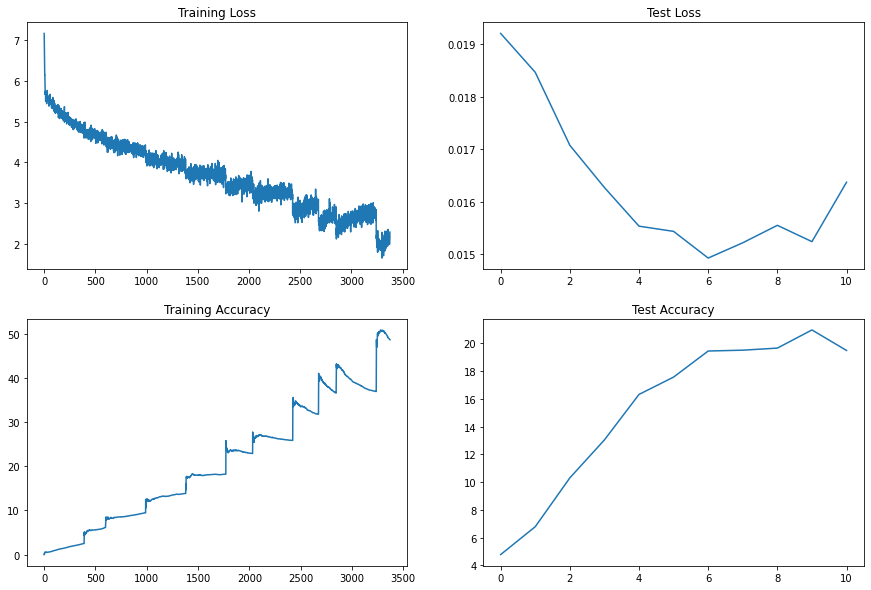

In [ ]:
%matplotlib inline
train_list=[]
for loss in train_losses:
  train_list.append(loss.cpu().detach().numpy())

fig, axs = plt.subplots(2,2,figsize=(15,10))
# fig.suptitle('Without dropout and batch norm', fontsize=16)
axs[0, 0].plot(train_list)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

### alexnet training

In [ ]:
model_alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_alexnet = model_alexnet.to(device)
summary(model_alexnet, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          23,296
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              ReLU-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:

optimizer = optim.SGD(model_alexnet.parameters(), lr=0.01, momentum=0.9)
last_loss = 1000000
patience = 5
trigger_times = 0
eps = 0.00001

for epoch in range(1, n_epochs+1):
    print('Epoch:',  epoch)
    train(model_alexnet, device, train_loader, optimizer, epoch, last_loss)
    test(model_alexnet, device, val_loader)

Epoch: 1



  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy=0.39

Accuracy=0.39

Trigger Times: 1
Accuracy=0.26

Accuracy=0.29

Trigger Times: 1
Accuracy=0.23

Accuracy=0.33

Trigger Times: 1
Accuracy=0.39

Accuracy=0.44

Accuracy=0.56

Trigger Times: 1
Accuracy=0.51

Trigger Times: 2
Accuracy=0.46

Accuracy=0.46

Trigger Times: 1
Accuracy=0.48

Trigger Times: 2
Accuracy=0.47

Accuracy=0.47

Trigger Times: 1
Accuracy=0.46

Accuracy=0.51

Trigger Times: 1
Accuracy=0.48

Accuracy=0.49

Accuracy=0.49

Trigger Times: 1
Accuracy=0.48

Trigger Times: 2
Accuracy=0.46

Trigger Times: 3
Accuracy=0.48

Trigger Times: 4
Accuracy=0.50

Accuracy=0.48

Trigger Times: 1
Accuracy=0.50

Trigger Times: 2
Accuracy=0.51

Accuracy=0.50

Trigger Times: 1
Accuracy=0.50

Accuracy=0.53

Trigger Times: 1
Accuracy=0.54

Trigger Times: 2
Accuracy=0.55

Accuracy=0.54

Accuracy=0.54

Trigger Times: 1
Accuracy=0.55

Accuracy=0.55

Accuracy=0.58

Accuracy=0.59

Accuracy=0.62

Trigger Times: 1
Accuracy=0.62

Trigger Times: 2
Accuracy=0.64

Accuracy=0.63

Accuracy=0.63

  0%|          | 0/391 [01:12<?, ?it/s]

Accuracy=0.64

Trigger Times: 1
Accuracy=0.65




Test set: Average loss: 0.0207, Accuracy: 85/10000 (0.85%)

Epoch: 2



  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy=0.00

Accuracy=0.20

Trigger Times: 1
Accuracy=0.26

Accuracy=0.49

Trigger Times: 1
Accuracy=0.78

Accuracy=0.98

Trigger Times: 1
Accuracy=0.84

Accuracy=0.98

Trigger Times: 1
Accuracy=0.95

Trigger Times: 2
Accuracy=0.98

Accuracy=0.99

Trigger Times: 1
Accuracy=0.94

Accuracy=0.99

Trigger Times: 1
Accuracy=0.95

Accuracy=0.96

Trigger Times: 1
Accuracy=1.00

Accuracy=1.03

Trigger Times: 1
Accuracy=1.06

Accuracy=1.17

Accuracy=1.19

Accuracy=1.26

Trigger Times: 1
Accuracy=1.28

Accuracy=1.31

Trigger Times: 1
Accuracy=1.32

Accuracy=1.30

Trigger Times: 1
Accuracy=1.25

Trigger Times: 2
Accuracy=1.29

Accuracy=1.28

Trigger Times: 1
Accuracy=1.25

Accuracy=1.24

Trigger Times: 1
Accuracy=1.26

Accuracy=1.28

Trigger Times: 1
Accuracy=1.30

Trigger Times: 2
Accuracy=1.29

Accuracy=1.28

Trigger Times: 1
Accuracy=1.27

Trigger Times: 2
Accuracy=1.27

Accuracy=1.31

Trigger Times: 1
Accuracy=1.33

Trigger Times: 2
Accuracy=1.31

Accuracy=1.30

Trigger Times: 1
Accuracy=1.

  0%|          | 0/391 [01:10<?, ?it/s]

Accuracy=1.48

Accuracy=1.48




Test set: Average loss: 0.0200, Accuracy: 227/10000 (2.27%)

Epoch: 3



  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy=1.95

Accuracy=1.76

Accuracy=1.56

Trigger Times: 1
Accuracy=1.56

Trigger Times: 2
Accuracy=1.56

Accuracy=1.56

Accuracy=1.67

Accuracy=1.66

Trigger Times: 1
Accuracy=1.82

Trigger Times: 2
Accuracy=1.80

Trigger Times: 3
Accuracy=1.81

Accuracy=1.86

Accuracy=1.80

Trigger Times: 1
Accuracy=1.81

Trigger Times: 2
Accuracy=1.80

Accuracy=1.78

Trigger Times: 1
Accuracy=1.77

Accuracy=1.71

Trigger Times: 1
Accuracy=1.71

Accuracy=1.80

Accuracy=1.82

Accuracy=1.83

Trigger Times: 1
Accuracy=1.87

Accuracy=1.92

Trigger Times: 1
Accuracy=1.94

Trigger Times: 2
Accuracy=1.88

Accuracy=1.88

Trigger Times: 1
Accuracy=1.88

Trigger Times: 2
Accuracy=1.87

Accuracy=1.86

Accuracy=1.84

Trigger Times: 1
Accuracy=1.84

Accuracy=1.86

Trigger Times: 1
Accuracy=1.88

Accuracy=1.88

Trigger Times: 1
Accuracy=1.84

Trigger Times: 2
Accuracy=1.84

Trigger Times: 3
Accuracy=1.85

Trigger Times: 4
Accuracy=1.86

Accuracy=1.86

Trigger Times: 1
Accuracy=1.89

Accuracy=1.88

Accuracy=1.91

  0%|          | 0/391 [01:11<?, ?it/s]

Accuracy=2.94

Accuracy=2.94




Test set: Average loss: 0.0188, Accuracy: 452/10000 (4.52%)

Epoch: 4



  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy=4.69

Accuracy=3.91

Accuracy=4.30

Accuracy=4.00

Accuracy=3.91

Trigger Times: 1
Accuracy=3.71

Accuracy=3.91

Trigger Times: 1
Accuracy=3.81

Trigger Times: 2
Accuracy=3.69

Accuracy=3.83

Trigger Times: 1
Accuracy=3.94

Accuracy=3.91

Trigger Times: 1
Accuracy=3.85

Accuracy=3.88

Trigger Times: 1
Accuracy=3.78

Trigger Times: 2
Accuracy=3.64

Accuracy=3.75

Trigger Times: 1
Accuracy=3.86

Accuracy=3.87

Trigger Times: 1
Accuracy=3.91

Trigger Times: 2
Accuracy=3.85

Trigger Times: 3
Accuracy=3.80

Accuracy=3.82

Trigger Times: 1
Accuracy=3.82

Accuracy=3.92

Accuracy=4.03

Accuracy=4.09

Trigger Times: 1
Accuracy=4.14

Trigger Times: 2
Accuracy=4.09

Accuracy=4.10

Trigger Times: 1
Accuracy=4.07

Trigger Times: 2
Accuracy=4.06

Trigger Times: 3
Accuracy=4.05

Accuracy=4.00

Accuracy=3.98

Trigger Times: 1
Accuracy=3.97

Accuracy=3.94

Accuracy=3.97

Trigger Times: 1
Accuracy=4.02

Accuracy=4.01

Trigger Times: 1
Accuracy=4.00

Accuracy=3.97

Accuracy=3.94

Trigger Times: 

  0%|          | 0/391 [00:35<?, ?it/s]



Test set: Average loss: 0.0182, Accuracy: 557/10000 (5.57%)

Epoch: 5



  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy=5.86

Accuracy=5.47

Trigger Times: 1
Accuracy=5.34

Trigger Times: 2
Accuracy=5.08

Accuracy=5.23

Accuracy=5.47

Trigger Times: 1
Accuracy=5.64

Accuracy=5.52

Accuracy=5.56

Trigger Times: 1
Accuracy=5.62

Accuracy=5.61

Accuracy=5.57

Accuracy=5.62

Trigger Times: 1
Accuracy=5.78

Accuracy=5.68

Trigger Times: 1
Accuracy=5.81

Accuracy=5.77

Trigger Times: 1
Accuracy=5.75

Accuracy=5.72

Trigger Times: 1
Accuracy=5.61

Accuracy=5.67

Trigger Times: 1
Accuracy=5.74

Trigger Times: 2
Accuracy=5.72

Accuracy=5.73

Trigger Times: 1
Accuracy=5.75

Trigger Times: 2
Accuracy=5.68

Accuracy=5.71

Trigger Times: 1
Accuracy=5.66

Accuracy=5.63

Trigger Times: 1
Accuracy=5.66

Trigger Times: 2
Accuracy=5.63

Accuracy=5.69

Accuracy=5.76

Trigger Times: 1
Accuracy=5.76

Accuracy=5.81

Accuracy=5.90

Trigger Times: 1
Accuracy=5.94

Trigger Times: 2
Accuracy=5.93

Accuracy=5.89

Trigger Times: 1
Accuracy=5.91

Trigger Times: 2
Accuracy=5.94

Accuracy=5.96

Trigger Times: 1
Accuracy=5.90

  0%|          | 0/391 [01:11<?, ?it/s]

Accuracy=6.20

Trigger Times: 1
Accuracy=6.20




Test set: Average loss: 0.0176, Accuracy: 720/10000 (7.20%)

Epoch: 6



  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy=5.86

Trigger Times: 1
Accuracy=8.20

Trigger Times: 2
Accuracy=7.29

Trigger Times: 3
Accuracy=6.84

Accuracy=6.95

Trigger Times: 1
Accuracy=7.29

Accuracy=7.14

Trigger Times: 1
Accuracy=7.23

Accuracy=7.29

Trigger Times: 1
Accuracy=7.27

Accuracy=7.32

Accuracy=7.26

Trigger Times: 1
Accuracy=7.18

Accuracy=7.20

Trigger Times: 1
Accuracy=7.14

Trigger Times: 2
Accuracy=7.08

Accuracy=7.01

Trigger Times: 1
Accuracy=6.99

Trigger Times: 2
Accuracy=6.97

Accuracy=7.05

Trigger Times: 1
Accuracy=7.27

Trigger Times: 2
Accuracy=7.21

Accuracy=7.22

Trigger Times: 1
Accuracy=7.21

Accuracy=7.14

Trigger Times: 1
Accuracy=7.12

Accuracy=7.20

Trigger Times: 1
Accuracy=7.14

Accuracy=7.25

Trigger Times: 1
Accuracy=7.16

Accuracy=7.13

Trigger Times: 1
Accuracy=7.04

Accuracy=7.04

Trigger Times: 1
Accuracy=6.96

Accuracy=6.93

Trigger Times: 1
Accuracy=6.91

Accuracy=6.88

Trigger Times: 1
Accuracy=6.84

Accuracy=6.89

Trigger Times: 1
Accuracy=6.91

Accuracy=6.89

Accuracy=6.

  0%|          | 0/391 [01:10<?, ?it/s]

Accuracy=7.98




Test set: Average loss: 0.0167, Accuracy: 1010/10000 (10.10%)

Epoch: 7



  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy=9.77

Trigger Times: 1
Accuracy=8.40

Accuracy=9.64

Trigger Times: 1
Accuracy=9.96

Trigger Times: 2
Accuracy=10.08

Accuracy=10.16

Trigger Times: 1
Accuracy=9.71

Accuracy=9.42

Trigger Times: 1
Accuracy=9.29

Accuracy=9.57

Accuracy=9.38

Accuracy=9.54

Accuracy=9.74

Trigger Times: 1
Accuracy=9.88

Accuracy=9.82

Accuracy=9.89

Trigger Times: 1
Accuracy=10.00

Accuracy=10.03

Trigger Times: 1
Accuracy=9.89

Accuracy=10.02

Trigger Times: 1
Accuracy=10.06

Accuracy=10.17

Trigger Times: 1
Accuracy=10.11

Accuracy=10.03

Accuracy=10.12

Trigger Times: 1
Accuracy=10.08

Trigger Times: 2
Accuracy=10.07

Accuracy=10.00

Accuracy=9.93

Accuracy=9.92

Accuracy=9.88

Trigger Times: 1
Accuracy=9.88

Accuracy=9.87

Accuracy=9.96

Trigger Times: 1
Accuracy=9.98

Accuracy=10.09

Trigger Times: 1
Accuracy=10.05

Trigger Times: 2
Accuracy=10.04

Accuracy=10.07

Trigger Times: 1
Accuracy=10.05

Accuracy=10.03

Trigger Times: 1
Accuracy=9.99

Accuracy=9.97

Accuracy=9.97

Trigger Times: 

  0%|          | 0/391 [01:11<?, ?it/s]

Accuracy=10.91




Test set: Average loss: 0.0164, Accuracy: 1158/10000 (11.58%)

Epoch: 8



  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy=11.33

Trigger Times: 1
Accuracy=11.13

Accuracy=11.98

Trigger Times: 1
Accuracy=12.70

Trigger Times: 2
Accuracy=13.75

Trigger Times: 3
Accuracy=13.80

Accuracy=13.90

Trigger Times: 1
Accuracy=13.04

Accuracy=13.24

Accuracy=13.24

Trigger Times: 1
Accuracy=13.10

Accuracy=13.18

Trigger Times: 1
Accuracy=13.37

Accuracy=13.50

Trigger Times: 1
Accuracy=13.26

Accuracy=13.26

Accuracy=13.30

Accuracy=13.45

Accuracy=13.57

Trigger Times: 1
Accuracy=13.34

Accuracy=13.32

Trigger Times: 1
Accuracy=13.26

Trigger Times: 2
Accuracy=13.15

Trigger Times: 3
Accuracy=12.97

Accuracy=13.00

Accuracy=12.95

Trigger Times: 1
Accuracy=12.98

Accuracy=13.04

Trigger Times: 1
Accuracy=13.05

Trigger Times: 2
Accuracy=13.06

Accuracy=13.08

Accuracy=13.06

Trigger Times: 1
Accuracy=13.03

Accuracy=13.09

Trigger Times: 1
Accuracy=13.11

Trigger Times: 2
Accuracy=13.15

Trigger Times: 3
Accuracy=13.12

Accuracy=13.20

Trigger Times: 1
Accuracy=13.22

Trigger Times: 2
Accuracy=13.12

Acc

  0%|          | 0/391 [00:51<?, ?it/s]



Test set: Average loss: 0.0157, Accuracy: 1441/10000 (14.41%)

Epoch: 9



  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy=10.94

Accuracy=14.45

Trigger Times: 1
Accuracy=14.06

Accuracy=14.55

Trigger Times: 1
Accuracy=14.61

Trigger Times: 2
Accuracy=14.45

Trigger Times: 3
Accuracy=14.56

Accuracy=14.55

Trigger Times: 1
Accuracy=14.50

Accuracy=14.69

Accuracy=14.95

Trigger Times: 1
Accuracy=15.23

Trigger Times: 2
Accuracy=15.47

Trigger Times: 3
Accuracy=15.29

Accuracy=15.39

Accuracy=15.38

Trigger Times: 1
Accuracy=15.30

Accuracy=15.26

Trigger Times: 1
Accuracy=15.23

Accuracy=15.12

Accuracy=15.18

Trigger Times: 1
Accuracy=15.16

Trigger Times: 2
Accuracy=15.23

Accuracy=15.35

Trigger Times: 1
Accuracy=15.34

Accuracy=15.38

Trigger Times: 1
Accuracy=15.38

Trigger Times: 2
Accuracy=15.46

Trigger Times: 3
Accuracy=15.45

Accuracy=15.56

Trigger Times: 1
Accuracy=15.37

Accuracy=15.33

Accuracy=15.29

Accuracy=15.37

Accuracy=15.56

Trigger Times: 1
Accuracy=15.59

Trigger Times: 2
Accuracy=15.61

Accuracy=15.66

Trigger Times: 1
Accuracy=15.61

Trigger Times: 2
Accuracy=15.56

Acc

  0%|          | 0/391 [01:12<?, ?it/s]

Accuracy=15.96

Trigger Times: 1
Accuracy=15.96




Test set: Average loss: 0.0153, Accuracy: 1560/10000 (15.60%)

Epoch: 10



  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy=16.41

Trigger Times: 1
Accuracy=15.23

Accuracy=16.02

Accuracy=16.21

Trigger Times: 1
Accuracy=16.64

Accuracy=17.19

Trigger Times: 1
Accuracy=17.86

Accuracy=17.77

Accuracy=18.01

Trigger Times: 1
Accuracy=18.44

Trigger Times: 2
Accuracy=18.39

Trigger Times: 3
Accuracy=18.49

Accuracy=18.60

Trigger Times: 1
Accuracy=18.44

Accuracy=18.44

Trigger Times: 1
Accuracy=18.65

Accuracy=18.73

Trigger Times: 1
Accuracy=18.66

Trigger Times: 2
Accuracy=18.61

Accuracy=18.59

Trigger Times: 1
Accuracy=18.68

Accuracy=18.54

Accuracy=18.65

Accuracy=18.72

Accuracy=18.73

Trigger Times: 1
Accuracy=18.60

Accuracy=18.52

Trigger Times: 1
Accuracy=18.54

Accuracy=18.67

Trigger Times: 1
Accuracy=18.67

Accuracy=18.70

Accuracy=18.82

Trigger Times: 1
Accuracy=18.75

Accuracy=18.70

Trigger Times: 1
Accuracy=18.76

Trigger Times: 2
Accuracy=18.68

Accuracy=18.71

Trigger Times: 1
Accuracy=18.63

Accuracy=18.63

Accuracy=18.69

Trigger Times: 1
Accuracy=18.60

Accuracy=18.65

Trigg

  0%|          | 0/391 [01:00<?, ?it/s]



Test set: Average loss: 0.0146, Accuracy: 1878/10000 (18.78%)

Epoch: 11



  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy=17.58

Trigger Times: 1
Accuracy=17.77

Accuracy=16.93

Trigger Times: 1
Accuracy=17.09

Accuracy=17.50

Accuracy=18.95

Trigger Times: 1
Accuracy=18.92

Accuracy=19.53

Trigger Times: 1
Accuracy=19.36

Accuracy=19.53

Trigger Times: 1
Accuracy=19.74

Trigger Times: 2
Accuracy=19.99

Trigger Times: 3
Accuracy=20.07

Accuracy=19.95

Trigger Times: 1
Accuracy=19.84

Accuracy=19.95

Trigger Times: 1
Accuracy=19.92

Accuracy=19.97

Accuracy=20.00

Accuracy=20.04

Trigger Times: 1
Accuracy=19.83

Accuracy=19.92

Trigger Times: 1
Accuracy=19.89

Trigger Times: 2
Accuracy=19.79

Accuracy=19.78

Accuracy=19.83

Trigger Times: 1
Accuracy=19.82

Trigger Times: 2
Accuracy=19.80

Accuracy=19.72

Accuracy=19.70

Accuracy=19.81

Trigger Times: 1
Accuracy=19.76

Accuracy=19.84

Trigger Times: 1
Accuracy=19.83

Accuracy=19.88

Trigger Times: 1
Accuracy=19.92

Accuracy=19.82

Accuracy=19.82

Accuracy=19.90

Trigger Times: 1
Accuracy=20.07

Trigger Times: 2
Accuracy=20.07

Trigger Times: 3
Accu

  0%|          | 0/391 [01:21<?, ?it/s]

Accuracy=20.60

Accuracy=20.61




Test set: Average loss: 0.0145, Accuracy: 1927/10000 (19.27%)



#### AlexNet average train accuracy: 20.60%
#### AlexNet average test accuracy: 19.27%
#### Take into account that eps = current_loss - previous_loss = 0.00001, so the training stopped before the model reaches its capacity

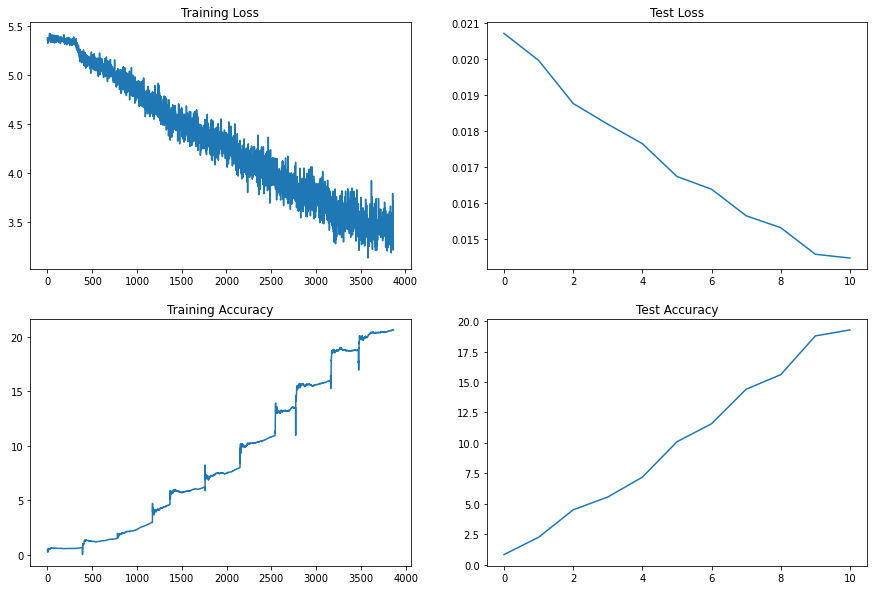

In [ ]:
%matplotlib inline
train_list=[]
for loss in train_losses:
  train_list.append(loss.cpu().detach().numpy())

fig, axs = plt.subplots(2,2,figsize=(15,10))
# fig.suptitle('Without dropout and batch norm', fontsize=16)
axs[0, 0].plot(train_list)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()


  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy=18.75

Accuracy=21.48

Trigger Times: 1
Accuracy=22.53

Trigger Times: 2
Accuracy=22.17

Accuracy=22.50

Trigger Times: 1
Accuracy=22.46

Accuracy=22.99

Trigger Times: 1
Accuracy=23.10

Accuracy=23.39

Trigger Times: 1
Accuracy=23.79

Trigger Times: 2
Accuracy=23.44

Accuracy=23.47

Accuracy=23.11

Trigger Times: 1
Accuracy=23.07

Trigger Times: 2
Accuracy=23.05

Accuracy=23.14

Trigger Times: 1
Accuracy=23.30

Trigger Times: 2
Accuracy=23.00

Accuracy=22.96

Trigger Times: 1
Accuracy=22.91

Accuracy=22.73

Trigger Times: 1
Accuracy=22.82

Accuracy=22.91

Accuracy=22.80

Accuracy=22.80

Trigger Times: 1
Accuracy=22.67

Accuracy=22.53

Trigger Times: 1
Accuracy=22.49

Accuracy=22.54

Trigger Times: 1
Accuracy=22.63

Accuracy=22.73

Trigger Times: 1
Accuracy=22.78

Accuracy=22.92

Trigger Times: 1
Accuracy=22.87

Trigger Times: 2
Accuracy=22.70

Accuracy=22.73

Trigger Times: 1
Accuracy=22.80

Trigger Times: 2
Accuracy=22.86

Accuracy=23.01

Trigger Times: 1
Accuracy=23.03

Acc

  0%|          | 0/391 [01:17<?, ?it/s]

Accuracy=22.91

Accuracy=22.92



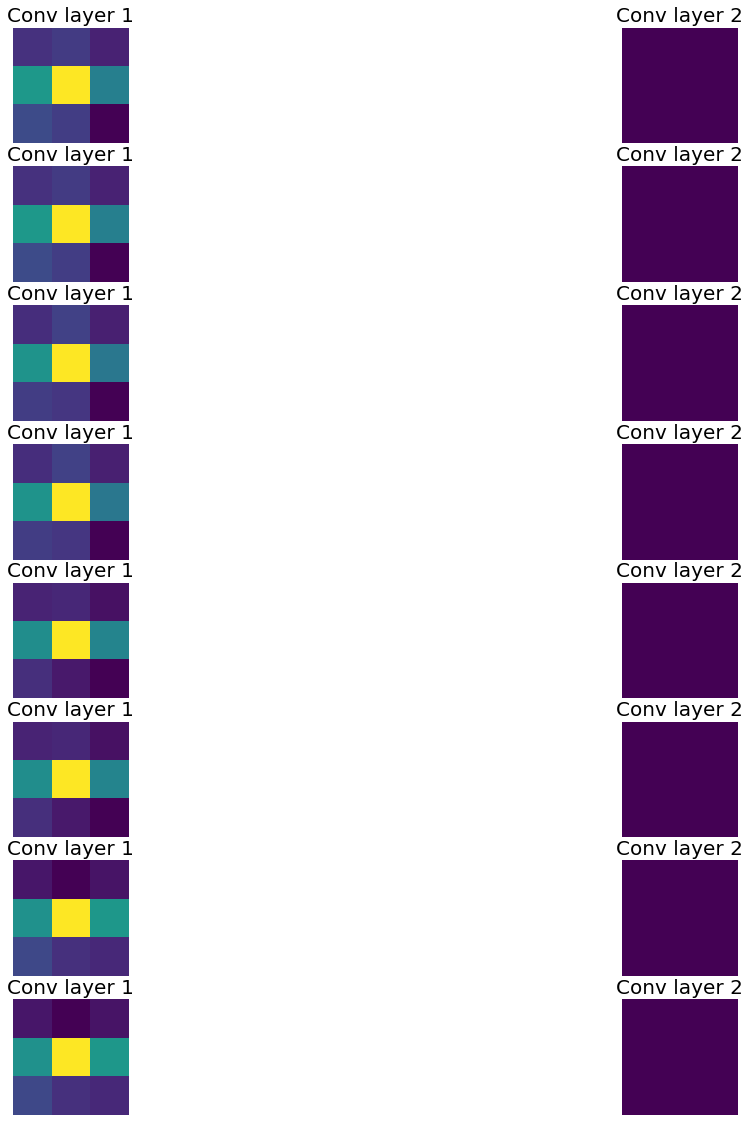

In [ ]:
outputimages_conv1 = []
outputimages_conv2 = []

def display_conv1(self, input, output):
    activation_map = output
    activation_map = activation_map.squeeze(0)
    gray_scale = torch.sum(activation_map,0)
    gray_scale = gray_scale / activation_map.shape[0]
    outputimages_conv1.append(gray_scale.data.cpu().numpy())

def display_conv2(self, input, output):
    activation_map = output
    activation_map = activation_map.squeeze(0)
    gray_scale = torch.sum(activation_map,0)
    gray_scale = gray_scale / activation_map.shape[0]
    outputimages_conv2.append(gray_scale.data.cpu().numpy())

#call training function after attaching hooks to get convolution output images


model_alexnet.features[10].register_forward_hook(display_conv1)
model_alexnet.features[12].register_forward_hook(display_conv2)

# loss_vanila =train(model_resnet, epoch = 1)
optimizer = optim.SGD(model_alexnet.parameters(), lr=0.01, momentum=0.9)
train(model_alexnet, device, train_loader, optimizer, 1, 100000)

#display conv layer1

fig = plt.figure(figsize=(20, 20))
cols = 2
images_tobe_displayed = min(8,len(outputimages_conv1))
rows = images_tobe_displayed // 2 * cols
 
for i in range(images_tobe_displayed):
    a = fig.add_subplot(rows, cols, i*2+1)
    a.axis('off')
    imgplot = plt.imshow(outputimages_conv1[i][0])
#     a.set_title(names[i].split('(')[0], fontsize=20)
    a.set_title("Conv layer 1", fontsize=20)
    
    a = fig.add_subplot(rows, cols, i*2+2)
    a.axis('off')
    imgplot = plt.imshow(outputimages_conv2[i][0])
#     a.set_title(names[i].split('(')[0], fontsize=20)
    a.set_title("Conv layer 2", fontsize=20)

    
outputimages_conv1 = []
outputimages_conv2 = []

Because the majority of AlexNet's parameters are in its fully connected layers, and if given enough time, ResNet-50 has a much greater ability to extract features. However, when considering training accuracy, ResNet-50 is heavily overfitting the data (and we haven't used image augmentation), but overall, ResNet-50 will be a good choice for this image classification task.

# Q2

###(a)

In [ ]:

isFile = os.path.exists("./data") 
print("data downloaded ", isFile)
if isFile == False:
  !wget "https://download.pytorch.org/tutorial/data.zip" -O "./data.zip"
  !unzip -u "./data.zip" -d "./"

data downloaded  False
--2022-05-04 17:10:09--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.112, 18.160.200.126, 18.160.200.71, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘./data.zip’

./data.zip          100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2022-05-04 17:10:09 (22.5 MB/s) - ‘./data.zip’ saved [2882130/2882130]

Archive:  ./data.zip
   creating: ./data/
  inflating: ./data/eng-fra.txt      
   creating: ./data/names/
  inflating: ./data/names/Arabic.txt  
  inflating: ./data/names/Chinese.txt  
  inflating: ./data/names/Czech.txt  
  inflating: ./data/names/Dutch.txt  
  inflating: ./data/names/English.txt  
  inflating: ./data/names/French.txt  
  inflating: ./data/names/German.txt  
  inflating: ./data/names/Greek.txt  
  inflating: ./data/n

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Spanish.txt', 'data/names/Czech.txt', 'data/names/Arabic.txt', 'data/names/French.txt', 'data/names/Polish.txt', 'data/names/English.txt', 'data/names/Russian.txt', 'data/names/Dutch.txt', 'data/names/Portuguese.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Vietnamese.txt', 'data/names/Chinese.txt', 'data/names/German.txt', 'data/names/Italian.txt', 'data/names/Scottish.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt']
Slusarski


In [ ]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
#         print("rnn forward i h c", input.shape, hidden.shape, combined.shape)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
#         print("rnn forward i h", input.shape, hidden.shape)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input = letterToTensor('A')
print ("input ", input)
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

input  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9357, -2.8268, -2.8701, -2.9227, -3.0029, -2.8899, -2.9316, -2.9241,
         -2.8013, -2.8931, -2.9280, -2.8310, -2.8593, -2.8786, -2.8285, -2.9409,
         -2.8701, -2.9142]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Portuguese', 8)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Fumihiko
category = German / line = Kundert
category = Portuguese / line = Santana
category = Polish / line = Skala
category = Korean / line = Sook
category = Japanese / line = Kajiyama
category = Spanish / line = Abano
category = English / line = Brock
category = English / line = Grimes
category = Czech / line = Oborny


In [ ]:
criterion = nn.NLLLoss()

### training rnn

In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train_rnn(rnn, category_tensor, line_tensor):
    
    if isinstance(rnn, RNN) :
        hidden = rnn.initHidden()
    else:
        hidden = rnn.initHidden(line_tensor.size()[0])
        
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def rnn_start_training(rnn):
    start = time.time()

    n_iters = 100000
    print_every = 5000
    plot_every = 1000
    
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        
        output, loss = train_rnn(rnn, category_tensor, line_tensor)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
        
    plt.figure()
    plt.plot(all_losses)

    return all_losses
            


5000 5% (0m 9s) 3.4218 Santillian / Russian ✗ (Spanish)
10000 10% (0m 17s) 1.2341 Vygodovsky / Russian ✓
15000 15% (0m 25s) 2.5853 Kelly / English ✗ (Scottish)
20000 20% (0m 32s) 1.8565 Sauvage / Arabic ✗ (French)
25000 25% (0m 40s) 3.0113 Sawyer / Arabic ✗ (English)
30000 30% (0m 49s) 1.7041 Kwei / Korean ✗ (Chinese)
35000 35% (0m 57s) 1.0204 Slapnickova / Czech ✓
40000 40% (1m 5s) 1.8596 Heidl / Irish ✗ (Czech)
45000 45% (1m 12s) 1.6950 Pinho / Portuguese ✓
50000 50% (1m 20s) 0.2236 Adamidis / Greek ✓
55000 55% (1m 27s) 1.5984 Hanzlik / Czech ✓
60000 60% (1m 34s) 0.5176 Taflambas / Greek ✓
65000 65% (1m 41s) 0.4624 Quyen / Vietnamese ✓
70000 70% (1m 48s) 2.2676 Parris / Spanish ✗ (French)
75000 75% (1m 55s) 0.1187 Ratti / Italian ✓
80000 80% (2m 2s) 0.5381 Pham / Vietnamese ✓
85000 85% (2m 10s) 0.0730 O'Brian / Irish ✓
90000 90% (2m 17s) 0.2056 Araullo / Portuguese ✓
95000 95% (2m 24s) 2.4713 Deeb / Vietnamese ✗ (Arabic)
100000 100% (2m 31s) 1.4670 Button / French ✗ (English)


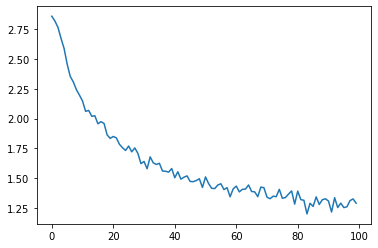

In [ ]:
all_losses = rnn_start_training(rnn)


### validating rnn

In [ ]:


# Just return an output given a line
def evaluate(rnn, line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def start_evaluate(rnn):
    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_categories, n_categories)
    n_confusion = 10000

    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output = evaluate(rnn, line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()
    
    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()
    
    return confusion





  0%|          | 0/391 [20:15<?, ?it/s]


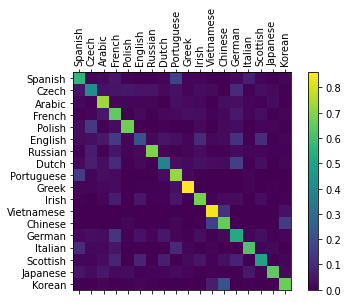

In [ ]:
confusion = start_evaluate(rnn)

##(b)

GRU Training
500 5% (0m 2s) 3.7101 Grant / Irish ✗ (Scottish)
1000 10% (0m 5s) 1.8403 Hatton / Scottish ✗ (English)
1500 15% (0m 8s) 1.0775 Weineltk / Polish ✗ (Czech)
2000 20% (0m 11s) 4.2571 Ludwig / Arabic ✗ (Czech)
2500 25% (0m 14s) 1.8005 Tsogas / Arabic ✗ (Greek)
3000 30% (0m 17s) 0.9124 Poirier / French ✓
3500 35% (0m 19s) 1.8071 Lai / Vietnamese ✗ (Chinese)
4000 40% (0m 22s) 0.9473 Konoe / Japanese ✓
4500 45% (0m 25s) 0.8154 Banh / Vietnamese ✓
5000 50% (0m 28s) 0.6963 Close / Greek ✓
5500 55% (0m 31s) 0.0033 O'Mooney / Irish ✓
6000 60% (0m 33s) 1.5661 Tifft / English ✗ (German)
6500 65% (0m 36s) 1.3148 Proulx / German ✗ (French)
7000 70% (0m 39s) 4.5778 Holzmann / English ✗ (German)
7500 75% (0m 41s) 1.4196 Urbina / Italian ✗ (Spanish)
8000 80% (0m 44s) 0.8762 Brodbeck / German ✓
8500 85% (0m 47s) 0.3486 Zavala / Spanish ✓
9000 90% (0m 49s) 0.0042 Fotopoulos / Greek ✓
9500 95% (0m 52s) 3.4620 Krol / Chinese ✗ (Polish)
10000 100% (0m 55s) 4.4038 Bover / Russian ✗ (Italian)


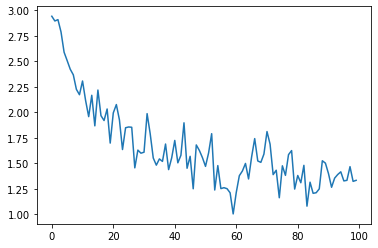

In [ ]:
class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.num_layers = n_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=n_layers,
        )
        self.fc = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x, h):
#         print("forward intput ", x.shape,"hidden " , h.shape)
        hidden_state = self.initHidden(1)
        output, hidden_state = self.gru(x, hidden_state)
        output = self.fc(output[-1])
        return output, hidden
    
    def initHidden(self):
         return torch.zeros(self.n_layers, 1, self.hidden_size)
        
    def initHidden(self, batch_size =1):
         return torch.zeros(self.n_layers, 1, self.hidden_size)
    
n_layers = 2
gru = GRUNet(n_letters, n_hidden, n_categories,  n_layers = n_layers)
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
h0 = torch.randn(n_categories, 10, n_hidden  )

print("GRU Training")
criterion = nn.CrossEntropyLoss()
start = time.time()

n_iters = 10000
print_every = 500
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []
    

current_loss = 0
for iter in  range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, hidden = gru(line_tensor, h0)
    loss = criterion(output, category_tensor)
    current_loss += loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plt.figure()
plt.plot(all_losses)
        


Confusion matrix GRU


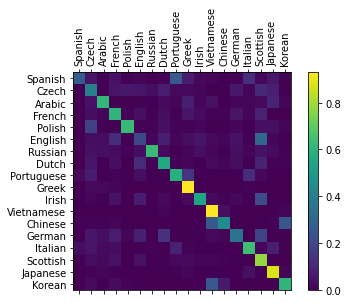

In [ ]:
def start_evaluate_gru_lstm(rnn):
    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_categories, n_categories)
    n_confusion = 10000

    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomTrainingExample()
#         output = evaluate(rnn, line_tensor)
        output, hidden =  gru(line_tensor, h0)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()
    
    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()
    
    return confusion
print ( "Confusion matrix GRU")
confusion = start_evaluate_gru_lstm(gru)

##(c)

LSTM training
500 5% (1m 12s) 2.3893 Juarez / Spanish ✓
1000 10% (1m 16s) 2.8075 Kiddle / French ✗ (English)
1500 15% (1m 18s) 0.2314 Paloumbas / Greek ✓
2000 20% (1m 21s) 1.3529 De santigo / Portuguese ✓
2500 25% (1m 24s) 1.6287 Zhui / Korean ✗ (Chinese)
3000 30% (1m 27s) 1.3393 Longo / Japanese ✗ (Italian)
3500 35% (1m 30s) 2.5133 Campos / Arabic ✗ (Spanish)
4000 40% (1m 33s) 1.0685 Seok / Korean ✓
4500 45% (1m 36s) 0.2542 Kyubei / Japanese ✓
5000 50% (1m 40s) 2.6647 Sztegon / Irish ✗ (Czech)
5500 55% (1m 43s) 4.5126 Carmichael / German ✗ (English)
6000 60% (1m 46s) 4.7333 Fairclough / French ✗ (English)
6500 65% (1m 49s) 0.9105 Cuan / Chinese ✓
7000 70% (1m 52s) 1.6356 Thai / Chinese ✗ (Vietnamese)
7500 75% (1m 55s) 0.3053 Bilek / Czech ✓
8000 80% (1m 58s) 0.4703 Gaspari / Italian ✓
8500 85% (2m 1s) 0.9365 Kaplanek / Czech ✓
9000 90% (2m 4s) 4.9235 Rott / Scottish ✗ (Russian)
9500 95% (2m 7s) 0.0500 Nahas / Arabic ✓
10000 100% (2m 10s) 0.0756 Cardozo / Portuguese ✓


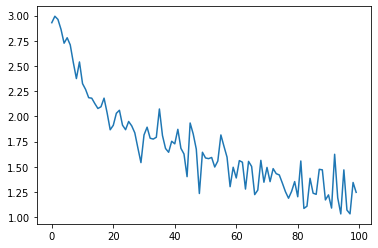

In [ ]:
device = "cpu"
class LSTMNet(nn.Module):
    def __init__(self,  input_size, hidden_size, output_size, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_size = input_size
        self.n_layers = n_layers
        
        self.num_layers = n_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=n_layers,
        )
        self.fc = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x, h):
        hidden_state = self.initHidden(1)
        output, hidden_state = self.lstm(x, hidden_state)
        output = self.fc(output[-1])
        
        return output, hidden_state
    
    def initHidden(self):
         return torch.zeros(self.n_layers, 1, self.hidden_size)
        
    def initHidden(self, batch_size =1):
#          return torch.zeros(self.n_layers, 1, self.hidden_size)
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device))
        return hidden
        
 #(n_letters, n_hidden, n_categories,  n_layers = n_layers)   
lstm = LSTMNet(n_letters, n_hidden, n_categories,  n_layers = n_layers)
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

print( "LSTM training")
all_losses = []
current_loss = 0
for iter in  range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, hidden = lstm(line_tensor, h0)
    loss = criterion(output, category_tensor)
    current_loss += loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plt.figure()
plt.plot(all_losses)
   

Confusion matrix LSTM


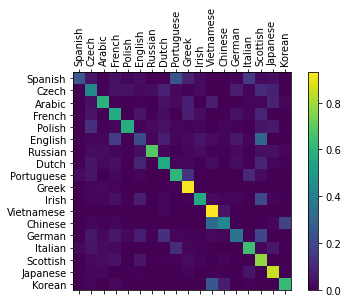

In [ ]:
print ("Confusion matrix LSTM")
confusion = start_evaluate_gru_lstm(lstm)